In [ ]:
# Import all required libraries
import torch
from datasets import load_dataset
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.general_recommender import BPR, Pop, ItemKNN, LightGCN
from recbole.model.sequential_recommender import SASRec
from recbole.utils import init_seed, init_logger, get_trainer

# Set torch.load compatibility
torch.serialization.add_safe_globals([dict, list, tuple, set])

print("All libraries imported successfully!")

## Recaller Training

In [ ]:
# Load Amazon Reviews 2023 dataset using RecBole
from GRPO.data import get_base_config_dict
import os
for dataset_name in os.listdir('dataset'):
    try:
        config_5core = Config(
            model='SASRec',
            dataset=dataset_name, 
            config_dict=get_base_config_dict(dataset_name)
        )

        # 创建5-core过滤后的数据集
        print(f"=== Loading {dataset_name} ===")
        print("Creating 5-core filtered dataset...")
        from recbole.utils import init_seed as recbole_init_seed
        recbole_init_seed(seed=42, reproducibility=True)
        dataset_5core = create_dataset(config_5core)
        train_data_5core, valid_data_5core, test_data_5core = data_preparation(config_5core, dataset_5core)
        print(f"\n📊 5-core Filtered Dataset Statistics:")
        print(dataset_5core)
        # train set stats
        import numpy as np
        print(train_data_5core.dataset)
        print(np.unique(train_data_5core.dataset.inter_feat['user_id'].numpy()).shape)
        print(valid_data_5core.dataset)
        print(np.unique(valid_data_5core.dataset.inter_feat['user_id'].numpy()).shape)
        print(test_data_5core.dataset)
        print(np.unique(test_data_5core.dataset.inter_feat['user_id'].numpy()).shape)
    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")
        continue



In [ ]:
# Define unified model training function
def train_model(model_type, dataset_name='All_Beauty', epochs=10, **kwargs):
    """
    Unified function to train recommendation models
    
    Args:
        model_type: Model type ('BPR', 'SASRec', 'Pop')
        dataset_name: Dataset name
        epochs: Training epochs·
        **kwargs: Additional model-specific parameters
    
    Returns:
        dict: Dictionary containing model, trainer, config and results
    """
    
    print(f"\n=== Training {model_type} Model ===")
    
    # Base configuration
    base_config = {
        # 'data_path': 'seq_rec_results/dataset/processed/',
        # 'benchmark_filename': ['train', 'valid', 'test'],
        'epochs': epochs,
        'stopping_step': 10,
        'eval_step': 1,
        'metrics': ['Recall', 'NDCG'],
        'topk': [10, 50],
        'valid_metric': 'NDCG@10',
        'checkpoint_dir': './checkpoint',
        'show_progress': True,
        'save_dataset': True,
        'save_dataloaders': True,
    }
    base_config.update({
        'data_path': 'dataset',
        'load_col': {
            # 'inter': ['user_id', 'item_id', 'rating', 'timestamp'],
            'inter': ['user_id', 'item_id', 'timestamp']
        },
        'user_inter_num_interval': "[5,inf)",
        'item_inter_num_interval': "[5,inf)",
        'train_neg_sample_args': None,
        'loss_type': 'CE',
        # 'val_interval': {
        #     'rating': '[3,inf)'  # 只保留rating >= 4的交互
        # },
        'eval_args': {
            'split': {'RS': [0.8, 0.1, 0.1]},  # Leave-One-Out
            'order': 'TO',  # Temporal Order
            'group_by': 'user'
        },
        'ITEM_ID_FIELD': 'item_id',
    })
    
    # Model-specific configurations
    if model_type == 'BPR':
        model_class = BPR
        model_config = {
            **base_config,
            'train_neg_sample_args': {
                'distribution': 'uniform',
                'sample_num': 1,
                'alpha': 1.0,
                'dynamic': False,
                'candidate_num': 0
            },
            'loss_type': 'BPR',
            'learning_rate': 0.001,
            'train_batch_size': 2048,
            'eval_batch_size': 2048 * 20000,
        }
        
    elif model_type == 'SASRec':
        model_class = SASRec
        model_config = {
            **base_config,
            'train_neg_sample_args': None,
            'loss_type': 'CE',
            'learning_rate': 0.001,
            'train_batch_size': 256,
            'max_seq_length': 50,
            'hidden_size': 64,
            'n_layers': 2,
            'n_heads': 2,
            'inner_size': 256,
            'hidden_dropout_prob': 0.5,
            'attn_dropout_prob': 0.5,
        }
        
    elif model_type == 'Pop':
        model_class = Pop
        model_config = {
            **base_config,
            'train_neg_sample_args': None,
        }
    elif model_type == 'ItemKNN':
        model_class = ItemKNN
        model_config = {
            **base_config,
            'train_neg_sample_args': None,
            'eval_batch_size': 2048 * 20000,
        }
    elif model_type == 'LightGCN':
        model_class = LightGCN
        model_config = {
            **base_config,
            # LightGCN需要负采样
            'train_neg_sample_args': {
                'distribution': 'uniform',
                'sample_num': 1,  # 每个正样本配1个负样本
            },
            'loss_type': 'BPR',
            'embedding_size': 64,
            'n_layers': 3,  # GCN层数
            'reg_weight': 1e-5,  # 正则化系数
            'learning_rate': 0.001,
            'train_batch_size': 2048,
            'eval_batch_size': 2048 * 20000,
        }
    elif model_type == 'SimpleX':
        from recbole.model.general_recommender import SimpleX
        model_class = SimpleX
        model_config = {
            **base_config,
            'train_neg_sample_args': {
                'distribution': 'uniform',
                'sample_num': 1,
            },
            'loss_type': 'BPR',
            'embedding_size': 64,
            'aggregator': 'mean',  # 或 'user_attention', 'self_attention'
            'gamma': 0.5,
            'margin': 0.9,
            'negative_weight': 0.5,
            'reg_weight': 1e-5,
            'learning_rate': 0.001,
            'train_batch_size': 2048,
            'eval_batch_size': 2048 * 20000,
        }
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Merge user-defined parameters
    model_config.update(kwargs)
    
    # Create config and dataset
    config = Config(
        model=model_type,
        dataset=dataset_name,
        config_dict=model_config
    )
    config['dataset_save_path'] = f'{config["checkpoint_dir"]}/'
    # Create dataset
    model_dataset = create_dataset(config)
    train_data, valid_data, test_data = data_preparation(config, model_dataset)
    
    print(f"{model_type} dataset stats:")
    print(f"Users: {model_dataset.user_num}")
    print(f"Items: {model_dataset.item_num}")
    print(f"Interactions: {model_dataset.inter_num}")
    
    # Initialize model and trainer
    init_seed(config['seed'], config['reproducibility'])
    model = model_class(config, model_dataset).to(config['device'])
    trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)
    
    print(f"Training {model_type} model...")
    
    # torch.load compatibility settings
    original_load = torch.load
    def safe_load(*args, **kwargs):
        kwargs['weights_only'] = False
        return original_load(*args, **kwargs)
    torch.load = safe_load
    
    try:
        # Train model
        best_valid_score, best_valid_result = trainer.fit(
            train_data, valid_data, saved=True, show_progress=True
        )
        
        print(f"{model_type} training completed!")
        print(f"Best validation result: {best_valid_result}")
        
        # Test model
        test_result = trainer.evaluate(test_data, load_best_model=True, show_progress=True)
        print(f"{model_type} test result: {test_result}")
        
        return {
            'model_type': model_type,
            'model': model,
            'trainer': trainer,
            'config': config,
            'dataset': model_dataset,
            'train_data': train_data,
            'valid_data': valid_data,
            'test_data': test_data,
            'best_valid_result': best_valid_result,
            'test_result': test_result
        }
        
    finally:
        # Restore original torch.load function
        torch.load = original_load

print("Unified training function defined!")

In [ ]:
# Train all models using unified function
print("=== Training All Models with Unified Function ===")

# Store all model results
model_results = {}
dataset_name = "ml-1m"
# Train all three models
models_to_train = [
    # {'model_type': 'BPR', 'epochs': 100},
    # {'model_type': 'LightGCN', 'epochs': 100},
    # {'model_type': 'SimpleX', 'epochs': 100},
    {'model_type': 'SASRec', 'epochs': 100},
]

for model_config in models_to_train:
        result = train_model(
            dataset_name=dataset_name,
            model_type=model_config['model_type'],
            epochs=model_config['epochs']
        )
        model_results[model_config['model_type']] = result
        print(f"✅ {model_config['model_type']} training successful")

print(f"\nTraining completed! Successfully trained {len([r for r in model_results.values() if r is not None])} models")

In [ ]:
from recbole.utils import load_data_and_model

In [ ]:
# Unified model performance comparison and analysis
def compare_models(model_results):
    """Compare all trained models"""
    
    print("\n" + "="*70)
    print("                Model Performance Comparison Report")
    print("="*70)
    
    # Extract test results
    results_summary = {}
    for model_type, result in model_results.items():
        if result is not None:
            results_summary[model_type] = result['test_result']
        else:
            results_summary[model_type] = {}
    
    # Create comparison table
    print(f"\n{'Metric':<15}", end="")
    model_names = list(results_summary.keys())
    for name in model_names:
        print(f" | {name:<12}", end="")
    print()
    print("-" * (15 + 15 * len(model_names)))
    
    metrics_to_compare = ['recall@10', 'ndcg@10', 'recall@20', 'ndcg@20']
    best_scores = {}
    
    for metric in metrics_to_compare:
        print(f"{metric:<15}", end="")
        metric_values = []
        
        for model_type in model_names:
            value = results_summary[model_type].get(metric, 'N/A')
            if value != 'N/A':
                print(f" | {value:<12.4f}", end="")
                metric_values.append((model_type, value))
            else:
                print(f" | {'N/A':<12}", end="")
        
        print()
        
        # Find best model
        if metric_values:
            best_model, best_score = max(metric_values, key=lambda x: x[1])
            best_scores[metric] = (best_model, best_score)
    
    print("-" * (15 + 15 * len(model_names)))
    
    # Analyze best models
    print(f"\n🏆 Best model for each metric:")
    for metric, (best_model, best_score) in best_scores.items():
        print(f"  {metric}: {best_model} ({best_score:.4f})")
    
    # Overall model ranking
    model_scores = {name: [] for name in model_names}
    for metric in metrics_to_compare:
        for model_type in model_names:
            value = results_summary[model_type].get(metric, 0)
            if value != 'N/A' and value != 0:
                model_scores[model_type].append(value)
    
    avg_scores = {name: sum(scores)/len(scores) if scores else 0 
                  for name, scores in model_scores.items()}
    
    print(f"\n📊 Overall model ranking:")
    sorted_models = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)
    for i, (model, score) in enumerate(sorted_models, 1):
        print(f"  {i}. {model}: {score:.4f} (avg score)")
    
    # Model characteristics analysis
    print(f"\n📝 Model characteristics:")
    model_analysis = {
        'Pop': 'Item popularity based, fast training, good for cold start',
        'BPR': 'Collaborative filtering, personalized, balanced performance',  
        'SASRec': 'Sequential recommendation, temporal patterns, rich historical data'
    }
    
    for model_type in model_names:
        if model_type in model_analysis:
            status = "✅ Success" if model_results[model_type] else "❌ Failed"
            print(f"  • {model_type}: {model_analysis[model_type]} [{status}]")
    
    return best_scores, sorted_models

# Execute model comparison
if model_results:
    best_scores, model_ranking = compare_models(model_results)
else:
    print("⚠️ No model results to compare, please run model training first")

## Dataset Test

In [ ]:
import json
import os
domain = 'Amazon_All_Beauty'

In [ ]:
from datasets import load_dataset
# domain = 'All_Beauty'
# meta_data = json.load(open(f'seq_rec_results/dataset/processed/{domain}/{domain}.data_maps'))
datasets = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",
    f"5core_timestamp_w_his_{domain}",
    trust_remote_code=True
)
raw_review_path = f'dataset/{domain}/{domain}.jsonl'
if not os.path.exists(raw_review_path):
    print(f'Downloading {domain} reviews from Hugging Face...')
    import wget
    wget.download(f'https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/{domain}.jsonl?download=true', raw_review_path)
# len(meta_data['item2id']), len(meta_data['user2id'])

In [ ]:
from tqdm import tqdm
review_list = []
with open(raw_review_path, 'r') as f:
    for line in tqdm(f):
        review_list.append(json.loads(line))


In [ ]:
user_set = set(meta_data['user2id'].keys())
item_set = set(meta_data['item2id'].keys())

In [ ]:
review_list[0]

In [ ]:
from collections import defaultdict

user2reviews = defaultdict(list)
for review in tqdm(review_list):
    if review['user_id'] in user_set and review['asin'] in item_set:
        user2reviews[review['user_id']].append({
            'asin': review['asin'],
            'rating': review['rating'],
            'title': review['title'],
            'text': review['text'],
            'item_id': meta_data['item2id'][review['asin']],
            'timestamp': review['timestamp'],
            'helpful_vote': review['helpful_vote'],
            'verified_purchase': review['verified_purchase'],
        })

    

In [ ]:
# save user2reviews
with open(f'seq_rec_results/dataset/processed/{domain}/{domain}.reviews', 'w') as f:
    json.dump(user2reviews, f)

## General Test

In [ ]:
import outlines
from transformers import AutoTokenizer, AutoModelForCausalLM


MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
model = outlines.from_transformers(
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto"),
    AutoTokenizer.from_pretrained(MODEL_NAME)
)

In [ ]:
from pydantic import BaseModel
from enum import Enum

class Rating(Enum):
    poor = 1
    fair = 2
    good = 3
    excellent = 4

class ProductReview(BaseModel):
    rating: Rating
    pros: list[str]
    cons: list[str]
    summary: str

review = model(
    "Review: The XPS 13 has great battery life and a stunning display, but it runs hot and the webcam is poor quality.",
    ProductReview,
    max_new_tokens=200,
)

review = ProductReview.model_validate_json(review)
print(f"Rating: {review.rating.name}")  # "Rating: good"
print(f"Pros: {review.pros}")           # "Pros: ['great battery life', 'stunning display']"
print(f"Summary: {review.summary}")     # "Summary: Good laptop with great display but thermal issues"

## vLLM Test

In [ ]:
from enum import Enum
from pydantic import BaseModel
from vllm import LLM, SamplingParams
from vllm.sampling_params import GuidedDecodingParams

# 定义 JSON schema via Pydantic 模型
class Person(BaseModel):
    name: str
    age: int
    email: str

json_schema = Person.model_json_schema()

def main():
    llm = LLM(model="Qwen/Qwen2.5-3B-Instruct", max_model_len=100)

    # 使用 regex 强制输出形式，例如 email 格式
    guided_regex = r'"\s*email"\s*:\s*"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"'
    guided_decoding_params_regex = GuidedDecodingParams(regex=guided_regex)
    sampling_params_regex = SamplingParams(
        guided_decoding=guided_decoding_params_regex,
        max_tokens=50
    )

    prompt_regex = (
        "Generate a JSON object with fields name, age, and email about a scientist:\n"
        "{\n"
        '  "name": "Ada Lovelace",\n'
        '  "age": 36,\n'
        '  "email": "ada.lovelace@example.com"\n'
        "}"
    )

    out_regex = llm.generate(prompts=prompt_regex, sampling_params=sampling_params_regex)
    print("Regex-constrained output:")
    print(out_regex[0].outputs[0].text)

    # 使用 JSON schema 强制输出整个结构符合 Person 模型
    guided_decoding_params_json = GuidedDecodingParams(json=json_schema)
    sampling_params_json = SamplingParams(
        guided_decoding=guided_decoding_params_json,
        max_tokens=100
    )

    prompt_json = (
        "Generate a JSON object about a historical scientist with name, age (integer), and email."
    )

    out_json = llm.generate(prompts=prompt_json, sampling_params=sampling_params_json)
    print("JSON-schema-constrained output:")
    print(out_json[0].outputs[0].text)


if __name__ == "__main__":
    main()

## Draw Heatmap

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

recallers = ['bpr', 'sasrec', 'fpmc', 'pop', 'itemknn']
similarity_dict = {
    "ml-1m": {
        "jaccard": {
            "bpr_vs_sasrec": 0.34273530362884574,
            "bpr_vs_fpmc": 0.46105757444633155,
            "bpr_vs_pop": 0.444434263661674,
            "bpr_vs_itemknn": 0.6134421115995813,
            "sasrec_vs_fpmc": 0.38874815022721565,
            "sasrec_vs_pop": 0.2539883657580121,
            "sasrec_vs_itemknn": 0.338885181548484,
            "fpmc_vs_pop": 0.31859217811453044,
            "fpmc_vs_itemknn": 0.40275755777363903,
            "pop_vs_itemknn": 0.47005992461972157,
            "average": 0.40347006113780354
        },
        "rbo": {
            "bpr_vs_sasrec": 0.08258759583764952,
            "bpr_vs_fpmc": 0.13135964670604944,
            "bpr_vs_pop": 0.2577950441433609,
            "bpr_vs_itemknn": 0.34590342620220366,
            "sasrec_vs_fpmc": 0.19305723421020202,
            "sasrec_vs_pop": 0.03979166691424811,
            "sasrec_vs_itemknn": 0.0992836502099173,
            "fpmc_vs_pop": 0.08083980497851037,
            "fpmc_vs_itemknn": 0.08839267603482477,
            "pop_vs_itemknn": 0.1641174113709889,
            "average": 0.1483128156607955
        }
    },
    "steam": {
        "jaccard": {
            "bpr_vs_itemknn": 0.6308220748941968,
            "bpr_vs_fpmc": 0.5746376430231429,
            "bpr_vs_pop": 0.854984443673129,
            "bpr_vs_sasrec": 0.5508810983313444,
            "itemknn_vs_fpmc": 0.5039287084961207,
            "itemknn_vs_pop": 0.6003215868790582,
            "itemknn_vs_sasrec": 0.4712966038266744,
            "fpmc_vs_pop": 0.5317308405072102,
            "fpmc_vs_sasrec": 0.4909579379310822,
            "pop_vs_sasrec": 0.5320244418094473,
            "average": 0.5741585379371407
        },
        "rbo": {
            "bpr_vs_itemknn": 0.5976655030859763,
            "bpr_vs_fpmc": 0.5909183916013645,
            "bpr_vs_pop": 0.3731503703535082,
            "bpr_vs_sasrec": 0.42053214798331184,
            "itemknn_vs_fpmc": 0.48833146395151233,
            "itemknn_vs_pop": 0.2561764282236138,
            "itemknn_vs_sasrec": 0.3593697550375676,
            "fpmc_vs_pop": 0.2526088409611869,
            "fpmc_vs_sasrec": 0.4397719959901045,
            "pop_vs_sasrec": 0.21928076296399454,
            "average": 0.39978056601521406
        }
    },
    "music": {
        "jaccard": {
            "bpr_vs_itemknn": 0.05931017970127901,
            "bpr_vs_fpmc": 0.19183792768378685,
            "bpr_vs_pop": 0.3486857576508974,
            "bpr_vs_sasrec": 0.2763329019130139,
            "itemknn_vs_fpmc": 0.04500210245874656,
            "itemknn_vs_pop": 0.05856352597831993,
            "itemknn_vs_sasrec": 0.05318460250694704,
            "fpmc_vs_pop": 0.11867892641235088,
            "fpmc_vs_sasrec": 0.17417130349015045,
            "pop_vs_sasrec": 0.18694072081894209,
            "average": 0.15127079486144343
        },
        "rbo": {
            "bpr_vs_itemknn": 0.04553230390159534,
            "bpr_vs_fpmc": 0.19411234240110908,
            "bpr_vs_pop": 0.29511417000419926,
            "bpr_vs_sasrec": 0.2600795002482322,
            "itemknn_vs_fpmc": 0.03326785313655516,
            "itemknn_vs_pop": 0.022283683544130312,
            "itemknn_vs_sasrec": 0.03514783197819881,
            "fpmc_vs_pop": 0.13908358114051256,
            "fpmc_vs_sasrec": 0.1597916601956278,
            "pop_vs_sasrec": 0.1450037198043686,
            "average": 0.1329416646354529
        }
    }
}


for dataset_name in similarity_dict.keys():
    print(f'========== {dataset_name} ==========' )
    for similarity_type in similarity_dict[dataset_name].keys():

        data = np.zeros((len(recallers), len(recallers)))
        recaller2idx = {recaller: i for i, recaller in enumerate(recallers)}
        idx2recaller = {i: recaller for i, recaller in enumerate(recallers)}
        for recaller1 in recallers:
            for recaller2 in recallers:
                if recaller1 == recaller2:
                    data[recaller2idx[recaller1], recaller2idx[recaller2]] = 1.0
                else:
                    if f"{recaller1}_vs_{recaller2}" not in similarity_dict[dataset_name][similarity_type]:
                        data[recaller2idx[recaller1], recaller2idx[recaller2]] = similarity_dict[dataset_name][similarity_type][f"{recaller2}_vs_{recaller1}"]
                    else:
                        data[recaller2idx[recaller1], recaller2idx[recaller2]] = similarity_dict[dataset_name][similarity_type][f"{recaller1}_vs_{recaller2}"]

        # 设置标签（横纵坐标 1-9）
        labels = [idx2recaller[i] for i in range(len(recallers))]

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            data,
            xticklabels=labels,
            yticklabels=labels,
            cmap="Blues",
            annot=True,
            fmt=".2f",
            cbar=True,
            square=True
        )
        print(similarity_type)
        print(idx2recaller)
        plt.show()

## General Test

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.trainer_utils import get_last_checkpoint

output_dir = "GRPO/grpo_models"
last_checkpoint = get_last_checkpoint(output_dir)

tokenizer = AutoTokenizer.from_pretrained(last_checkpoint)
model = AutoModelForCausalLM.from_pretrained(last_checkpoint, trust_remote_code=True, device_map="auto")

In [ ]:
import outlines
model = outlines.from_transformers(model, tokenizer)


In [ ]:
from typing import Literal
from pydantic import BaseModel


# Simple classification
sentiment = model(
    "Analyze: 'This product completely changed my life!'",
    Literal["Positive", "Negative", "Neutral"]
)
print(sentiment)  # "Positive"

# Extract specific types
temperature = model("What's the boiling point of water in Celsius?", int)
print(temperature)  # 100

In [ ]:
from pydantic import BaseModel
from enum import Enum

class Rating(Enum):
    poor = 1
    fair = 2
    good = 3
    excellent = 4

class ProductReview(BaseModel):
    rating: Rating
    pros: list[str]
    cons: list[str]
    summary: str

review = model(
    ["Review: The XPS 13 has great battery life and a stunning display, but it runs hot and the webcam is poor quality.", 
    "Review: The XPS 13 has great battery life and a stunning display, but it runs hot and the webcam is poor quality.",],
    ProductReview,
    max_new_tokens=200,
)

In [ ]:
review

=== Loading steam ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35msteam[0m
[1;34mThe number of users[0m: 25390
[1;34mAverage actions of users[0m: 11.929930284768995
[1;34mThe number of items[0m: 4090
[1;34mAverage actions of items[0m: 74.07410124724872
[1;34mThe number of inters[0m: 302889
[1;34mThe sparsity of the dataset[0m: 99.70832615116169%
[1;34mRemain Fields[0m: ['user_id', 'product_id', 'timestamp', 'product_id_list', 'timestamp_list', 'item_length']
[1;35msteam[0m
[1;34mThe number of users[0m: 25390
[1;34mAverage actions of users[0m: 9.929930284768995
[1;34mThe number of items[0m: 4090
[1;34mAverage actions of items[0m: 61.701174743024964
[1;34mThe number of inters[0m: 252111
[1;34mThe sparsity of the dataset[0m: 99.75722398071744%
[1;34mRemain Fields[0m: ['user_id', 'product_id', 'timestamp', 'product_id_list', 'timestamp_list', 'item_length']
(25389,)
[1;35msteam[0m
[1;34mThe number of users[0m: 25390
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 4090
[1;34mAverage actions of items[0m: 9.252551020408163
[1;34mThe number of inters[0m: 25389
[1;34mThe sparsity of the dataset[0m: 99.97555108522212%
[1;34mRemain Fields[0m: ['user_id', 'product_id', 'timestamp', 'product_id_list', 'timestamp_list', 'item_length']
(25389,)
[1;35msteam[0m
[1;34mThe number of users[0m: 25390
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 4090
[1;34mAverage actions of items[0m: 10.027251184834123
[1;34mThe number of inters[0m: 25389
[1;34mThe sparsity of the dataset[0m: 99.97555108522212%
[1;34mRemain Fields[0m: ['user_id', 'product_id', 'timestamp', 'product_id_list', 'timestamp_list', 'item_length']
(25389,)
=== Loading ml-10m ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mml-10m[0m
[1;34mThe number of users[0m: 69815
[1;34mAverage actions of users[0m: 117.03065287764632
[1;34mThe number of items[0m: 9889
[1;34mAverage actions of items[0m: 826.2922734627832
[1;34mThe number of inters[0m: 8170378
[1;34mThe sparsity of the dataset[0m: 98.81657420789803%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mml-10m[0m
[1;34mThe number of users[0m: 69815
[1;34mAverage actions of users[0m: 115.03065287764632
[1;34mThe number of items[0m: 9889
[1;34mAverage actions of items[0m: 812.1713187702265
[1;34mThe number of inters[0m: 8030750
[1;34mThe sparsity of the dataset[0m: 98.83679841007076%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(69814,)
[1;35mml-10m[0m
[1;34mThe number of users[0m: 69815
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 9889
[1;34mAverage actions of items[0m: 11.552871090517955
[1;34mThe number of inters[0m: 69814
[1;34mThe sparsity of the dataset[0m: 99.98988789891364%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(69814,)
[1;35mml-10m[0m
[1;34mThe number of users[0m: 69815
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 9889
[1;34mAverage actions of items[0m: 11.064025356576861
[1;34mThe number of inters[0m: 69814
[1;34mThe sparsity of the dataset[0m: 99.98988789891364%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(69814,)
=== Loading Amazon_Toys_and_Games ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mAmazon_Toys_and_Games[0m
[1;34mThe number of users[0m: 360660
[1;34mAverage actions of users[0m: 7.992821474023939
[1;34mThe number of items[0m: 143927
[1;34mAverage actions of items[0m: 20.03031629561689
[1;34mThe number of inters[0m: 2882683
[1;34mThe sparsity of the dataset[0m: 99.99444662967173%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mAmazon_Toys_and_Games[0m
[1;34mThe number of users[0m: 360660
[1;34mAverage actions of users[0m: 5.992821474023939
[1;34mThe number of items[0m: 143927
[1;34mAverage actions of items[0m: 15.07564449528486
[1;34mThe number of inters[0m: 2161365
[1;34mThe sparsity of the dataset[0m: 99.99583621915433%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(360659,)
[1;35mAmazon_Toys_and_Games[0m
[1;34mThe number of users[0m: 360660
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 143927
[1;34mAverage actions of items[0m: 3.597631896577522
[1;34mThe number of inters[0m: 360659
[1;34mThe sparsity of the dataset[0m: 99.99930520525871%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(360659,)
[1;35mAmazon_Toys_and_Games[0m
[1;34mThe number of users[0m: 360660
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 143927
[1;34mAverage actions of items[0m: 3.7043477367734514
[1;34mThe number of inters[0m: 360659
[1;34mThe sparsity of the dataset[0m: 99.99930520525871%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(360659,)
=== Loading ml-1m ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mml-1m[0m
[1;34mThe number of users[0m: 6039
[1;34mAverage actions of users[0m: 137.42149718449818
[1;34mThe number of items[0m: 3308
[1;34mAverage actions of items[0m: 250.9074690051406
[1;34mThe number of inters[0m: 829751
[1;34mThe sparsity of the dataset[0m: 95.84647093369118%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mml-1m[0m
[1;34mThe number of users[0m: 6039
[1;34mAverage actions of users[0m: 135.42149718449818
[1;34mThe number of items[0m: 3308
[1;34mAverage actions of items[0m: 247.25582098578772
[1;34mThe number of inters[0m: 817675
[1;34mThe sparsity of the dataset[0m: 95.90692041432422%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(6038,)
[1;35mml-1m[0m
[1;34mThe number of users[0m: 6039
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 3308
[1;34mAverage actions of items[0m: 3.244492208490059
[1;34mThe number of inters[0m: 6038
[1;34mThe sparsity of the dataset[0m: 99.96977525968347%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(6038,)
[1;35mml-1m[0m
[1;34mThe number of users[0m: 6039
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 3308
[1;34mAverage actions of items[0m: 3.3940415964024733
[1;34mThe number of inters[0m: 6038
[1;34mThe sparsity of the dataset[0m: 99.96977525968347%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(6038,)
=== Loading yelp2022 ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35myelp2022[0m
[1;34mThe number of users[0m: 207649
[1;34mAverage actions of users[0m: 14.340557096625059
[1;34mThe number of items[0m: 89204
[1;34mAverage actions of items[0m: 33.38252505549203
[1;34mThe number of inters[0m: 2977788
[1;34mThe sparsity of the dataset[0m: 99.98392394059113%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35myelp2022[0m
[1;34mThe number of users[0m: 207649
[1;34mAverage actions of users[0m: 12.340557096625059
[1;34mThe number of items[0m: 89204
[1;34mAverage actions of items[0m: 28.747470214723236
[1;34mThe number of inters[0m: 2562492
[1;34mThe sparsity of the dataset[0m: 99.98616598171972%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(207648,)
[1;35myelp2022[0m
[1;34mThe number of users[0m: 207649
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 89204
[1;34mAverage actions of items[0m: 3.85118142364331
[1;34mThe number of inters[0m: 207648
[1;34mThe sparsity of the dataset[0m: 99.9988789794357%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(207648,)
[1;35myelp2022[0m
[1;34mThe number of users[0m: 207649
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 89204
[1;34mAverage actions of items[0m: 3.849539311469939
[1;34mThe number of inters[0m: 207648
[1;34mThe sparsity of the dataset[0m: 99.9988789794357%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(207648,)
=== Loading Amazon_Books ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mAmazon_Books[0m
[1;34mThe number of users[0m: 689537
[1;34mAverage actions of users[0m: 11.156473338592908
[1;34mThe number of items[0m: 449585
[1;34mAverage actions of items[0m: 17.11140175856539
[1;34mThe number of inters[0m: 7692790
[1;34mThe sparsity of the dataset[0m: 99.99751849880246%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mAmazon_Books[0m
[1;34mThe number of users[0m: 689537
[1;34mAverage actions of users[0m: 9.156473338592908
[1;34mThe number of items[0m: 449585
[1;34mAverage actions of items[0m: 14.076404805008337
[1;34mThe number of inters[0m: 6313718
[1;34mThe sparsity of the dataset[0m: 99.99796335285664%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(689536,)
[1;35mAmazon_Books[0m
[1;34mThe number of users[0m: 689537
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 449585
[1;34mAverage actions of items[0m: 2.8250062478746982
[1;34mThe number of inters[0m: 689536
[1;34mThe sparsity of the dataset[0m: 99.9997775729729%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(689536,)
[1;35mAmazon_Books[0m
[1;34mThe number of users[0m: 689537
[1;34mAverage actions of users[0m: 1.0~
[1;34mThe number of items[0m: 449585
[1;34mAverage actions of items[0m: 2.968235724586212
[1;34mThe number of inters[0m: 689536
[1;34mThe sparsity of the dataset[0m: 99.9997775729729%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(689536,)
=== Loading book-crossing ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)
Error loading book-crossing: [timestamp] is not exist in interaction [The batch_size of interaction: 116923
    user_id, torch.Size([116923]), cpu, torch.int64
    item_id, torch.Size([116923]), cpu, torch.int64
    rating, torch.Size([116923]), cpu, torch.float32

].
=== Loading Amazon_All_Beauty ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mAmazon_All_Beauty[0m
[1;34mThe number of users[0m: 199
[1;34mAverage actions of users[0m: 8.535353535353535
[1;34mThe number of items[0m: 281
[1;34mAverage actions of items[0m: 6.101083032490974
[1;34mThe number of inters[0m: 1690
[1;34mThe sparsity of the dataset[0m: 96.97777141937445%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mAmazon_All_Beauty[0m
[1;34mThe number of users[0m: 199
[1;34mAverage actions of users[0m: 6.5353535353535355
[1;34mThe number of items[0m: 281
[1;34mAverage actions of items[0m: 4.864661654135339
[1;34mThe number of inters[0m: 1294
[1;34mThe sparsity of the dataset[0m: 97.68593858974587%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(198,)
[1;35mAmazon_All_Beauty[0m
[1;34mThe number of users[0m: 199
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 281
[1;34mAverage actions of items[0m: 1.5114503816793894
[1;34mThe number of inters[0m: 198
[1;34mThe sparsity of the dataset[0m: 99.64591641481428%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(198,)
[1;35mAmazon_All_Beauty[0m
[1;34mThe number of users[0m: 199
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 281
[1;34mAverage actions of items[0m: 1.81651376146789
[1;34mThe number of inters[0m: 198
[1;34mThe sparsity of the dataset[0m: 99.64591641481428%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(198,)
=== Loading Amazon_Musical_Instruments ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mAmazon_Musical_Instruments[0m
[1;34mThe number of users[0m: 48454
[1;34mAverage actions of users[0m: 7.8265742059315215
[1;34mThe number of items[0m: 21414
[1;34mAverage actions of items[0m: 17.713158017656127
[1;34mThe number of inters[0m: 379221
[1;34mThe sparsity of the dataset[0m: 99.96345188811027%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mAmazon_Musical_Instruments[0m
[1;34mThe number of users[0m: 48454
[1;34mAverage actions of users[0m: 5.8265742059315215
[1;34mThe number of items[0m: 21414
[1;34mAverage actions of items[0m: 13.218850962213795
[1;34mThe number of inters[0m: 282315
[1;34mThe sparsity of the dataset[0m: 99.97279137967531%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(48453,)
[1;35mAmazon_Musical_Instruments[0m
[1;34mThe number of users[0m: 48454
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 21414
[1;34mAverage actions of items[0m: 3.3051159618008183
[1;34mThe number of inters[0m: 48453
[1;34mThe sparsity of the dataset[0m: 99.99533025421748%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(48453,)
[1;35mAmazon_Musical_Instruments[0m
[1;34mThe number of users[0m: 48454
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 21414
[1;34mAverage actions of items[0m: 3.3866638708324595
[1;34mThe number of inters[0m: 48453
[1;34mThe sparsity of the dataset[0m: 99.99533025421748%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(48453,)
=== Loading anime ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)
Error loading anime: [timestamp] is not exist in interaction [The batch_size of interaction: 7793926
    user_id, torch.Size([7793926]), cpu, torch.int64
    item_id, torch.Size([7793926]), cpu, torch.int64
    rating, torch.Size([7793926]), cpu, torch.float32

].
=== Loading Food ===
Creating 5-core filtered dataset...
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/data/sjc4fq/ColdRec/miniconda3/envs/rs/lib/python3.12/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=feat[field].mean(), inplace=True)

:bar_chart: 5-core Filtered Dataset Statistics:
[1;35mFood[0m
[1;34mThe number of users[0m: 16645
[1;34mAverage actions of users[0m: 30.48594087959625
[1;34mThe number of items[0m: 39448
[1;34mAverage actions of items[0m: 12.863031409232642
[1;34mThe number of inters[0m: 507408
[1;34mThe sparsity of the dataset[0m: 99.92272330829917%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
[1;35mFood[0m
[1;34mThe number of users[0m: 16645
[1;34mAverage actions of users[0m: 28.48594087959625
[1;34mThe number of items[0m: 39448
[1;34mAverage actions of items[0m: 12.019469654717842
[1;34mThe number of inters[0m: 474120
[1;34mThe sparsity of the dataset[0m: 99.9277929692295%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(16644,)
[1;35mFood[0m
[1;34mThe number of users[0m: 16645
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 39448
[1;34mAverage actions of items[0m: 1.7695088241547947
[1;34mThe number of inters[0m: 16644
[1;34mThe sparsity of the dataset[0m: 99.99746516953483%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(16644,)
[1;35mFood[0m
[1;34mThe number of users[0m: 16645
[1;34mAverage actions of users[0m: 1.0
[1;34mThe number of items[0m: 39448
[1;34mAverage actions of items[0m: 1.801103776647549
[1;34mThe number of inters[0m: 16644
[1;34mThe sparsity of the dataset[0m: 99.99746516953483%
[1;34mRemain Fields[0m: ['user_id', 'item_id', 'rating', 'timestamp', 'item_id_list', 'rating_list', 'timestamp_list', 'item_length']
(16644,)

In [ ]:
# train_grpo.py
from datasets import load_dataset
from trl import GRPOConfig, GRPOTrainer

dataset = load_dataset("trl-lib/ultrafeedback-prompt", split="train")

# Dummy reward function for demonstration purposes
def reward_num_unique_letters(completions, **kwargs):
    """Reward function that rewards completions with more unique letters."""
    completion_contents = [completion[0]["content"] for completion in completions]
    return [float(len(set(content))) for content in completion_contents]

In [ ]:
training_args = GRPOConfig(output_dir="Qwen2-0.5B-GRPO")
trainer = GRPOTrainer(
    model="Qwen/Qwen2-0.5B-Instruct",
    reward_funcs=reward_num_unique_letters,
    args=training_args,
    train_dataset=dataset,
)
trainer.train()

In [ ]:
#!/usr/bin/env python3
"""
Remove u"" wrappers from steam.item file
"""

import re

def remove_u_quotes(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Remove u" at the beginning and " at the end
    # Pattern explanation:
    # \bu" - matches u" at word boundary (not part of another word)
    # ([^"]*) - captures everything inside the quotes
    # " - matches the closing quote
    fixed_content = re.sub(r'\bu"([^"]*)"', r'\1', content)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(fixed_content)
    
    print(f"Fixed file written to: {output_file}")
    
    # Count fixes
    original_count = len(re.findall(r'\bu"[^"]*"', content))
    print(f"Removed {original_count} instances of u\"...\" wrappers")

if __name__ == "__main__":
    import shutil
    
    input_file = "/data/sjc4fq/ColdRec/AmazonReviews2023/dataset/steam/steam.item"
    output_file = "/data/sjc4fq/ColdRec/AmazonReviews2023/dataset/steam/steam.item.fixed"
    
    # Process the file
    remove_u_quotes(input_file, output_file)
    
    # Backup and replace
    backup_file = input_file + ".backup2"
    shutil.copy(input_file, backup_file)
    print(f"Created backup at: {backup_file}")
    
    shutil.move(output_file, input_file)
    print("Replaced original file")

In [ ]:
import pandas as pd

tmp = pd.read_csv("/data/sjc4fq/ColdRec/AmazonReviews2023/dataset/steam/steam.item", sep="\t")

In [ ]:
tmp.columns = tmp.columns.str.split(':').str[0]

In [ ]:
# check nan in tmp['product_id']
tmp[tmp['product_id'].isna()]


In [ ]:
import pickle as pkl
import json

with open("completions_ml-1m.pkl", "rb") as f:
    completions = pkl.load(f)


In [ ]:
completions

In [ ]:
from trl import SFTTrainer
from datasets import load_dataset

train_dataset=load_dataset("trl-lib/Capybara", split="train"),

In [ ]:
train_dataset

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer, SFTConfig

# 自建数据
samples = [
    {"text": "User: 请解释一下量子计算。\nAssistant: 量子计算是利用量子叠加和纠缠等原理进行信息处理的计算方式。"},
    {"text": "User: 给我三个 Python 提高效率的小技巧。\nAssistant: 1) 使用列表推导式；2) 使用生成器；3) 善用标准库。"},
]
dataset = Dataset.from_list(samples)

# 模型
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

# ✅ 旧版本兼容写法：只放标准 TrainingArguments
config = SFTConfig(
    output_dir="./sft_text_output",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    learning_rate=2e-5,
    logging_steps=10,
)

# ✅ 这些参数改在 SFTTrainer 里传
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=1024,  # 在这里传
    packing=False,        # 在这里传
    args=config,
)

trainer.train()
trainer.model.save_pretrained("./sft_text_output/final")
tokenizer.save_pretrained("./sft_text_output/final")

In [ ]:
import pickle as pkl

rl_completions = pkl.load(open("completions/completions_ml-1m_use_hf_local_do_test_do_test_rl_use_vllm.pkl", "rb"))
sft_completions = pkl.load(open("completions/completions_ml-1m_use_hf_local_do_test_do_test_sft_use_vllm.pkl", "rb"))
ori_sft_completions = pkl.load(open("completions/completions_ml-1m_use_hf_local_do_test_use_vllm_do_sft.pkl", "rb"))
raw_completions = pkl.load(open("completions/completions_ml-1m_use_hf_local_do_test_use_vllm.pkl", "rb"))

In [ ]:
user = 999
import json

print('zero-shot:', json.dumps(json.loads(raw_completions[user]), indent=4))
# print('sft (discrete)')
print('sft (discrete):', json.dumps(json.loads(ori_sft_completions[user]), indent=4))
print('sft (soft):', json.dumps(json.loads(sft_completions[user]), indent=4))

In [ ]:
sth_completions = pkl.load(open("completions/completions_ml-1m.pkl", "rb"))

In [ ]:
sth_completions[user]

In [ ]:
from datasets import Dataset
data = Dataset.load_from_disk("GRPO/grpo_models/ml-1m/Llama-3.2-1B-Instruct_sft_data")

In [ ]:
print('ground truth:', json.dumps(json.loads(data[999]['completion']), indent=4))

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "meta-llama/Llama-3.1-8B-Instruct"   # 或用你本地/私有权重
tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# 1) 注册两个自定义特殊 token
new_tokens = {"additional_special_tokens": ["[num]", "[soft]"]}
num_added = tok.add_special_tokens(new_tokens)
print("新增token个数:", num_added)
print("特殊token表:", tok.special_tokens_map)

# 2) 载入模型并同步词表大小（关键步骤）
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="auto", device_map="auto")
if num_added > 0:
    model.resize_token_embeddings(len(tok))

# 3) 验证：这些词是否被当作一个整体切分
sents = [
    "价格是[num]，但质地很[soft]。",
    "请把[num]替换成实际数字，把[soft]替换成柔软度。",
]
for s in sents:
    print("\n句子:", s)
    print("tokenize ->", tok.tokenize(s))
    enc = tok(s, return_tensors="pt", add_special_tokens=False)
    print("ids ->", enc["input_ids"].tolist()[0])
    # 也可以反解看回放
    print("decode ->", tok.decode(enc["input_ids"][0], skip_special_tokens=False))

In [ ]:
text = '''
Available models: 
['{\n  "description": "Bayesian Personalized Ranking, a classic pairwise ranking method based on matrix factorization. It focuses on modeling user preference orderings.",\n  "when_to_use": "Use when the task involves general recommendation based on long-term user preferences, without considering sequence order. Suitable for implicit feedback like clicks or likes.",\n  "input": "A user-item interaction matrix or embeddings representing user and item factors.",\n  "output": "Top-K candidate items ranked by the user\'s overall preference."\n}', '{\n  "description": "A Transformer-based sequential recommendation model (Self-Attentive Sequential Recommendation). It captures the order and short-term interest patterns from the user\'s recent interactions.",\n  "when_to_use": "Use when the task requires modeling the sequence of recent user interactions or short-term preferences. For example, predicting the next item a user might click or watch.",\n  "input": "A chronologically ordered sequence of user-item interactions.",\n  "output": "Top-K candidate items predicted as the next likely interactions."\n}', '{\n  "description": "Factorizing Personalized Markov Chains, a hybrid model combining matrix factorization (long-term user preferences) with first-order Markov chains (short-term sequential patterns). It predicts the next item by considering both user embedding and the transition from the last interacted item.",\n  "when_to_use": "Use when the recommendation task involves next-item prediction or session-based recommendation, where both long-term preferences and recent sequential behavior matter.",\n  "input": "User embedding (long-term preference) and the last interacted item (short-term context).",\n  "output": "Top-K candidate items predicted as the user\'s next likely interaction."\n}', '{\n  "description": "A simple non-personalized baseline that recommends items purely based on their overall popularity (e.g., number of interactions).",\n  "when_to_use": "Use as a baseline for comparison or in cold-start situations where user-specific data is not available.",\n  "input": "Global item interaction counts or frequencies.",\n  "output": "Top-K items ranked by overall popularity."\n}', '{\n  "description": "An item-based collaborative filtering model that recommends items similar to those a user has already interacted with, using item-to-item similarity (e.g., cosine similarity, Jaccard).",\n  "when_to_use": "Use when item similarity can effectively capture user preference patterns. Works well in scenarios like e-commerce or content platforms where co-purchase or co-view signals are strong.",\n  "input": "Item-item similarity matrix built from historical user-item interactions.",\n  "output": "Top-K items most similar to the user\\u2019s past interacted items."\n}']
User Profile:
{
    "purchased item numbers": 36,
    "purchase history": [
        {
            "categories": "All Beauty",
            "average_rating": 4.3,
            "rating_number": 535,
            "price": 7.49,
            "rating": 3.0,
            "timestamp": 1562688988349.0
        },
        {
            "categories": "All Beauty",
            "average_rating": 3.8,
            "rating_number": 38,
            "price": 9.99,
            "rating": 5.0,
            "timestamp": 1570227921988.0
        },
        {
            "categories": "All Beauty",
            "average_rating": 4.2,
            "rating_number": 63,
            "price": NaN,
            "rating": 4.0,
            "timestamp": 1580159586262.0
        },
        {
            "categories": "All Beauty",
            "average_rating": 4.1,
            "rating_number": 81,
            "price": NaN,
            "rating": 4.0,
            "timestamp": 1580344556353.0
        },
        {
            "categories": "All Beauty",
            "average_rating": 4.1,
            "rating_number": 213,
            "price": 15.97,
            "rating": 4.0,
            "timestamp": 1580931456931.0
        }
    ]
}
Expected output format example:
{
  "bpr": {
    "top-k": "integer between 1 and 500",
    "score-weight": "float between 0 and 1"
  },
  "sasrec": {
    "top-k": "integer between 1 and 500",
    "score-weight": "float between 0 and 1"
  },
  "fpmc": {
    "top-k": "integer between 1 and 500",
    "score-weight": "float between 0 and 1"
  },
  "pop": {
    "top-k": "integer between 1 and 500",
    "score-weight": "float between 0 and 1"
  },
  "itemknn": {
    "top-k": "integer between 1 and 500",
    "score-weight": "float between 0 and 1"
  }
}

Please output the JSON file containing the usage of ALL availablemodels.Your JSON response:
'''
tokens = tok(text, padding=False, return_tensors=None)
actual_length = len(tokens["input_ids"])
print(f"Token数量: {actual_length}")

In [ ]:
from datetime import datetime
datetime.fromtimestamp(1545397523659.0 / 1000).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
ckpt_path = "GRPO/soft_models/Amazon_All_Beauty/Llama-3.2-1B-Instruct_rl/checkpoint-792"
tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
model = AutoModelForCausalLM.from_pretrained(ckpt_path)





In [ ]:
'[num]' in tokenizer.all_special_tokens

In [ ]:
import re

def parse_bibtex_entries(bibtex_str):
    """
    Parse BibTeX entries from a string and return a dict: key -> entry_text
    """
    entries = {}
    pattern = r'@(\w+)\s*{\s*([^,]+)\s*,(.*?)\n}'
    matches = re.findall(pattern, bibtex_str, flags=re.DOTALL)

    for entry_type, entry_key, entry_body in matches:
        full_entry = f"@{entry_type}{{{entry_key},\n{entry_body}\n}}"
        entries[entry_key.strip()] = full_entry.strip()

    return entries

def merge_bibtex(bib1, bib2):
    """
    Merge two BibTeX strings, deduplicate by citation key.
    """
    entries1 = parse_bibtex_entries(bib1)
    entries2 = parse_bibtex_entries(bib2)

    # Merge (entries2 overrides entries1 when conflict)
    merged = {**entries1, **entries2}

    # Convert back to BibTeX text
    return "\n\n".join(merged.values())


# Example usage
bibtex_a = """
@misc{Authors14,
 author = {FirstName LastName},
 title = {The frobnicatable foo filter},
 note = {Face and Gesture submission ID 324. Supplied as supplemental material {\tt fg324.pdf}},
 year = 2014
}

@misc{Authors14b,
 author = {FirstName LastName},
 title = {Frobnication tutorial},
 note = {Supplied as supplemental material {\tt tr.pdf}},
 year = 2014
}

@article{Alpher02,
author = {FirstName Alpher},
title = {Frobnication},
journal = PAMI,
volume = 12,
number = 1,
pages = {234--778},
year = 2002
}

@article{Alpher03,
author = {FirstName Alpher and  FirstName Fotheringham-Smythe},
title = {Frobnication revisited},
journal = {Journal of Foo},
volume = 13,
number = 1,
pages = {234--778},
year = 2003
}

@article{Alpher04,
author = {FirstName Alpher and FirstName Fotheringham-Smythe and FirstName Gamow},
title = {Can a machine frobnicate?},
journal = {Journal of Foo},
volume = 14,
number = 1,
pages = {234--778},
year = 2004
}

@inproceedings{Alpher05,
author = {FirstName Alpher and FirstName Gamow},
title = {Can a computer frobnicate?},
booktitle = CVPR,
pages = {234--778},
year = 2005
}

@article{zhang2025unraveling,
  title={Unraveling LoRA Interference: Orthogonal Subspaces for Robust Model Merging},
  author={Zhang, Haobo and Zhou, Jiayu},
  journal={arXiv preprint arXiv:2505.22934},
  year={2025}
}

@article{zheng2025decouple,
  title={Decouple and Orthogonalize: A Data-Free Framework for LoRA Merging},
  author={Zheng, Shenghe and Wang, Hongzhi and Huang, Chenyu and Wang, Xiaohui and Chen, Tao and Fan, Jiayuan and Hu, Shuyue and Ye, Peng},
  journal={arXiv preprint arXiv:2505.15875},
  year={2025}
}

@article{miyano2025adaptive,
  title={Adaptive LoRA Merge with Parameter Pruning for Low-Resource Generation},
  author={Miyano, Ryota and Arase, Yuki},
  journal={arXiv preprint arXiv:2505.24174},
  year={2025}
}

@article{shao2025icm,
  title={ICM-Fusion: In-Context Meta-Optimized LoRA Fusion for Multi-Task Adaptation},
  author={Shao, Yihua and Lin, Xiaofeng and Long, Xinwei and Chen, Siyu and Yan, Minxi and Liu, Yang and Yan, Ziyang and Ma, Ao and Tang, Hao and Guo, Jingcai},
  journal={arXiv preprint arXiv:2508.04153},
  year={2025}
}

@article{liang2025thanora,
  title={ThanoRA: Task Heterogeneity-Aware Multi-Task Low-Rank Adaptation},
  author={Liang, Jian and Huang, Wenke and Guo, Xianda and Wan, Guancheng and Du, Bo and Ye, Mang},
  journal={arXiv preprint arXiv:2505.18640},
  year={2025}
}

@article{yadav2023ties,
  title={Ties-merging: Resolving interference when merging models},
  author={Yadav, Prateek and Tam, Derek and Choshen, Leshem and Raffel, Colin A and Bansal, Mohit},
  journal={Advances in Neural Information Processing Systems},
  volume={36},
  pages={7093--7115},
  year={2023}
}

@inproceedings{jang2024personalized,
  title={Personalized Soups: Personalized Large Language Model Alignment via Post-hoc Parameter Merging},
  author={Jang, Joel and Kim, Seungone and Lin, Bill Yuchen and Wang, Yizhong and Hessel, Jack and Zettlemoyer, Luke and Hajishirzi, Hannaneh and Choi, Yejin and Ammanabrolu, Prithviraj},
  booktitle={Adaptive Foundation Models: Evolving AI for Personalized and Efficient Learning},
  year={2024}
}

@article{tang2025lora,
  title={Lora-null: Low-rank adaptation via null space for large language models},
  author={Tang, Pengwei and Liu, Yong and Zhang, Dongjie and Wu, Xing and Zhang, Debing},
  journal={arXiv preprint arXiv:2503.02659},
  year={2025}
}

@inproceedings{stoica2025model,
  title={Model merging with SVD to tie the Knots},
  author={Stoica, George and Ramesh, Pratik and Ecsedi, Boglarka and Choshen, Leshem and Hoffman, Judy},
  booktitle={The Thirteenth International Conference on Learning Representations},
  year={2025}
}

@inproceedings{zhao2025merging,
  title={Merging LoRAs like Playing LEGO: Pushing the Modularity of LoRA to Extremes Through Rank-Wise Clustering},
  author={Zhao, Ziyu and Shen, Tao and Zhu, Didi and Li, Zexi and Su, Jing and Wang, Xuwu and Wu, Fei},
  booktitle={The Thirteenth International Conference on Learning Representations},
  year={2025}
}

@article{zhao2025each,
  title={Each rank could be an expert: Single-ranked mixture of experts lora for multi-task learning},
  author={Zhao, Ziyu and Zhou, Yixiao and Zhang, Zhi and Zhu, Didi and Shen, Tao and Li, Zexi and Yang, Jinluan and Wang, Xuwu and Su, Jing and Kuang, Kun and others},
  journal={arXiv preprint arXiv:2501.15103},
  year={2025}
}

@article{su2025tensorized,
  title={Tensorized Clustered LoRA Merging for Multi-Task Interference},
  author={Su, Zhan and Mo, Fengran and Liang, Guojun and Zhang, Jinghan and Wen, Bingbing and Tiwari, Prayag and Nie, Jian-Yun},
  journal={arXiv preprint arXiv:2508.03999},
  year={2025}
}

@inproceedings{huang2024lorahub,
  title={LoraHub: Efficient Cross-Task Generalization via Dynamic LoRA Composition},
  author={Huang, Chengsong and Liu, Qian and Lin, Bill Yuchen and Pang, Tianyu and Du, Chao and Lin, Min},
  booktitle={First Conference on Language Modeling},
  year={2024}
}

@inproceedings{xiao2024lm,
  title={LM-Cocktail: Resilient Tuning of Language Models via Model Merging},
  author={Xiao, Shitao and Liu, Zheng and Zhang, Peitian and Xing, Xingrun},
  booktitle={Findings of the Association for Computational Linguistics ACL 2024},
  pages={2474--2488},
  year={2024}
}

@article{neyshabur2015path,
  title={Path-sgd: Path-normalized optimization in deep neural networks},
  author={Neyshabur, Behnam and Salakhutdinov, Russ R and Srebro, Nati},
  journal={Advances in neural information processing systems},
  volume={28},
  year={2015}
}

@article{badrinarayanan2015symmetry,
  title={Symmetry-invariant optimization in deep networks},
  author={Badrinarayanan, Vijay and Mishra, Bamdev and Cipolla, Roberto},
  journal={arXiv preprint arXiv:1511.01754},
  year={2015}
}

@article{du2018algorithmic,
  title={Algorithmic regularization in learning deep homogeneous models: Layers are automatically balanced},
  author={Du, Simon S and Hu, Wei and Lee, Jason D},
  journal={Advances in neural information processing systems},
  volume={31},
  year={2018}
}

@inproceedings{meng2019g,
  title={G-SGD: Optimizing ReLU Neural Networks in its Positively Scale-Invariant Space},
  author={Meng, Qi and Zheng, Shuxin and Zhang, Huishuai and Chen, Wei and Ye, Qiwei and Ma, Zhi-Ming and Yu, Nenghai and Liu, Tie-Yan},
  booktitle={International Conference on Learning Representations},
  year={2019}
}

@inproceedings{kunin2021neural,
  title={Neural Mechanics: Symmetry and Broken Conservation Laws in Deep Learning Dynamics},
  author={Kunin, Daniel and Sagastuy-Brena, Javier and Ganguli, Surya and Yamins, Daniel LK and Tanaka, Hidenori},
  booktitle={International Conference on Learning Representations},
  year={2021}
}

@article{zhao2022symmetry,
  title={Symmetry teleportation for accelerated optimization},
  author={Zhao, Bo and Dehmamy, Nima and Walters, Robin and Yu, Rose},
  journal={Advances in neural information processing systems},
  volume={35},
  pages={16679--16690},
  year={2022}
}

@inproceedings{zhao2023symmetries,
  title={Symmetries, Flat Minima, and the Conserved Quantities of Gradient Flow},
  author={Zhao, Bo and Ganev, Iordan and Walters, Robin and Yu, Rose and Dehmamy, Nima},
  booktitle={The Eleventh International Conference on Learning Representations},
  year={2023}
}

@inproceedings{zhao2024improving,
  title={Improving Convergence and Generalization Using Parameter Symmetries},
  author={Zhao, Bo and Gower, Robert M and Walters, Robin and Yu, Rose},
  booktitle={International Conference on Learning Representations},
  year={2024}
}

@article{brea2019weight,
  title={Weight-space symmetry in deep networks gives rise to permutation saddles, connected by equal-loss valleys across the loss landscape},
  author={Brea, Johanni and Simsek, Berfin and Illing, Bernd and Gerstner, Wulfram},
  journal={arXiv preprint arXiv:1907.02911},
  year={2019}
}

@inproceedings{ainsworth2023git,
  title={Git Re-Basin: Merging Models modulo Permutation Symmetries},
  author={Ainsworth, Samuel and Hayase, Jonathan and Srinivasa, Siddhartha},
  booktitle={International Conference on Learning Representations},
  year={2023}
}

@inproceedings{entezari2022role,
  title={The Role of Permutation Invariance in Linear Mode Connectivity of Neural Networks},
  author={Entezari, Rahim and Sedghi, Hanie and Saukh, Olga and Neyshabur, Behnam},
  booktitle={International Conference on Learning Representations},
  year={2022}
}

@inproceedings{simsek2021geometry,
  title={Geometry of the loss landscape in overparameterized neural networks: Symmetries and invariances},
  author={Simsek, Berfin and Ged, Fran{\c{c}}ois and Jacot, Arthur and Spadaro, Francesco and Hongler, Cl{\'e}ment and Gerstner, Wulfram and Brea, Johanni},
  booktitle={International Conference on Machine Learning},
  pages={9722--9732},
  year={2021}
}

@inproceedings{wang2020federated,
  title={Federated Learning with Matched Averaging},
  author={Wang, Hongyi and Yurochkin, Mikhail and Sun, Yuekai and Papailiopoulos, Dimitris and Khazaeni, Yasaman},
  booktitle={International Conference on Learning Representations},
  year={2020}
}

@inproceedings{navon2024equivariant,
  title={Equivariant Deep Weight Space Alignment},
  author={Navon, Aviv and Shamsian, Aviv and Fetaya, Ethan and Chechik, Gal and Dym, Nadav and Maron, Haggai},
  booktitle={International Conference on Machine Learning},
  pages={37376--37395},
  year={2024}
}

@article{singh2020model,
  title={Model fusion via optimal transport},
  author={Singh, Sidak Pal and Jaggi, Martin},
  journal={Advances in Neural Information Processing Systems},
  volume={33},
  pages={22045--22055},
  year={2020}
}

@inproceedings{imfeld2024transformer,
  title={Transformer Fusion with Optimal Transport},
  author={Imfeld, Moritz and Graldi, Jacopo and Giordano, Marco and Hofmann, Thomas and Anagnostidis, Sotiris and Singh, Sidak Pal},
  booktitle={International Conference on Learning Representations},
  year={2024}
}

@inproceedings{zhang2025beyond,
  title={Beyond the Permutation Symmetry of Transformers: The Role of Rotation for Model Fusion},
  author={Zhang, Binchi and Zheng, Zaiyi and Chen, Zhengzhang and Li, Jundong},
  booktitle={Forty-second International Conference on Machine Learning},
  year={2025}
}

@article{zhou2023neural,
  title={Neural functional transformers},
  author={Zhou, Allan and Yang, Kaien and Jiang, Yiding and Burns, Kaylee and Xu, Winnie and Sokota, Samuel and Kolter, J Zico and Finn, Chelsea},
  journal={Advances in neural information processing systems},
  volume={36},
  pages={77485--77502},
  year={2023}
}

@inproceedings{lim2024graph,
  title={Graph Metanetworks for Processing Diverse Neural Architectures},
  author={Lim, Derek and Maron, Haggai and Law, Marc T and Lorraine, Jonathan and Lucas, James},
  booktitle={International Conference on Learning Representations},
  year={2024}
}

@article{zhou2023permutation,
  title={Permutation equivariant neural functionals},
  author={Zhou, Allan and Yang, Kaien and Burns, Kaylee and Cardace, Adriano and Jiang, Yiding and Sokota, Samuel and Kolter, J Zico and Finn, Chelsea},
  journal={Advances in neural information processing systems},
  volume={36},
  pages={24966--24992},
  year={2023}
}

@inproceedings{tran2025equivariant,
  title={Equivariant Neural Functional Networks for Transformers},
  author={Tran, Hoang V and Vo, Thieu and Huu, Tho Tran and Nguyen-Nhat, Minh-Khoi and Tran, Thanh and Pham, Duy-Tung and Nguyen, Tan Minh and others},
  booktitle={The Thirteenth International Conference on Learning Representations},
  year={2025}
}

@article{ziyin2024parameter,
  title={Parameter Symmetry and Noise Equilibrium of Stochastic Gradient Descent},
  author={Ziyin, Liu and Wang, Mingze and Li, Hongchao and Wu, Lei},
  journal={arXiv preprint arXiv:2402.07193},
  year={2024}
}

@inproceedings{ziyin2024symmetry,
  title={Symmetry Induces Structure and Constraint of Learning},
  author={Liu, Ziyin},
  booktitle={International Conference on Machine Learning},
  year={2024}
}

@article{naveed2025comprehensive,
  title={A comprehensive overview of large language models},
  author={Naveed, Humza and Khan, Asad Ullah and Qiu, Shi and Saqib, Muhammad and Anwar, Saeed and Usman, Muhammad and Akhtar, Naveed and Barnes, Nick and Mian, Ajmal},
  journal={ACM Transactions on Intelligent Systems and Technology},
  volume={16},
  number={5},
  pages={1--72},
  year={2025}
}

@article{kasneci2023chatgpt,
  title={ChatGPT for good? On opportunities and challenges of large language models for education},
  author={Kasneci, Enkelejda and Se{\ss}ler, Kathrin and K{\"u}chemann, Stefan and Bannert, Maria and Dementieva, Daryna and Fischer, Frank and Gasser, Urs and Groh, Georg and G{\"u}nnemann, Stephan and H{\"u}llermeier, Eyke and others},
  journal={Learning and individual differences},
  volume={103},
  pages={102274},
  year={2023}
}

@article{thirunavukarasu2023large,
  title={Large language models in medicine},
  author={Thirunavukarasu, Arun James and Ting, Darren Shu Jeng and Elangovan, Kabilan and Gutierrez, Laura and Tan, Ting Fang and Ting, Daniel Shu Wei},
  journal={Nature medicine},
  volume={29},
  number={8},
  pages={1930--1940},
  year={2023}
}

@article{han2024parameter,
  title={Parameter-Efficient Fine-Tuning for Large Models: A Comprehensive Survey},
  author={Han, Zeyu and Gao, Chao and Liu, Jinyang and Zhang, Jeff and Zhang, Sai Qian},
  journal={Transactions on Machine Learning Research},
  year={2024}
}

@inproceedings{hu2022lora,
  title={LoRA: Low-Rank Adaptation of Large Language Models},
  author={Hu, Edward J and Wallis, Phillip and Allen-Zhu, Zeyuan and Li, Yuanzhi and Wang, Shean and Wang, Lu and Chen, Weizhu and others},
  booktitle={International Conference on Learning Representations},
  year={2022}
}
"""

bibtex_b = """
% Use this file for citations not found in the ACL Anthology (contained in "anthology.bib").

@book{Aho:72,
    author  = {Alfred V. Aho and Jeffrey D. Ullman},
    title   = {The Theory of Parsing, Translation and Compiling},
    year    = "1972",
    volume  = "1",
    publisher = {Prentice-Hall},
    address = {Englewood Cliffs, NJ}
}

@book{APA:83,
    author  = {{American Psychological Association}},
    title   = {Publications Manual},
    year    = "1983",
    publisher = {American Psychological Association},
    address = {Washington, DC}
}
@inproceedings{hu2022lora,
  title={LoRA: Low-Rank Adaptation of Large Language Models},
  author={Hu, Edward J. and Shen, Yelong and Wallis, Phillip and Allen-Zhu, Zeyuan and Li, Yuanzhi and Wang, Shean and Wang, Lu and Chen, Weizhu},
  booktitle={Proceedings of the International Conference on Learning Representations},
  year={2022},
  url={https://openreview.net/forum?id=nZeVKeeFYf9}
}

@inproceedings{wortsman2022model,
  title={Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time},
  author={Wortsman, Mitchell and Ilharco, Gabriel and Gadre, Samir Yitzhak and Roelofs, Rebecca and Gontijo-Lopes, Raphael and Morcos, Ari S and Namkoong, Hongseok and Farhadi, Ali and Carmon, Yair and Kornblith, Simon and Schmidt, Ludwig},
  booktitle={International Conference on Machine Learning},
  pages={23965--23998},
  year={2022},
  organization={PMLR}
}

@article{ilharco2023editing,
  title={Editing models with task arithmetic},
  author={Ilharco, Gabriel and Ribeiro, Marco Tulio and Wortsman, Mitchell and Gururangan, Suchin and Schmidt, Ludwig and Hajishirzi, Hannaneh and Farhadi, Ali},
  journal={Proceedings of the International Conference on Learning Representations},
  year={2023}
}

@article{yadav2024ties,
  title={TIES-Merging: Resolving Interference When Merging Models},
  author={Yadav, Prateek and Tam, Derek and Choshen, Leshem and Raffel, Colin and Bansal, Mohit},
  journal={Advances in Neural Information Processing Systems},
  volume={36},
  year={2024}
}

@inproceedings{zhang2023adalora,
  title={Adaptive Budget Allocation for Parameter-Efficient Fine-Tuning},
  author={Zhang, Qingru and Chen, Minshuo and Bukharin, Alexander and He, Pengcheng and Cheng, Yu and Chen, Weizhu and Zhao, Tuo},
  booktitle={Proceedings of the International Conference on Learning Representations},
  year={2023}
}

@inproceedings{wang2018glue,
  title={GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding},
  author={Wang, Alex and Singh, Amanpreet and Michael, Julian and Hill, Felix and Levy, Omer and Bowman, Samuel R.},
  booktitle={Proceedings of the 2018 EMNLP Workshop BlackboxNLP: Analyzing and Interpreting Neural Networks for NLP},
  pages={353--355},
  year={2018}
}

@article{zhang2025rotation,
  title={Beyond the Permutation Symmetry of Transformers: The Role of Rotation for Model Fusion},
  author={Zhang, Binchi and Zheng, Zaiyi and Chen, Zhengzhang and Li, Jundong},
  journal={Proceedings of the 42nd International Conference on Machine Learning},
  year={2025},
  organization={PMLR}
}

@article{entezari2022git,
  title={The role of permutation invariance in linear mode connectivity of neural networks},
  author={Entezari, Rahim and Sedghi, Hanie and Saukh, Olga and Neyshabur, Behnam},
  journal={Proceedings of the International Conference on Learning Representations},
  year={2022}
}

@inproceedings{ainsworth2023git,
  title={Git re-basin: Merging models modulo permutation symmetries},
  author={Ainsworth, Samuel K. and Hayase, Jonathan and Srinivasa, Siddharth},
  booktitle={Proceedings of the International Conference on Learning Representations},
  year={2023}
}

@inproceedings{singh2020federated,
  title={Model fusion via optimal transport},
  author={Singh, Sidak Pal and Jaggi, Martin},
  booktitle={Advances in Neural Information Processing Systems},
  volume={33},
  pages={22045--22055},
  year={2020}
}

@inproceedings{matena2022merging,
  title={Merging models with fisher-weighted averaging},
  author={Matena, Michael and Raffel, Colin},
  booktitle={Advances in Neural Information Processing Systems},
  volume={35},
  pages={17703--17716},
  year={2022}
}

@article{jin2023dataless,
  title={Dataless Knowledge Fusion by Merging Weights of Language Models},
  author={Jin, Xisen and Ren, Xiang and Preotiuc-Pietro, Daniel and Cheng, Pengxiang},
  journal={Proceedings of the International Conference on Learning Representations},
  year={2023}
}

@article{Chandra:81,
	author = {Ashok K. Chandra and Dexter C. Kozen and Larry J. Stockmeyer},
	year = "1981",
	title = {Alternation},
	journal = {Journal of the Association for Computing Machinery},
	volume = "28",
	number = "1",
	pages = "114--133",
	doi = "10.1145/322234.322243",
}

@inproceedings{andrew2007scalable,
  title={Scalable training of {L1}-regularized log-linear models},
  author={Andrew, Galen and Gao, Jianfeng},
  booktitle={Proceedings of the 24th International Conference on Machine Learning},
  pages={33--40},
  year={2007},
}

@book{Gusfield:97,
    author  = {Dan Gusfield},
    title   = {Algorithms on Strings, Trees and Sequences},
    year    = "1997",
    publisher = {Cambridge University Press},
    address = {Cambridge, UK}
}

@article{rasooli-tetrault-2015,
    author    = {Mohammad Sadegh Rasooli and Joel R. Tetreault},
    title     = {Yara Parser: {A} Fast and Accurate Dependency Parser},
    journal   = {Computing Research Repository},
    volume    = {arXiv:1503.06733},
    year      = {2015},
    url       = {http://arxiv.org/abs/1503.06733},
    note    = {version 2}
}

@article{Ando2005,
	Acmid = {1194905},
	Author = {Ando, Rie Kubota and Zhang, Tong},
	Issn = {1532-4435},
	Issue_Date = {12/1/2005},
	Journal = {Journal of Machine Learning Research},
	Month = dec,
	Numpages = {37},
	Pages = {1817--1853},
	Publisher = {JMLR.org},
	Title = {A Framework for Learning Predictive Structures from Multiple Tasks and Unlabeled Data},
	Volume = {6},
	Year = {2005}
}

"""

merged = merge_bibtex(bibtex_a, bibtex_b)
print(merged)

In [ ]:
# Summarize results/ and results1/ into NDCG@50 / Recall@50 table
import json, glob, os
from typing import Any, Dict, List

def fmt(x: Any) -> str:
    return "n/a" if x is None else f"{x:.4f}"

def load_rows() -> List[Dict[str, str]]:
    paths = glob.glob('results/*.json') + glob.glob('results1/*.json')
    rows = []
    for path in paths:
        try:
            data = json.load(open(path))
        except Exception:
            continue
        cfg = data.get('config') or {}
        combo = cfg.get('recaller_combo') or cfg.get('recbole_models') or os.path.basename(path)
        if isinstance(combo, list):
            combo = '_'.join(combo)
        # Best model metrics
        best_model = data.get('best_ndcg_model') or data.get('best_recall_model')
        base = data.get('base_model_results') or {}
        best_ndcg = best_recall = None
        if best_model and best_model in base:
            best_ndcg = base[best_model].get('avg_ndcg')
            best_recall = base[best_model].get('avg_recall')
        best_ndcg = best_ndcg if best_ndcg is not None else data.get('best_base_ndcg')
        best_recall = best_recall if best_recall is not None else data.get('best_base_recall')
        # Single/Multi metrics
        mce = data.get('multi_channel_evaluation') or {}
        ss = mce.get('single_select', {}) if isinstance(mce, dict) else {}
        mc = mce.get('multi_channel', {}) if isinstance(mce, dict) else {}
        avg_sw = mce.get('avg_score_weight', {}) if isinstance(mce, dict) else {}
        ss_ndcg, ss_recall = ss.get('ndcg@50'), ss.get('recall@50')
        mc_ndcg, mc_recall = mc.get('ndcg@50'), mc.get('recall@50')
        avg_ndcg, avg_recall = avg_sw.get('ndcg@50'), avg_sw.get('recall@50')
        oracle_ndcg, oracle_recall = data.get('avg_true_ndcg'), data.get('avg_true_recall')
        if all(v is None for v in (ss_ndcg, ss_recall, mc_ndcg, mc_recall, avg_ndcg, avg_recall, oracle_ndcg, oracle_recall)):
            continue
        rows.append({
            "Model Combination": combo,
            "Best model & N@50 & R@50": f"{best_model}: N@50={fmt(best_ndcg)}, R@50={fmt(best_recall)}" if best_model else "n/a",
            "Single-Select Results": f"N@50={fmt(ss_ndcg)}, R@50={fmt(ss_recall)}",
            "Multi-Channel Results": f"N@50={fmt(mc_ndcg)}, R@50={fmt(mc_recall)}",
            "Avg-Score Results": f"N@50={fmt(avg_ndcg)}, R@50={fmt(avg_recall)}",
            "Oracle (True Best)": f"N@50={fmt(oracle_ndcg)}, R@50={fmt(oracle_recall)}",
            "_path": path,
        })
    rows.sort(key=lambda r: (r["Model Combination"], r["_path"]))
    return rows

rows = load_rows()
# Print markdown table
header = "|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|"
sep = "|---|---|---|---|---|---|"
print(header)
print(sep)
for r in rows:
    print(f"|{r['Model Combination']}|{r['Best model & N@50 & R@50']}|{r['Single-Select Results']}|{r['Multi-Channel Results']}|{r['Avg-Score Results']}|{r['Oracle (True Best)']}|")

print(f"\nTotal rows: {len(rows)}")



In [ ]:
# Grouped view by dataset and v2 flag
import re

def infer_dataset_and_v2(path: str, cfg: dict) -> tuple[str, bool]:
    dataset = cfg.get('dataset') or ''
    if not dataset:
        m = re.search(r'pure(?:_v[0-9]+)?_results_([^_]+)', os.path.basename(path))
        if m:
            dataset = m.group(1)
    name = os.path.basename(path).lower()
    is_v2 = 'pure_v2' in name or cfg.get('version') == 'v2' or 'v2' in name
    return dataset or 'unknown', is_v2

def load_grouped_rows():
    paths = glob.glob('results/*.json') + glob.glob('results1/*.json')
    groups = {}
    for path in paths:
        try:
            data = json.load(open(path))
        except Exception:
            continue
        cfg = data.get('config') or {}
        dataset, is_v2 = infer_dataset_and_v2(path, cfg)
        combo = cfg.get('recaller_combo') or cfg.get('recbole_models') or os.path.basename(path)
        if isinstance(combo, list):
            combo = '_'.join(combo)
        best_model = data.get('best_ndcg_model') or data.get('best_recall_model')
        base = data.get('base_model_results') or {}
        best_ndcg = best_recall = None
        if best_model and best_model in base:
            best_ndcg = base[best_model].get('avg_ndcg')
            best_recall = base[best_model].get('avg_recall')
        best_ndcg = best_ndcg if best_ndcg is not None else data.get('best_base_ndcg')
        best_recall = best_recall if best_recall is not None else data.get('best_base_recall')
        mce = data.get('multi_channel_evaluation') or {}
        ss = mce.get('single_select', {}) if isinstance(mce, dict) else {}
        mc = mce.get('multi_channel', {}) if isinstance(mce, dict) else {}
        avg_sw = mce.get('avg_score_weight', {}) if isinstance(mce, dict) else {}
        ss_ndcg, ss_recall = ss.get('ndcg@50'), ss.get('recall@50')
        mc_ndcg, mc_recall = mc.get('ndcg@50'), mc.get('recall@50')
        avg_ndcg, avg_recall = avg_sw.get('ndcg@50'), avg_sw.get('recall@50')
        oracle_ndcg, oracle_recall = data.get('avg_true_ndcg'), data.get('avg_true_recall')
        if all(v is None for v in (ss_ndcg, ss_recall, mc_ndcg, mc_recall, avg_ndcg, avg_recall, oracle_ndcg, oracle_recall)):
            continue
        key = (dataset, is_v2)
        groups.setdefault(key, []).append({
            "Model Combination": combo,
            "Best model & N@50 & R@50": f"{best_model}: N@50={fmt(best_ndcg)}, R@50={fmt(best_recall)}" if best_model else "n/a",
            "Single-Select Results": f"N@50={fmt(ss_ndcg)}, R@50={fmt(ss_recall)}",
            "Multi-Channel Results": f"N@50={fmt(mc_ndcg)}, R@50={fmt(mc_recall)}",
            "Avg-Score Results": f"N@50={fmt(avg_ndcg)}, R@50={fmt(avg_recall)}",
            "Oracle (True Best)": f"N@50={fmt(oracle_ndcg)}, R@50={fmt(oracle_recall)}",
        })
    # sort rows within each group
    for k in groups:
        groups[k].sort(key=lambda r: r['Model Combination'])
    return groups

groups = load_grouped_rows()
for (dataset, is_v2), rows_g in sorted(groups.items(), key=lambda kv: (kv[0][0], kv[0][1])):
    print(f"\n+ Dataset: {dataset} | v2: {is_v2}\n")
    print('|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|')
    print('|---|---|---|---|---|---|')
    for r in rows_g:
        print(f"|{r['Model Combination']}|{r['Best model & N@50 & R@50']}|{r['Single-Select Results']}|{r['Multi-Channel Results']}|{r['Avg-Score Results']}|{r['Oracle (True Best)']}|")



In [ ]:
# Per-group base model metrics (aggregate across files in each group)
from typing import Any


from collections import defaultdict
import json
import glob
import re

def aggregate_base_models():
    paths = glob.glob('results/*.json') + glob.glob('results1/*.json')
    groups = defaultdict[Any, defaultdict[Any, list]](lambda: defaultdict(list))  # (dataset, v2) -> model -> list of (ndcg, recall)
    for path in paths:
        try:
            data = json.load(open(path))
        except Exception:
            continue
        cfg = data.get('config') or {}
        dataset, is_v2 = infer_dataset_and_v2(path, cfg)
        base = data.get('base_model_results') or {}
        for m, vals in base.items():
            ndcg = vals.get('avg_ndcg')
            recall = vals.get('avg_recall')
            if ndcg is None and recall is None:
                continue
            groups[(dataset, is_v2)][m].append((ndcg, recall))
    return groups

bm_groups = aggregate_base_models()
for (dataset, is_v2), models in sorted(bm_groups.items(), key=lambda kv: (kv[0][0], kv[0][1])):
    print(f"\n### Base models | Dataset: {dataset} | v2: {is_v2}")
    print('|Base Model|N@50 (mean)|R@50 (mean)|Count|')
    print('|---|---|---|---|')
    for m, vals in sorted(models.items()):
        ndcgs = [v[0] for v in vals if v[0] is not None]
        recalls = [v[1] for v in vals if v[1] is not None]
        n = max(len(ndcgs), len(recalls))
        ndcg_mean = sum(ndcgs)/len(ndcgs) if ndcgs else None
        recall_mean = sum(recalls)/len(recalls) if recalls else None
        print(f"|{m}|{fmt(ndcg_mean)}|{fmt(recall_mean)}|{n}|")



# Experiments

## Settings

### Datasets
+ Names: ml-1m, steam
+ Stats


### Base Model Performance

#### Split by User
+ one user, one sample (either in train/eval/test)



#### Split by Item
+ one user, three samples (separately in train/eval/test)
+ ml-1m

|Base Model|N@50 (mean)|R@50 (mean)|
|---|---|---|
|bpr|0.0734|0.1672|
|itemknn|0.0873|0.2087|
|lightgcn|0.0795|0.1788|
|sasrec|0.2289|0.4280|

+ steam

|Base Model|N@50 (mean)|R@50 (mean)|
|---|---|---|
|bpr|0.1567|0.2706|8|
|itemknn|0.1554|0.3477|7|
|lightgcn|0.1841|0.3366|6|
|sasrec|0.1808|0.3593|7|



## Experiment Results

|Model Conbination|best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|
|-----|-----|-----|-----|




+ Dataset: ml-1m | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|BPR_ItemKNN|itemknn: N@50=0.0873, R@50=0.2087|N@50=0.0860, R@50=0.1955|N@50=0.0882, R@50=0.2022|N@50=0.0876, R@50=0.2041|
|BPR_ItemKNN_LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2189, R@50=0.4141|N@50=0.2117, R@50=0.4059|N@50=0.1082, R@50=0.2197|
|BPR_ItemKNN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2172, R@50=0.4122|N@50=0.2002, R@50=0.3893|N@50=0.1281, R@50=0.2607|
|BPR_LightGCN|lightgcn: N@50=0.0863, R@50=0.1943|N@50=0.0862, R@50=0.1939|N@50=0.0867, R@50=0.1951|N@50=0.0863, R@50=0.1943|
|BPR_LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.423|N@50=0.2165, R@50=0.4059|N@50=0.2132, R@50=0.3995|N@50=0.1364, R@50=0.2546|
|BPR_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2156, R@50=0.4082|N@50=0.2155, R@50=0.4080|N@50=0.1851, R@50=0.3623|
|**ItemKNN_LightGCN**|**itemknn: N@50=0.0873, R@50=0.2087**|**N@50=0.0952, R@50=0.2151**|**N@50=0.0932, R@50=0.2138**|**N@50=0.0875, R@50=0.2032**|
|ItemKNN_LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2197, R@50=0.4163|N@50=0.1971, R@50=0.3794|N@50=0.1227, R@50=0.2485|
|ItemKNN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2133, R@50=0.4054|N@50=0.1915, R@50=0.3684|N@50=0.1392, R@50=0.2680|
|LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.423|N@50=0.2233, R@50=0.4168|N@50=0.2205, R@50=0.4073|N@50=0.1561, R@50=0.2754|

+ Dataset: ml-1m | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|BPR_ItemKNN|n/a|N@50=0.0748, R@50=0.1774|N@50=0.0859, R@50=0.2034|N@50=0.0905, R@50=0.2213|
|BPR_ItemKNN_LightGCN|n/a|N@50=0.0939, R@50=0.2245|N@50=0.0893, R@50=0.2170|N@50=0.0846, R@50=0.2029|
|BPR_ItemKNN_LightGCN_SASRec|n/a|N@50=0.2469, R@50=0.4523|N@50=0.2394, R@50=0.4388|N@50=0.1295, R@50=0.2601|
|BPR_ItemKNN_SASRec|n/a|N@50=0.2428, R@50=0.4443|N@50=0.2408, R@50=0.4391|N@50=0.1555, R@50=0.3131|
|BPR_LightGCN|n/a|N@50=0.0792, R@50=0.1897|N@50=0.0792, R@50=0.1897|N@50=0.0793, R@50=0.1894|
|BPR_LightGCN_SASRec|n/a|N@50=0.2479, R@50=0.4510|N@50=0.2445, R@50=0.4432|N@50=0.1413, R@50=0.2720|
|BPR_SASRec|n/a|N@50=0.2424, R@50=0.4438|N@50=0.2436, R@50=0.4441|N@50=0.2173, R@50=0.4135|
|ItemKNN_LightGCN|n/a|N@50=0.1028, R@50=0.2503|N@50=0.1001, R@50=0.2460|N@50=0.0874, R@50=0.2098|
|ItemKNN_LightGCN_SASRec|n/a|N@50=0.2418, R@50=0.4482|N@50=0.2287, R@50=0.4179|N@50=0.1490, R@50=0.2955|
|ItemKNN_SASRec|n/a|N@50=0.2412, R@50=0.4479|N@50=0.2217, R@50=0.4125|N@50=0.1712, R@50=0.3268|
|LightGCN_SASRec|n/a|N@50=0.2457, R@50=0.4495|N@50=0.2345, R@50=0.4294|N@50=0.1688, R@50=0.3025|
|pure_v2_results_ml-1m_fc0.05_fv0.1.json|n/a|N@50=0.1467, R@50=0.2622|N@50=0.1493, R@50=0.2630|N@50=0.1048, R@50=0.1933|
|pure_v2_results_ml-1m_fv0.1.json|n/a|N@50=0.1235, R@50=0.2242|N@50=0.1261, R@50=0.2260|N@50=0.0947, R@50=0.1773|
|pure_v2_results_ml-1m_gt10.json|n/a|N@50=0.0944, R@50=0.1846|N@50=0.1019, R@50=0.1960|N@50=0.0950, R@50=0.1855|
|pure_v2_results_ml-1m_metrics.json|n/a|N@50=0.1430, R@50=0.2547|N@50=0.1435, R@50=0.2579|N@50=0.1052, R@50=0.1963|

+ Dataset: ml-1m.json | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|pure_results_ml-1m.json|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2183, R@50=0.4138|N@50=0.2012, R@50=0.3911|N@50=0.1281, R@50=0.2607|
|pure_v3_results_ml-1m.json|n/a|N@50=0.2399, R@50=0.4381|N@50=0.2448, R@50=0.4434|N@50=0.2173, R@50=0.4135|

+ Dataset: ml-1m.json | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|pure_v2_results_ml-1m.json|n/a|N@50=0.1206, R@50=0.2188|N@50=0.1175, R@50=0.2172|N@50=0.1052, R@50=0.1963|

+ Dataset: steam | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|BPR_ItemKNN|itemknn: N@50=0.1554, R@50=0.3477|N@50=0.1513, R@50=0.2686|N@50=0.1454, R@50=0.2658|N@50=0.1449, R@50=0.2716|
|BPR_ItemKNN_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1514, R@50=0.2642|N@50=0.1760, R@50=0.3358|N@50=0.1767, R@50=0.3371|
|BPR_ItemKNN_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1517, R@50=0.2599|N@50=0.1670, R@50=0.2855|N@50=0.1713, R@50=0.3236|
|BPR_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1553, R@50=0.2654|N@50=0.1749, R@50=0.3280|N@50=0.1774, R@50=0.3365|
|BPR_LightGCN_SASRec|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1733, R@50=0.3291|N@50=0.1815, R@50=0.3216|N@50=0.1837, R@50=0.3363|
|BPR_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1808, R@50=0.3494|N@50=0.1871, R@50=0.3299|N@50=0.1711, R@50=0.2821|
|ItemKNN_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1695, R@50=0.3451|N@50=0.1817, R@50=0.3376|N@50=0.1821, R@50=0.3369|
|**ItemKNN_LightGCN_SASRec**|**lightgcn: N@50=0.1841, R@50=0.3366**|**N@50=0.1809, R@50=0.3493**|**N@50=0.1932, R@50=0.3497**|**N@50=0.1878, R@50=0.3379**|
|ItemKNN_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1756, R@50=0.3500|N@50=0.1761, R@50=0.3573|N@50=0.1760, R@50=0.3587|
|LightGCN_SASRec|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1821, R@50=0.3424|N@50=0.1909, R@50=0.3367|N@50=0.1914, R@50=0.3366|

+ Dataset: steam | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|BPR_ItemKNN|n/a|N@50=0.0951, R@50=0.2141|N@50=0.0950, R@50=0.2123|N@50=0.0953, R@50=0.2192|
|BPR_ItemKNN_LightGCN|n/a|N@50=0.0955, R@50=0.2118|N@50=0.1080, R@50=0.2507|N@50=0.1165, R@50=0.2863|
|BPR_ItemKNN_LightGCN_SASRec|n/a|N@50=0.1083, R@50=0.2388|N@50=0.1101, R@50=0.2480|N@50=0.1194, R@50=0.2853|
|BPR_ItemKNN_SASRec|n/a|N@50=0.1033, R@50=0.2242|N@50=0.1078, R@50=0.2342|N@50=0.1096, R@50=0.2592|
|BPR_LightGCN|n/a|N@50=0.1069, R@50=0.2248|N@50=0.1094, R@50=0.2328|N@50=0.1221, R@50=0.2829|
|BPR_LightGCN_SASRec|n/a|N@50=0.0991, R@50=0.2189|N@50=0.1116, R@50=0.2504|N@50=0.1205, R@50=0.2863|
|BPR_SASRec|n/a|N@50=0.0967, R@50=0.2145|N@50=0.1046, R@50=0.2203|N@50=0.1090, R@50=0.2325|
|ItemKNN_LightGCN|n/a|N@50=0.1041, R@50=0.2923|N@50=0.1169, R@50=0.2849|N@50=0.1199, R@50=0.2853|
|ItemKNN_LightGCN_SASRec|n/a|N@50=0.1030, R@50=0.2942|N@50=0.1230, R@50=0.2945|N@50=0.1234, R@50=0.2863|
|ItemKNN_SASRec|n/a|N@50=0.1045, R@50=0.2933|N@50=0.1196, R@50=0.3073|N@50=0.1216, R@50=0.2984|
|LightGCN_SASRec|n/a|N@50=0.1237, R@50=0.2897|N@50=0.1246, R@50=0.2863|N@50=0.1258, R@50=0.2853|
|pure_v2_results_steam_metrics.json|n/a|N@50=0.1516, R@50=0.2936|N@50=0.1542, R@50=0.3057|N@50=0.1422, R@50=0.2836|

+ Dataset: steam.json | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|
|---|---|---|---|---|
|pure_results_steam.json|sasrec: N@50=0.1551, R@50=0.2949|N@50=0.1487, R@50=0.2904|N@50=0.1528, R@50=0.3024|N@50=0.1422, R@50=0.2836|
|pure_v3_results_steam.json|n/a|N@50=0.1286, R@50=0.2753|N@50=0.1403, R@50=0.3068|N@50=0.1444, R@50=0.3135|


+ Dataset: ml-1m | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|BPR_ItemKNN|itemknn: N@50=0.0873, R@50=0.2087|N@50=0.0860, R@50=0.1955|N@50=0.0882, R@50=0.2022|N@50=0.0876, R@50=0.2041|N@50=0.1132, R@50=0.2501|
|BPR_ItemKNN_LightGCN|itemknn: N@50=0.0873, R@50=0.2087|N@50=0.0852, R@50=0.1951|N@50=0.0822, R@50=0.1933|N@50=0.0756, R@50=0.1747|N@50=0.1123, R@50=0.2459|
|BPR_ItemKNN_LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2189, R@50=0.4141|N@50=0.2117, R@50=0.4059|N@50=0.1082, R@50=0.2197|N@50=0.2561, R@50=0.4760|
|BPR_ItemKNN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2172, R@50=0.4122|N@50=0.2002, R@50=0.3893|N@50=0.1281, R@50=0.2607|N@50=0.2528, R@50=0.4722|
|BPR_LightGCN|lightgcn: N@50=0.0863, R@50=0.1943|N@50=0.0862, R@50=0.1939|N@50=0.0867, R@50=0.1951|N@50=0.0863, R@50=0.1943|N@50=0.0959, R@50=0.2116|
|BPR_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2156, R@50=0.4082|N@50=0.2155, R@50=0.4080|N@50=0.1851, R@50=0.3623|N@50=0.2428, R@50=0.4559|
|ItemKNN_LightGCN|itemknn: N@50=0.0873, R@50=0.2087|N@50=0.0952, R@50=0.2151|N@50=0.0932, R@50=0.2138|N@50=0.0875, R@50=0.2032|N@50=0.1152, R@50=0.2532|
|ItemKNN_LightGCN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2197, R@50=0.4163|N@50=0.1971, R@50=0.3794|N@50=0.1227, R@50=0.2485|N@50=0.2541, R@50=0.4738|
|ItemKNN_SASRec|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2133, R@50=0.4054|N@50=0.1915, R@50=0.3684|N@50=0.1392, R@50=0.2680|N@50=0.2443, R@50=0.4626|

+ Dataset: ml-1m | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|BPR_ItemKNN|n/a|N@50=0.0748, R@50=0.1774|N@50=0.0859, R@50=0.2034|N@50=0.0905, R@50=0.2213|N@50=0.1226, R@50=0.2821|
|BPR_ItemKNN_LightGCN|n/a|N@50=0.0939, R@50=0.2245|N@50=0.0893, R@50=0.2170|N@50=0.0846, R@50=0.2029|N@50=0.1285, R@50=0.2901|
|BPR_ItemKNN_LightGCN_SASRec|n/a|N@50=0.2469, R@50=0.4523|N@50=0.2394, R@50=0.4388|N@50=0.1295, R@50=0.2601|N@50=0.2853, R@50=0.5198|
|BPR_ItemKNN_SASRec|n/a|N@50=0.2428, R@50=0.4443|N@50=0.2408, R@50=0.4391|N@50=0.1555, R@50=0.3131|N@50=0.2822, R@50=0.5152|
|BPR_LightGCN|n/a|N@50=0.0792, R@50=0.1897|N@50=0.0792, R@50=0.1897|N@50=0.0793, R@50=0.1894|N@50=0.0877, R@50=0.2048|
|BPR_LightGCN_SASRec|n/a|N@50=0.2479, R@50=0.4510|N@50=0.2445, R@50=0.4432|N@50=0.1413, R@50=0.2720|N@50=0.2750, R@50=0.5029|
|BPR_SASRec|n/a|N@50=0.2424, R@50=0.4438|N@50=0.2436, R@50=0.4441|N@50=0.2173, R@50=0.4135|N@50=0.2697, R@50=0.4943|
|ItemKNN_LightGCN|n/a|N@50=0.1028, R@50=0.2503|N@50=0.1001, R@50=0.2460|N@50=0.0874, R@50=0.2098|N@50=0.1250, R@50=0.2866|
|ItemKNN_LightGCN_SASRec|n/a|N@50=0.2418, R@50=0.4482|N@50=0.2287, R@50=0.4179|N@50=0.1490, R@50=0.2955|N@50=0.2831, R@50=0.5180|
|ItemKNN_SASRec|n/a|N@50=0.2412, R@50=0.4479|N@50=0.2217, R@50=0.4125|N@50=0.1712, R@50=0.3268|N@50=0.2712, R@50=0.5008|
|LightGCN_SASRec|n/a|N@50=0.2457, R@50=0.4495|N@50=0.2345, R@50=0.4294|N@50=0.1688, R@50=0.3025|N@50=0.2714, R@50=0.4979|
|pure_v2_results_ml-1m_fc0.05_fv0.1.json|n/a|N@50=0.1467, R@50=0.2622|N@50=0.1493, R@50=0.2630|N@50=0.1048, R@50=0.1933|N@50=0.1625, R@50=0.2881|
|pure_v2_results_ml-1m_fv0.1.json|n/a|N@50=0.1235, R@50=0.2242|N@50=0.1261, R@50=0.2260|N@50=0.0947, R@50=0.1773|N@50=0.1393, R@50=0.2507|
|pure_v2_results_ml-1m_gt10.json|n/a|N@50=0.0944, R@50=0.1846|N@50=0.1019, R@50=0.1960|N@50=0.0950, R@50=0.1855|N@50=0.1151, R@50=0.2194|
|pure_v2_results_ml-1m_metrics.json|n/a|N@50=0.1430, R@50=0.2547|N@50=0.1435, R@50=0.2579|N@50=0.1052, R@50=0.1963|N@50=0.1419, R@50=0.2552|

+ Dataset: ml-1m.json | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|pure_results_ml-1m.json|sasrec: N@50=0.2240, R@50=0.4230|N@50=0.2183, R@50=0.4138|N@50=0.2012, R@50=0.3911|N@50=0.1281, R@50=0.2607|N@50=0.2528, R@50=0.4722|
|pure_v3_results_ml-1m.json|n/a|N@50=0.2399, R@50=0.4381|N@50=0.2448, R@50=0.4434|N@50=0.2173, R@50=0.4135|N@50=0.2697, R@50=0.4943|

+ Dataset: ml-1m.json | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|pure_v2_results_ml-1m.json|n/a|N@50=0.1206, R@50=0.2188|N@50=0.1175, R@50=0.2172|N@50=0.1052, R@50=0.1963|N@50=0.1419, R@50=0.2552|

+ Dataset: steam | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|BPR_ItemKNN|bpr: N@50=0.1807, R@50=0.3337|N@50=0.1807, R@50=0.3337|N@50=0.1602, R@50=0.3352|N@50=0.1602, R@50=0.3498|N@50=0.1994, R@50=0.3705|
|BPR_ItemKNN_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1514, R@50=0.2642|N@50=0.1760, R@50=0.3358|N@50=0.1767, R@50=0.3371|N@50=0.2025, R@50=0.3749|
|BPR_ItemKNN_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1517, R@50=0.2599|N@50=0.1670, R@50=0.2855|N@50=0.1713, R@50=0.3236|N@50=0.2373, R@50=0.4030|
|BPR_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1553, R@50=0.2654|N@50=0.1749, R@50=0.3280|N@50=0.1774, R@50=0.3365|N@50=0.1879, R@50=0.3433|
|BPR_LightGCN_SASRec|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1733, R@50=0.3291|N@50=0.1815, R@50=0.3216|N@50=0.1837, R@50=0.3363|N@50=0.2351, R@50=0.3959|
|BPR_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1808, R@50=0.3494|N@50=0.1871, R@50=0.3299|N@50=0.1711, R@50=0.2821|N@50=0.2224, R@50=0.3677|
|ItemKNN_LightGCN|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1695, R@50=0.3451|N@50=0.1817, R@50=0.3376|N@50=0.1821, R@50=0.3369|N@50=0.1996, R@50=0.3705|
|ItemKNN_LightGCN_SASRec|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1809, R@50=0.3493|N@50=0.1932, R@50=0.3497|N@50=0.1878, R@50=0.3379|N@50=0.2410, R@50=0.4102|
|ItemKNN_SASRec|sasrec: N@50=0.1808, R@50=0.3494|N@50=0.1756, R@50=0.3500|N@50=0.1761, R@50=0.3573|N@50=0.1760, R@50=0.3587|N@50=0.2150, R@50=0.4063|
|LightGCN_SASRec|lightgcn: N@50=0.1841, R@50=0.3366|N@50=0.1821, R@50=0.3424|N@50=0.1909, R@50=0.3367|N@50=0.1914, R@50=0.3366|N@50=0.2324, R@50=0.3927|

+ Dataset: steam | v2: True

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|BPR_ItemKNN|n/a|N@50=0.0951, R@50=0.2141|N@50=0.0950, R@50=0.2123|N@50=0.0953, R@50=0.2192|N@50=0.1281, R@50=0.3113|
|BPR_ItemKNN_LightGCN|n/a|N@50=0.0955, R@50=0.2118|N@50=0.1080, R@50=0.2507|N@50=0.1165, R@50=0.2863|N@50=0.1360, R@50=0.3284|
|BPR_ItemKNN_LightGCN_SASRec|n/a|N@50=0.1083, R@50=0.2388|N@50=0.1101, R@50=0.2480|N@50=0.1194, R@50=0.2853|N@50=0.1743, R@50=0.3807|
|BPR_ItemKNN_SASRec|n/a|N@50=0.1033, R@50=0.2242|N@50=0.1078, R@50=0.2342|N@50=0.1096, R@50=0.2592|N@50=0.1713, R@50=0.3747|
|BPR_LightGCN|n/a|N@50=0.1069, R@50=0.2248|N@50=0.1094, R@50=0.2328|N@50=0.1221, R@50=0.2829|N@50=0.1286, R@50=0.2849|
|BPR_LightGCN_SASRec|n/a|N@50=0.0991, R@50=0.2189|N@50=0.1116, R@50=0.2504|N@50=0.1205, R@50=0.2863|N@50=0.1688, R@50=0.3650|
|BPR_SASRec|n/a|N@50=0.0967, R@50=0.2145|N@50=0.1046, R@50=0.2203|N@50=0.1090, R@50=0.2325|N@50=0.1560, R@50=0.3333|
|ItemKNN_LightGCN|n/a|N@50=0.1041, R@50=0.2923|N@50=0.1169, R@50=0.2849|N@50=0.1199, R@50=0.2853|N@50=0.1330, R@50=0.3207|
|ItemKNN_LightGCN_SASRec|n/a|N@50=0.1030, R@50=0.2942|N@50=0.1230, R@50=0.2945|N@50=0.1234, R@50=0.2863|N@50=0.1714, R@50=0.3730|
|ItemKNN_SASRec|n/a|N@50=0.1045, R@50=0.2933|N@50=0.1196, R@50=0.3073|N@50=0.1216, R@50=0.2984|N@50=0.1552, R@50=0.3636|
|LightGCN_SASRec|n/a|N@50=0.1237, R@50=0.2897|N@50=0.1246, R@50=0.2863|N@50=0.1258, R@50=0.2853|N@50=0.1657, R@50=0.3567|
|pure_v2_results_steam_metrics.json|n/a|N@50=0.1516, R@50=0.2936|N@50=0.1542, R@50=0.3057|N@50=0.1422, R@50=0.2836|N@50=0.1815, R@50=0.3370|

+ Dataset: steam.json | v2: False

|Model Combination|Best model & N@50 & R@50|Single-Select Results|Multi-Channel Results|Avg-Score Results|Oracle (True Best)|
|---|---|---|---|---|---|
|pure_results_steam.json|sasrec: N@50=0.1551, R@50=0.2949|N@50=0.1487, R@50=0.2904|N@50=0.1528, R@50=0.3024|N@50=0.1422, R@50=0.2836|N@50=0.1815, R@50=0.3370|
|pure_v3_results_steam.json|n/a|N@50=0.1286, R@50=0.2753|N@50=0.1403, R@50=0.3068|N@50=0.1444, R@50=0.3135|N@50=0.1740, R@50=0.3481|

In [ ]:
from trl import prepare_multimodal_messages


In [ ]:
import json
predictions = json.load(open("results/pure_predictions_ml-1m_BPR_LightGCN_SimpleX.json"))
result = json.load(open("results/pure_results_ml-1m_BPR_LightGCN_SimpleX.json"))

In [ ]:
predictions['multi_channel'][0].keys()

In [ ]:
from collections import Counter
c = Counter(result['predictions'])
c

In [ ]:
# 按照 true_ndcg 分桶，统计每个桶内 multi_channel 相比于 true_ndcg 的平均提升
from GRPO.utils import ndcg_at_k
import numpy as np
import pandas as pd

def analyze_multi_channel_improvement_by_true_ndcg_bins(
    result, 
    predictions, 
    num_bins=10, 
    k=50
):
    """
    按照 true_ndcg 分桶，统计每个桶内 multi_channel 相比于 true_ndcg 的平均提升
    
    Args:
        result: 结果字典，包含 recommendation_results
        predictions: 预测字典，包含 multi_channel 预测结果
        num_bins: 分桶数量
        k: NDCG@k 的 k 值，默认为 50
    """
    # 提取 recommendation_results 和 multi_channel 预测
    rec_results = result.get('recommendation_results', [])
    multi_channel_preds = predictions.get('multi_channel', [])
    
    # 创建 user_id 到 multi_channel 预测的映射
    multi_channel_map = {pred['user_id']: pred for pred in multi_channel_preds}
    
    # 提取 true_ndcg 值用于分桶
    true_ndcgs = [r['true_ndcg'] for r in rec_results if 'true_ndcg' in r]
    
    if not true_ndcgs:
        print("Error: No true_ndcg found in recommendation_results")
        return None
    
    # 计算分桶边界（基于 true_ndcg 的范围）
    min_ndcg = min(true_ndcgs)
    max_ndcg = max(true_ndcgs)
    bin_edges = np.linspace(min_ndcg, max_ndcg, num_bins + 1)
    
    # 存储每个桶的统计信息
    bin_stats = []
    
    # 对每个桶进行分析
    for i in range(num_bins):
        bin_left = bin_edges[i]
        bin_right = bin_edges[i + 1] if i < num_bins - 1 else bin_edges[i + 1] + 1e-6
        
        # 找到该桶内的所有用户
        bin_users = []
        improvements = []
        multi_ndcgs = []
        true_ndcgs_bin = []
        
        for rec in rec_results:
            if 'user_id' not in rec or 'true_ndcg' not in rec:
                continue
            
            true_ndcg = rec['true_ndcg']
            
            # 检查是否在当前桶内
            if bin_left <= true_ndcg < bin_right:
                user_id = rec['user_id']
                
                # 查找对应的 multi_channel 预测
                if user_id in multi_channel_map:
                    multi_pred = multi_channel_map[user_id]
                    pred_items = multi_pred.get('predicted_items', [])
                    gt_items = multi_pred.get('gt_items', [])
                    
                    # 计算 multi_channel 的 NDCG@k
                    multi_ndcg = ndcg_at_k(pred_items, gt_items, k=k)
                    
                    # 计算提升（multi_ndcg - true_ndcg）
                    improvement = multi_ndcg - true_ndcg
                    
                    bin_users.append(user_id)
                    improvements.append(improvement)
                    multi_ndcgs.append(multi_ndcg)
                    true_ndcgs_bin.append(true_ndcg)
        
        if len(bin_users) > 0:
            bin_stats.append({
                'bin_index': i,
                'bin_range': f"[{bin_left:.4f}, {bin_right:.4f})",
                'bin_left': bin_left,
                'bin_right': bin_right,
                'num_users': len(bin_users),
                'avg_true_ndcg': np.mean(true_ndcgs_bin),
                'avg_multi_ndcg': np.mean(multi_ndcgs),
                'avg_improvement': np.mean(improvements),
                'std_improvement': np.std(improvements),
                'median_improvement': np.median(improvements),
                'min_improvement': np.min(improvements),
                'max_improvement': np.max(improvements),
                'positive_improvement_ratio': np.mean([x > 0 for x in improvements]),
            })
    
    # 转换为 DataFrame 便于查看
    df = pd.DataFrame(bin_stats)
    
    return df, bin_stats

# 执行分析
df_stats, bin_stats = analyze_multi_channel_improvement_by_true_ndcg_bins(
    result, 
    predictions, 
    num_bins=100, 
    k=1
)

if df_stats is not None:
    print("=" * 80)
    print("Multi-Channel 相比于 True_NDCG 的提升分析（按 True_NDCG 分桶）")
    print("=" * 80)
    print(f"\n总桶数: {len(df_stats)}")
    print(f"总用户数: {df_stats['num_users'].sum()}")
    print("\n详细统计:")
    print(df_stats.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("汇总统计:")
    print("=" * 80)
    print(f"整体平均提升: {df_stats['avg_improvement'].mean():.4f}")
    print(f"加权平均提升（按用户数）: {(df_stats['avg_improvement'] * df_stats['num_users']).sum() / df_stats['num_users'].sum():.4f}")
    print(f"整体正提升比例: {(df_stats['positive_improvement_ratio'] * df_stats['num_users']).sum() / df_stats['num_users'].sum():.4f}")
else:
    print("分析失败，请检查数据格式")


In [ ]:
model_combos

In [1]:
import json
import numpy as np
from collections import defaultdict
from typing import List, Dict, Tuple
from itertools import combinations
import sys
sys.path.append('/data/sjc4fq/ColdRec/AmazonReviews2023')
from tqdm import tqdm
from GRPO.models.soft_utils import apply_rescore
from GRPO.core.utils import ndcg_at_k, recall_at_k
from GRPO.models.plot_utils import plot_recaller_pair_improvement_heatmap
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_score_norms(prediction_file: str, ks: List[int] = [10, 20, 50], test_pairs: bool = True):
    """
    加载保存的 predictions 并使用不同的 score_norm 方法测试 multi-channel merge 性能
    
    Args:
        prediction_file: predictions JSON 文件路径
        ks: 要计算的 k 值列表
        test_pairs: 是否测试两两组合（True）或所有模型组合（False）
    """
    # 加载 predictions
    print(f"Loading predictions from: {prediction_file}")
    with open(prediction_file, 'r') as f:
        predictions = json.load(f)
    
    print(f"Loaded {len(predictions)} predictions")
    
    # 从第一个 prediction 获取所有可用的 recaller 名称
    all_recallers = set()
    for pred in predictions:
        all_recallers.update(pred['recaller_predictions'].keys())
    all_recallers = sorted(list(all_recallers))
    print(f"Available recallers: {all_recallers}")
    
    # 生成模型组合
    if test_pairs:
        # 两两组合
        model_combos = list(combinations(all_recallers, 2))
        print(f"\nTesting {len(model_combos)} pairs of recallers")
    else:
        # 所有模型组合
        model_combos = [all_recallers]
        print(f"\nTesting all {len(all_recallers)} recallers together")
    
    # 定义要测试的 score_norm 方法
    score_norm_methods = [
        ('none', None),
        ('minmax', None),
        ('zscore', None),
        ('softmax', {'temperature': 1.0}),
        ('percentile', None),
        ('rank_reciprocal', {'offset': 1.0}),
        ('rank_exp', {'alpha': 1.0}),
    ]
    
    # 存储结果: {combo_key: {score_norm: metrics}}
    all_results = {}
    
    # 遍历每个模型组合
    for combo_idx, combo in enumerate(model_combos):
        combo_key = "_".join(combo)
        print(f"\n{'#'*80}")
        print(f"Combo {combo_idx+1}/{len(model_combos)}: {combo_key}")
        print(f"{'#'*80}")
        
        combo_results = {}
        
        # 遍历每个 score_norm 方法
        for score_norm, norm_kwargs in score_norm_methods:
            print(f"\n  Testing score_norm: {score_norm}")
            if norm_kwargs:
                print(f"    kwargs: {norm_kwargs}")
            
            metrics = defaultdict(list)
            # 存储每个单独recaller的metrics，用于计算best baseline
            individual_metrics = {name: defaultdict(list) for name in combo}
            
            for pred in tqdm(predictions, desc=f"{combo_key}-{score_norm}", leave=False):
                user_id = pred['user_id']
                recaller_predictions = pred['recaller_predictions']
                gt_items = pred['gt_items']
                
                # 只使用当前组合中的 recallers
                combo_predictions = {name: recaller_predictions[name] 
                                    for name in combo if name in recaller_predictions}
                
                if len(combo_predictions) != len(combo):
                    # 如果某个 recaller 没有预测结果，跳过这个样本
                    continue
                
                # 计算每个单独recaller的性能（用于baseline对比）
                individual_rec_lists = {}
                for recaller_name in combo:
                    items = combo_predictions[recaller_name]
                    if items:
                        # 直接使用原始item_id列表（按score排序）
                        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
                        rec_list = [item_id for item_id, _ in sorted_items]
                        individual_rec_lists[recaller_name] = rec_list
                        
                        # 计算单独recaller的metrics
                        for k in ks:
                            ndcg = ndcg_at_k(rec_list, gt_items, k)
                            recall = recall_at_k(rec_list, gt_items, k)
                            individual_metrics[recaller_name][f'ndcg@{k}'].append(ndcg)
                            individual_metrics[recaller_name][f'recall@{k}'].append(recall)
                
                # 使用 uniform weights（每个 recaller 权重相等）
                num_recallers = len(combo)
                uniform_weights = [1.0 / num_recallers] * num_recallers
                
                # 重新计算 multi-channel merge 使用不同的 score_norm
                merged_scores = defaultdict(float)
                
                for i, recaller_name in enumerate(combo):
                    weight = uniform_weights[i]
                    items = combo_predictions[recaller_name]  # [[item_id, score], ...]
                    
                    if not items:
                        continue
                    
                    # 应用 score_norm
                    rescored_items = apply_rescore(items, score_norm, method_kwargs=norm_kwargs)
                    
                    # 合并分数
                    for item_id, score in rescored_items:
                        merged_scores[int(item_id)] += float(score) * weight
                
                # 按分数排序获取 top-k
                sorted_items = sorted(merged_scores.items(), key=lambda x: x[1], reverse=True)
                merged_rec_list = [item_id for item_id, _ in sorted_items]
                
                # 计算 metrics
                for k in ks:
                    ndcg = ndcg_at_k(merged_rec_list, gt_items, k)
                    recall = recall_at_k(merged_rec_list, gt_items, k)
                    metrics[f'ndcg@{k}'].append(ndcg)
                    metrics[f'recall@{k}'].append(recall)
            
            # 计算平均 metrics
            if metrics:
                avg_metrics = {}
                for metric_name, values in metrics.items():
                    avg_metrics[metric_name] = np.mean(values)
                
                # 计算每个单独recaller的平均metrics
                avg_individual_metrics = {}
                for recaller_name in combo:
                    avg_individual_metrics[recaller_name] = {}
                    for metric_name, values in individual_metrics[recaller_name].items():
                        if values:
                            avg_individual_metrics[recaller_name][metric_name] = np.mean(values)
                
                # 找出组合中最好的单个recaller（按NDCG@50）
                best_recaller = None
                best_ndcg50 = -1
                for recaller_name in combo:
                    if recaller_name in avg_individual_metrics and f'ndcg@50' in avg_individual_metrics[recaller_name]:
                        ndcg50 = avg_individual_metrics[recaller_name][f'ndcg@50']
                        if ndcg50 > best_ndcg50:
                            best_ndcg50 = ndcg50
                            best_recaller = recaller_name
                
                # 计算improvement
                improvements = {}
                if best_recaller:
                    best_metrics = avg_individual_metrics[best_recaller]
                    for k in ks:
                        merge_ndcg = avg_metrics[f'ndcg@{k}']
                        merge_recall = avg_metrics[f'recall@{k}']
                        best_ndcg = best_metrics.get(f'ndcg@{k}', 0)
                        best_recall = best_metrics.get(f'recall@{k}', 0)
                        improvements[f'ndcg@{k}'] = merge_ndcg - best_ndcg
                        improvements[f'recall@{k}'] = merge_recall - best_recall
                
                combo_results[score_norm] = {
                    'metrics': avg_metrics,
                    'best_recaller': best_recaller,
                    'best_metrics': avg_individual_metrics.get(best_recaller, {}) if best_recaller else {},
                    'improvements': improvements,
                    'individual_metrics': avg_individual_metrics
                }
                
                # 打印结果
                print(f"    Average Metrics:")
                for k in ks:
                    print(f"      NDCG@{k}: {avg_metrics[f'ndcg@{k}']:.4f}, Recall@{k}: {avg_metrics[f'recall@{k}']:.4f}")
                
                if best_recaller:
                    print(f"    Best Individual Recaller: {best_recaller}")
                    print(f"    Best Individual Metrics:")
                    for k in ks:
                        best_ndcg = avg_individual_metrics[best_recaller].get(f'ndcg@{k}', 0)
                        best_recall = avg_individual_metrics[best_recaller].get(f'recall@{k}', 0)
                        print(f"      NDCG@{k}: {best_ndcg:.4f}, Recall@{k}: {best_recall:.4f}")
                    
                    print(f"    Improvement over Best Individual:")
                    for k in ks:
                        ndcg_imp = improvements.get(f'ndcg@{k}', 0)
                        recall_imp = improvements.get(f'recall@{k}', 0)
                        print(f"      NDCG@{k}: {ndcg_imp:+.4f}, Recall@{k}: {recall_imp:+.4f}")
            else:
                print(f"    Warning: No valid predictions for this combo")
        
        all_results[combo_key] = combo_results
    
    # 打印总结表格（按 score_norm 分组）
    print(f"\n{'='*80}")
    print("Summary Comparison by Score Norm Method")
    print(f"{'='*80}")
    
    for score_norm, _ in score_norm_methods:
        print(f"\n{'-'*80}")
        print(f"Score Norm: {score_norm}")
        print(f"{'-'*80}")
        print(f"{'Combo':<30}", end="")
        for k in ks:
            print(f"{'NDCG@{k}':>12} {'Recall@{k}':>12}", end="")
        print()
        print("-" * (30 + 24 * len(ks)))
        
        # 按 NDCG@50 排序
        combo_scores = []
        for combo_key, combo_results in all_results.items():
            if score_norm in combo_results:
                result = combo_results[score_norm]
                avg_metrics = result.get('metrics', {})
                ndcg50 = avg_metrics.get(f'ndcg@50', 0)
                combo_scores.append((ndcg50, combo_key))
        
        combo_scores.sort(reverse=True)
        
        for _, combo_key in combo_scores:
            if score_norm in all_results[combo_key]:
                result = all_results[combo_key][score_norm]
                avg_metrics = result.get('metrics', {})
                improvements = result.get('improvements', {})
                best_recaller = result.get('best_recaller', 'N/A')
                print(f"{combo_key:<30}", end="")
                for k in ks:
                    ndcg = avg_metrics.get(f'ndcg@{k}', 0)
                    recall = avg_metrics.get(f'recall@{k}', 0)
                    ndcg_imp = improvements.get(f'ndcg@{k}', 0)
                    recall_imp = improvements.get(f'recall@{k}', 0)
                    print(f"{ndcg:>12.4f} {recall:>12.4f} ({ndcg_imp:+.4f}/{recall_imp:+.4f})", end="")
                print(f"  [best: {best_recaller}]")
    
    # 绘制recaller pair的improvement heatmap（仅当test_pairs=True时）
    if test_pairs:
        print(f"\n{'='*80}")
        print("Plotting Recaller Pair Improvement Heatmaps")
        print(f"{'='*80}")
        for score_norm, _ in score_norm_methods:
            plot_recaller_pair_improvement_heatmap(all_results, all_recallers, score_norm, metric='recall@20')
    
    return all_results





/home/sjc4fq/.conda/envs/pt124/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-20 13:34:15,847	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-20 13:34:16,208	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
# 导入multi_channel_recall_top_k
from GRPO.models.main_pure import multi_channel_recall_top_k
from typing import List, Tuple, Dict


class PredictionRecaller:
    """简单的recaller包装类，从predictions中返回结果"""
    def __init__(self, predictions: List[Tuple[int, float]]):
        """
        Args:
            predictions: [(item_id, score), ...] 列表，已按score排序
        """
        self.predictions = predictions
    
    def recall(self, user_id: int, k: int, history: List[int] = None, 
               full_hist: List[int] = None, gt_items: List[int] = None) -> List[Tuple[int, float]]:
        """
        返回top-k items（忽略参数，直接返回predictions的前k个）
        """
        return self.predictions[:k]


def evaluate_top_k_merge(
    prediction_file: str, 
    ks: List[int] = [10, 20, 50], 
    test_pairs: bool = True,
    quota_mode: str = "round",
    tie_break: str = "next_score",
    weights: List[float] = None
):
    """
    评估top_k merge方法（prefix-quota scheduling）的性能
    
    Args:
        prediction_file: predictions JSON 文件路径
        ks: 要计算的 k 值列表
        test_pairs: 是否测试两两组合（True）或所有模型组合（False）
        quota_mode: quota计算模式 {"floor", "round", "ceil"}
        tie_break: tie-breaking策略 {"fixed", "next_score"}
        weights: 每个recaller的权重（None表示均匀权重）
    """
    # 加载 predictions
    print(f"Loading predictions from: {prediction_file}")
    with open(prediction_file, 'r') as f:
        predictions = json.load(f)
    
    print(f"Loaded {len(predictions)} predictions")
    
    # 从第一个 prediction 获取所有可用的 recaller 名称
    all_recallers = set()
    for pred in predictions:
        all_recallers.update(pred['recaller_predictions'].keys())
    all_recallers = sorted(list(all_recallers))
    print(f"Available recallers: {all_recallers}")
    
    # 生成模型组合
    if test_pairs:
        # 两两组合
        model_combos = list(combinations(all_recallers, 2))
        print(f"\nTesting {len(model_combos)} pairs of recallers")
    else:
        # 所有模型组合
        model_combos = [all_recallers]
        print(f"\nTesting all {len(all_recallers)} recallers together")
    
    print(f"Quota mode: {quota_mode}, Tie-break: {tie_break}")
    if weights:
        print(f"Weights: {weights}")
    
    # 存储结果: {combo_key: metrics}
    all_results = {}
    
    # 遍历每个模型组合
    for combo_idx, combo in enumerate(model_combos):
        combo_key = "_".join(combo)
        print(f"\n{'#'*80}")
        print(f"Combo {combo_idx+1}/{len(model_combos)}: {combo_key}")
        print(f"{'#'*80}")
        
        metrics = defaultdict(list)
        # 存储每个单独recaller的metrics，用于计算best baseline
        individual_metrics = {name: defaultdict(list) for name in combo}
        
        for pred in tqdm(predictions, desc=f"{combo_key}", leave=False):
            user_id = pred['user_id']
            recaller_predictions = pred['recaller_predictions']
            gt_items = pred['gt_items']
            
            # 只使用当前组合中的 recallers
            combo_predictions = {name: recaller_predictions[name] 
                                for name in combo if name in recaller_predictions}
            
            if len(combo_predictions) != len(combo):
                # 如果某个 recaller 没有预测结果，跳过这个样本
                continue
            
            # 计算每个单独recaller的性能（用于baseline对比）
            individual_rec_lists = {}
            for recaller_name in combo:
                items = combo_predictions[recaller_name]
                if items:
                    # 直接使用原始item_id列表（按score排序）
                    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
                    rec_list = [item_id for item_id, _ in sorted_items]
                    individual_rec_lists[recaller_name] = rec_list
                    
                    # 计算单独recaller的metrics
                    for k in ks:
                        ndcg = ndcg_at_k(rec_list, gt_items, k)
                        recall = recall_at_k(rec_list, gt_items, k)
                        individual_metrics[recaller_name][f'ndcg@{k}'].append(ndcg)
                        individual_metrics[recaller_name][f'recall@{k}'].append(recall)
            
            # 创建recaller对象（从predictions）
            recallers_dict = {}
            for recaller_name in combo:
                items = combo_predictions[recaller_name]
                if items:
                    # 确保items是[(item_id, score), ...]格式，并按score排序
                    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
                    recallers_dict[recaller_name.lower()] = PredictionRecaller(sorted_items)
            
            # 对于pair，如果指定了weights，需要匹配combo的顺序
            combo_weights = None
            if weights and len(weights) == len(combo):
                combo_weights = weights
            elif weights and len(weights) == len(all_recallers):
                # 如果weights对应all_recallers，需要映射到combo
                combo_weights = [weights[all_recallers.index(name)] for name in combo]
            
            # 使用multi_channel_recall_top_k
            # 注意：history参数在top_k merge中实际上不会被使用（因为我们已经有了predictions）
            # 但为了兼容性，我们传入一个空列表
            merged_items = multi_channel_recall_top_k(
                recallers=recallers_dict,
                recaller_names=combo,
                user_id=user_id,
                history=[],  # top_k merge不需要history，因为predictions已经包含了结果
                total_k=max(ks),
                full_hist=None,  # 不需要full_hist
                gt_items=gt_items,
                weights=combo_weights,
                quota_mode=quota_mode,
                tie_break=tie_break
            )
            merged_rec_list = [item_id for item_id, _ in merged_items]
            
            # 计算 metrics
            for k in ks:
                ndcg = ndcg_at_k(merged_rec_list, gt_items, k)
                recall = recall_at_k(merged_rec_list, gt_items, k)
                metrics[f'ndcg@{k}'].append(ndcg)
                metrics[f'recall@{k}'].append(recall)
        
        # 计算平均 metrics
        if metrics:
            avg_metrics = {}
            for metric_name, values in metrics.items():
                avg_metrics[metric_name] = np.mean(values)
            
            # 计算每个单独recaller的平均metrics
            avg_individual_metrics = {}
            for recaller_name in combo:
                avg_individual_metrics[recaller_name] = {}
                for metric_name, values in individual_metrics[recaller_name].items():
                    if values:
                        avg_individual_metrics[recaller_name][metric_name] = np.mean(values)
            
            # 找出组合中最好的单个recaller（按NDCG@50）
            best_recaller = None
            best_ndcg50 = -1
            for recaller_name in combo:
                if recaller_name in avg_individual_metrics and f'ndcg@50' in avg_individual_metrics[recaller_name]:
                    ndcg50 = avg_individual_metrics[recaller_name][f'ndcg@50']
                    if ndcg50 > best_ndcg50:
                        best_ndcg50 = ndcg50
                        best_recaller = recaller_name
            
            # 计算improvement
            improvements = {}
            if best_recaller:
                best_metrics = avg_individual_metrics[best_recaller]
                for k in ks:
                    merge_ndcg = avg_metrics[f'ndcg@{k}']
                    merge_recall = avg_metrics[f'recall@{k}']
                    best_ndcg = best_metrics.get(f'ndcg@{k}', 0)
                    best_recall = best_metrics.get(f'recall@{k}', 0)
                    improvements[f'ndcg@{k}'] = merge_ndcg - best_ndcg
                    improvements[f'recall@{k}'] = merge_recall - best_recall
            
            all_results[combo_key] = {
                'metrics': avg_metrics,
                'best_recaller': best_recaller,
                'best_metrics': avg_individual_metrics.get(best_recaller, {}) if best_recaller else {},
                'improvements': improvements,
                'individual_metrics': avg_individual_metrics
            }
            
            # 打印结果
            print(f"\n  Average Metrics:")
            for k in ks:
                print(f"    NDCG@{k}: {avg_metrics[f'ndcg@{k}']:.4f}, Recall@{k}: {avg_metrics[f'recall@{k}']:.4f}")
            
            if best_recaller:
                print(f"  Best Individual Recaller: {best_recaller}")
                print(f"  Best Individual Metrics:")
                for k in ks:
                    best_ndcg = avg_individual_metrics[best_recaller].get(f'ndcg@{k}', 0)
                    best_recall = avg_individual_metrics[best_recaller].get(f'recall@{k}', 0)
                    print(f"    NDCG@{k}: {best_ndcg:.4f}, Recall@{k}: {best_recall:.4f}")
                
                print(f"  Improvement over Best Individual:")
                for k in ks:
                    ndcg_imp = improvements.get(f'ndcg@{k}', 0)
                    recall_imp = improvements.get(f'recall@{k}', 0)
                    print(f"    NDCG@{k}: {ndcg_imp:+.4f}, Recall@{k}: {recall_imp:+.4f}")
        else:
            print(f"  Warning: No valid predictions for this combo")
    
    # 打印总结表格
    print(f"\n{'='*80}")
    print("Summary Comparison - Top-K Merge")
    print(f"{'='*80}")
    print(f"{'Combo':<30}", end="")
    for k in ks:
        print(f"{'NDCG@{k}':>12} {'Recall@{k}':>12}", end="")
    print()
    print("-" * (30 + 24 * len(ks)))
    
    # 按 NDCG@50 排序
    combo_scores = []
    for combo_key, result in all_results.items():
        avg_metrics = result.get('metrics', {})
        ndcg50 = avg_metrics.get(f'ndcg@50', 0)
        combo_scores.append((ndcg50, combo_key))
    
    combo_scores.sort(reverse=True)
    
    for _, combo_key in combo_scores:
        result = all_results[combo_key]
        avg_metrics = result.get('metrics', {})
        improvements = result.get('improvements', {})
        best_recaller = result.get('best_recaller', 'N/A')
        print(f"{combo_key:<30}", end="")
        for k in ks:
            ndcg = avg_metrics.get(f'ndcg@{k}', 0)
            recall = avg_metrics.get(f'recall@{k}', 0)
            ndcg_imp = improvements.get(f'ndcg@{k}', 0)
            recall_imp = improvements.get(f'recall@{k}', 0)
            print(f"{ndcg:>12.4f} {recall:>12.4f} ({ndcg_imp:+.4f}/{recall_imp:+.4f})", end="")
        print(f"  [best: {best_recaller}]")
    
    # 绘制recaller pair的improvement heatmap（仅当test_pairs=True时）
    if test_pairs:
        print(f"\n{'='*80}")
        print("Plotting Recaller Pair Improvement Heatmap")
        print(f"{'='*80}")
        
        # 创建矩阵存储improvement值
        n = len(all_recallers)
        improvement_matrix = np.full((n, n), np.nan)
        
        # 填充矩阵
        for combo_key, result in all_results.items():
            # 解析combo_key (格式: "recaller1_recaller2")
            parts = combo_key.split('_')
            if len(parts) == 2:
                r1, r2 = parts[0], parts[1]
                if r1 in all_recallers and r2 in all_recallers:
                    improvements = result.get('improvements', {})
                    improvement_value = improvements.get('recall@50', np.nan)
                    
                    # 找到索引
                    idx1 = all_recallers.index(r1)
                    idx2 = all_recallers.index(r2)
                    
                    # 填充对称矩阵
                    improvement_matrix[idx1, idx2] = improvement_value
                    improvement_matrix[idx2, idx1] = improvement_value
        
        # 创建mask来隐藏对角线（自己与自己的pair没有意义）
        mask = np.eye(n, dtype=bool)
        
        # 绘制heatmap
        plt.figure(figsize=(max(8, n * 0.8), max(6, n * 0.7)))
        sns.heatmap(
            improvement_matrix,
            xticklabels=all_recallers,
            yticklabels=all_recallers,
            annot=True,
            fmt='.4f',
            cmap='RdYlGn',
            center=0,
            mask=mask,
            cbar_kws={'label': 'Recall@50 Improvement'},
            square=True,
            linewidths=0.5
        )
        title = f'Recaller Pair Recall@50 Improvement Heatmap\n(Top-K Merge, Quota: {quota_mode}, Tie-break: {tie_break})'
        if weights:
            title += f'\nWeights: {weights}'
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Recaller 2', fontsize=12)
        plt.ylabel('Recaller 1', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return all_results


Loading predictions from: results/baseline_predictions_ml-1m_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json
Loaded 6038 predictions
Available recallers: ['bpr', 'fpmc', 'itemknn', 'lightgcn', 'pop', 'sasrec', 'simplex']

Testing 21 pairs of recallers

################################################################################
Combo 1/21: bpr_fpmc
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0609, Recall@10: 0.1131
      NDCG@20: 0.0775, Recall@20: 0.1795
      NDCG@50: 0.1032, Recall@50: 0.3082
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0241, Recall@10: -0.0409
      NDCG@20: -0.0259, Recall@20: -0.0479
      NDCG@50: -0.0240, Recall@50: -0.0394

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0636, Recall@10: 0.1232
      NDCG@20: 0.0817, Recall@20: 0.1949
      NDCG@50: 0.1053, Recall@50: 0.3150
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0214, Recall@10: -0.0308
      NDCG@20: -0.0218, Recall@20: -0.0325
      NDCG@50: -0.0219, Recall@50: -0.0326

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1237
      NDCG@20: 0.0819, Recall@20: 0.1875
      NDCG@50: 0.1067, Recall@50: 0.3133
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0191, Recall@10: -0.0303
      NDCG@20: -0.0216, Recall@20: -0.0399
      NDCG@50: -0.0205, Recall@50: -0.0343

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0705, Recall@10: 0.1307
      NDCG@20: 0.0865, Recall@20: 0.1943
      NDCG@50: 0.1105, Recall@50: 0.3160
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0145, Recall@10: -0.0234
      NDCG@20: -0.0169, Recall@20: -0.0331
      NDCG@50: -0.0167, Recall@50: -0.0316

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0569, Recall@10: 0.1138
      NDCG@20: 0.0759, Recall@20: 0.1895
      NDCG@50: 0.1014, Recall@50: 0.3186
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0281, Recall@10: -0.0402
      NDCG@20: -0.0275, Recall@20: -0.0379
      NDCG@50: -0.0258, Recall@50: -0.0290

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0637, Recall@10: 0.1236
      NDCG@20: 0.0812, Recall@20: 0.1934
      NDCG@50: 0.1062, Recall@50: 0.3205
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0213, Recall@10: -0.0305
      NDCG@20: -0.0223, Recall@20: -0.0340
      NDCG@50: -0.0210, Recall@50: -0.0272

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0639, Recall@10: 0.1252
      NDCG@20: 0.0801, Recall@20: 0.1903
      NDCG@50: 0.1055, Recall@50: 0.3188
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0211, Recall@10: -0.0288
      NDCG@20: -0.0233, Recall@20: -0.0371
      NDCG@50: -0.0217, Recall@50: -0.0288

################################################################################
Combo 2/21: bpr_itemknn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0248, Recall@10: 0.0555
      NDCG@20: 0.0372, Recall@20: 0.1050
      NDCG@50: 0.0580, Recall@50: 0.2108
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0006, Recall@10: +0.0012
      NDCG@20: -0.0006, Recall@20: -0.0033
      NDCG@50: -0.0018, Recall@50: -0.0098

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0254, Recall@10: 0.0553
      NDCG@20: 0.0380, Recall@20: 0.1060
      NDCG@50: 0.0601, Recall@50: 0.2183
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0011, Recall@10: +0.0010
      NDCG@20: +0.0002, Recall@20: -0.0023
      NDCG@50: +0.0003, Recall@50: -0.0023

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0256, Recall@10: 0.0553
      NDCG@20: 0.0382, Recall@20: 0.1058
      NDCG@50: 0.0588, Recall@50: 0.2107
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0014, Recall@10: +0.0010
      NDCG@20: +0.0005, Recall@20: -0.0025
      NDCG@50: -0.0010, Recall@50: -0.0099

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0250, Recall@10: 0.0553
      NDCG@20: 0.0379, Recall@20: 0.1068
      NDCG@50: 0.0584, Recall@50: 0.2110
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0007, Recall@10: +0.0010
      NDCG@20: +0.0001, Recall@20: -0.0015
      NDCG@50: -0.0014, Recall@50: -0.0096

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0245, Recall@10: 0.0537
      NDCG@20: 0.0373, Recall@20: 0.1048
      NDCG@50: 0.0596, Recall@50: 0.2178
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0003, Recall@10: -0.0007
      NDCG@20: -0.0004, Recall@20: -0.0035
      NDCG@50: -0.0002, Recall@50: -0.0028

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0255, Recall@10: 0.0548
      NDCG@20: 0.0385, Recall@20: 0.1072
      NDCG@50: 0.0603, Recall@50: 0.2176
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0012, Recall@10: +0.0005
      NDCG@20: +0.0007, Recall@20: -0.0012
      NDCG@50: +0.0005, Recall@50: -0.0030

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0251, Recall@10: 0.0540
      NDCG@20: 0.0383, Recall@20: 0.1067
      NDCG@50: 0.0599, Recall@50: 0.2168
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0009, Recall@10: -0.0003
      NDCG@20: +0.0005, Recall@20: -0.0017
      NDCG@50: +0.0001, Recall@50: -0.0038

################################################################################
Combo 3/21: bpr_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0259, Recall@10: 0.0538
      NDCG@20: 0.0363, Recall@20: 0.0957
      NDCG@50: 0.0566, Recall@50: 0.1987
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0010
      NDCG@20: -0.0005, Recall@20: -0.0015
      NDCG@50: -0.0002, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0532
      NDCG@20: 0.0363, Recall@20: 0.0957
      NDCG@50: 0.0555, Recall@50: 0.1929
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: +0.0003
      NDCG@20: -0.0005, Recall@20: -0.0015
      NDCG@50: -0.0013, Recall@50: -0.0058

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0530
      NDCG@20: 0.0360, Recall@20: 0.0941
      NDCG@50: 0.0552, Recall@50: 0.1920
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0000, Recall@10: +0.0002
      NDCG@20: -0.0009, Recall@20: -0.0031
      NDCG@50: -0.0016, Recall@50: -0.0068

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0256, Recall@10: 0.0527
      NDCG@20: 0.0367, Recall@20: 0.0967
      NDCG@50: 0.0556, Recall@50: 0.1928
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0002, Recall@20: -0.0005
      NDCG@50: -0.0012, Recall@50: -0.0060

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0259, Recall@10: 0.0527
      NDCG@20: 0.0366, Recall@20: 0.0954
      NDCG@50: 0.0560, Recall@50: 0.1943
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: +0.0002, Recall@10: -0.0002
      NDCG@20: -0.0003, Recall@20: -0.0018
      NDCG@50: -0.0008, Recall@50: -0.0045

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0266, Recall@10: 0.0537
      NDCG@20: 0.0373, Recall@20: 0.0964
      NDCG@50: 0.0566, Recall@50: 0.1951
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: +0.0009, Recall@10: +0.0008
      NDCG@20: +0.0004, Recall@20: -0.0008
      NDCG@50: -0.0001, Recall@50: -0.0036

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0268, Recall@10: 0.0540
      NDCG@20: 0.0370, Recall@20: 0.0949
      NDCG@50: 0.0563, Recall@50: 0.1931
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: +0.0010, Recall@10: +0.0012
      NDCG@20: +0.0002, Recall@20: -0.0023
      NDCG@50: -0.0004, Recall@50: -0.0056

################################################################################
Combo 4/21: bpr_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0238, Recall@10: 0.0474
      NDCG@20: 0.0325, Recall@20: 0.0821
      NDCG@50: 0.0540, Recall@50: 0.1915
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0010, Recall@10: -0.0025
      NDCG@20: -0.0027, Recall@20: -0.0088
      NDCG@50: -0.0010, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0192, Recall@10: 0.0373
      NDCG@20: 0.0259, Recall@20: 0.0644
      NDCG@50: 0.0425, Recall@50: 0.1497
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0057, Recall@10: -0.0126
      NDCG@20: -0.0093, Recall@20: -0.0265
      NDCG@50: -0.0125, Recall@50: -0.0417

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0210, Recall@10: 0.0419
      NDCG@20: 0.0280, Recall@20: 0.0697
      NDCG@50: 0.0456, Recall@50: 0.1602
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0038, Recall@10: -0.0079
      NDCG@20: -0.0073, Recall@20: -0.0212
      NDCG@50: -0.0094, Recall@50: -0.0313

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0241, Recall@10: 0.0480
      NDCG@20: 0.0325, Recall@20: 0.0815
      NDCG@50: 0.0448, Recall@50: 0.1431
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0008, Recall@10: -0.0018
      NDCG@20: -0.0028, Recall@20: -0.0094
      NDCG@50: -0.0102, Recall@50: -0.0484

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0181, Recall@10: 0.0376
      NDCG@20: 0.0271, Recall@20: 0.0740
      NDCG@50: 0.0452, Recall@50: 0.1659
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0068, Recall@10: -0.0123
      NDCG@20: -0.0081, Recall@20: -0.0169
      NDCG@50: -0.0097, Recall@50: -0.0255

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0194, Recall@10: 0.0393
      NDCG@20: 0.0284, Recall@20: 0.0749
      NDCG@50: 0.0466, Recall@50: 0.1673
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0054, Recall@10: -0.0106
      NDCG@20: -0.0069, Recall@20: -0.0161
      NDCG@50: -0.0084, Recall@50: -0.0242

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0193, Recall@10: 0.0388
      NDCG@20: 0.0292, Recall@20: 0.0783
      NDCG@50: 0.0463, Recall@50: 0.1656
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0056, Recall@10: -0.0111
      NDCG@20: -0.0061, Recall@20: -0.0126
      NDCG@50: -0.0087, Recall@50: -0.0258

################################################################################
Combo 5/21: bpr_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0800, Recall@10: 0.1492
      NDCG@20: 0.1026, Recall@20: 0.2393
      NDCG@50: 0.1261, Recall@50: 0.3569
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0302, Recall@10: -0.0502
      NDCG@20: -0.0272, Recall@20: -0.0381
      NDCG@50: -0.0309, Recall@50: -0.0573

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0824, Recall@10: 0.1603
      NDCG@20: 0.1033, Recall@20: 0.2430
      NDCG@50: 0.1296, Recall@50: 0.3758
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0278, Recall@10: -0.0391
      NDCG@20: -0.0266, Recall@20: -0.0344
      NDCG@50: -0.0274, Recall@50: -0.0384

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0788, Recall@10: 0.1525
      NDCG@20: 0.0986, Recall@20: 0.2312
      NDCG@50: 0.1248, Recall@50: 0.3635
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0314, Recall@10: -0.0469
      NDCG@20: -0.0312, Recall@20: -0.0462
      NDCG@50: -0.0322, Recall@50: -0.0507

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0931, Recall@10: 0.1663
      NDCG@20: 0.1124, Recall@20: 0.2428
      NDCG@50: 0.1367, Recall@50: 0.3654
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0171, Recall@10: -0.0331
      NDCG@20: -0.0175, Recall@20: -0.0346
      NDCG@50: -0.0204, Recall@50: -0.0489

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0756, Recall@10: 0.1499
      NDCG@20: 0.0981, Recall@20: 0.2393
      NDCG@50: 0.1244, Recall@50: 0.3723
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0346, Recall@10: -0.0495
      NDCG@20: -0.0318, Recall@20: -0.0381
      NDCG@50: -0.0326, Recall@50: -0.0419

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0799, Recall@10: 0.1573
      NDCG@20: 0.0995, Recall@20: 0.2357
      NDCG@50: 0.1269, Recall@50: 0.3738
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0303, Recall@10: -0.0421
      NDCG@20: -0.0303, Recall@20: -0.0417
      NDCG@50: -0.0301, Recall@50: -0.0404

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0789, Recall@10: 0.1570
      NDCG@20: 0.0981, Recall@20: 0.2334
      NDCG@50: 0.1251, Recall@50: 0.3700
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0313, Recall@10: -0.0424
      NDCG@20: -0.0318, Recall@20: -0.0441
      NDCG@50: -0.0320, Recall@50: -0.0442

################################################################################
Combo 6/21: bpr_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0234, Recall@10: 0.0465
      NDCG@20: 0.0320, Recall@20: 0.0812
      NDCG@50: 0.0537, Recall@50: 0.1915
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0015, Recall@10: -0.0033
      NDCG@20: -0.0033, Recall@20: -0.0098
      NDCG@50: -0.0013, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0222, Recall@10: 0.0444
      NDCG@20: 0.0296, Recall@20: 0.0740
      NDCG@50: 0.0451, Recall@50: 0.1535
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0027, Recall@10: -0.0055
      NDCG@20: -0.0057, Recall@20: -0.0169
      NDCG@50: -0.0098, Recall@50: -0.0379

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0215, Recall@10: 0.0434
      NDCG@20: 0.0293, Recall@20: 0.0747
      NDCG@50: 0.0450, Recall@50: 0.1545
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0034, Recall@10: -0.0065
      NDCG@20: -0.0059, Recall@20: -0.0162
      NDCG@50: -0.0100, Recall@50: -0.0369

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0241, Recall@10: 0.0479
      NDCG@20: 0.0325, Recall@20: 0.0818
      NDCG@50: 0.0432, Recall@50: 0.1351
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0008, Recall@10: -0.0020
      NDCG@20: -0.0028, Recall@20: -0.0091
      NDCG@50: -0.0118, Recall@50: -0.0563

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0211, Recall@10: 0.0419
      NDCG@20: 0.0290, Recall@20: 0.0730
      NDCG@50: 0.0457, Recall@50: 0.1582
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0038, Recall@10: -0.0079
      NDCG@20: -0.0063, Recall@20: -0.0179
      NDCG@50: -0.0092, Recall@50: -0.0333

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0224, Recall@10: 0.0454
      NDCG@20: 0.0303, Recall@20: 0.0767
      NDCG@50: 0.0464, Recall@50: 0.1585
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0025, Recall@10: -0.0045
      NDCG@20: -0.0050, Recall@20: -0.0142
      NDCG@50: -0.0086, Recall@50: -0.0330

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0221, Recall@10: 0.0442
      NDCG@20: 0.0301, Recall@20: 0.0760
      NDCG@50: 0.0460, Recall@50: 0.1565
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0499
      NDCG@20: 0.0353, Recall@20: 0.0909
      NDCG@50: 0.0550, Recall@50: 0.1915
    Improvement over Best Individual:
      NDCG@10: -0.0028, Recall@10: -0.0056
      NDCG@20: -0.0052, Recall@20: -0.0149
      NDCG@50: -0.0090, Recall@50: -0.0349

################################################################################
Combo 7/21: fpmc_itemknn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0561, Recall@10: 0.1100
      NDCG@20: 0.0710, Recall@20: 0.1691
      NDCG@50: 0.0900, Recall@50: 0.2652
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0289, Recall@10: -0.0441
      NDCG@20: -0.0325, Recall@20: -0.0583
      NDCG@50: -0.0373, Recall@50: -0.0825

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0642, Recall@10: 0.1216
      NDCG@20: 0.0816, Recall@20: 0.1906
      NDCG@50: 0.1083, Recall@50: 0.3256
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0208, Recall@10: -0.0325
      NDCG@20: -0.0218, Recall@20: -0.0368
      NDCG@50: -0.0189, Recall@50: -0.0220

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0661, Recall@10: 0.1236
      NDCG@20: 0.0830, Recall@20: 0.1908
      NDCG@50: 0.1079, Recall@50: 0.3170
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0189, Recall@10: -0.0305
      NDCG@20: -0.0204, Recall@20: -0.0366
      NDCG@50: -0.0193, Recall@50: -0.0306

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0621, Recall@10: 0.1217
      NDCG@20: 0.0816, Recall@20: 0.1992
      NDCG@50: 0.1086, Recall@50: 0.3345
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0229, Recall@10: -0.0323
      NDCG@20: -0.0218, Recall@20: -0.0282
      NDCG@50: -0.0186, Recall@50: -0.0131

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0613, Recall@10: 0.1239
      NDCG@20: 0.0808, Recall@20: 0.2016
      NDCG@50: 0.1063, Recall@50: 0.3302
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0237, Recall@10: -0.0301
      NDCG@20: -0.0226, Recall@20: -0.0258
      NDCG@50: -0.0209, Recall@50: -0.0174

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0680, Recall@10: 0.1285
      NDCG@20: 0.0852, Recall@20: 0.1973
      NDCG@50: 0.1117, Recall@50: 0.3307
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0170, Recall@10: -0.0255
      NDCG@20: -0.0182, Recall@20: -0.0301
      NDCG@50: -0.0155, Recall@50: -0.0169

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0677, Recall@10: 0.1270
      NDCG@20: 0.0844, Recall@20: 0.1936
      NDCG@50: 0.1109, Recall@50: 0.3271
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0173, Recall@10: -0.0270
      NDCG@20: -0.0190, Recall@20: -0.0338
      NDCG@50: -0.0164, Recall@50: -0.0205

################################################################################
Combo 8/21: fpmc_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0582, Recall@10: 0.1075
      NDCG@20: 0.0695, Recall@20: 0.1522
      NDCG@50: 0.0864, Recall@50: 0.2378
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0268, Recall@10: -0.0465
      NDCG@20: -0.0340, Recall@20: -0.0752
      NDCG@50: -0.0409, Recall@50: -0.1098

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1252
      NDCG@20: 0.0831, Recall@20: 0.1939
      NDCG@50: 0.1075, Recall@50: 0.3173
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0192, Recall@10: -0.0288
      NDCG@20: -0.0203, Recall@20: -0.0335
      NDCG@50: -0.0197, Recall@50: -0.0303

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0657, Recall@10: 0.1247
      NDCG@20: 0.0814, Recall@20: 0.1870
      NDCG@50: 0.1058, Recall@50: 0.3105
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0193, Recall@10: -0.0293
      NDCG@20: -0.0220, Recall@20: -0.0404
      NDCG@50: -0.0214, Recall@50: -0.0371

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0690, Recall@10: 0.1292
      NDCG@20: 0.0857, Recall@20: 0.1956
      NDCG@50: 0.1103, Recall@50: 0.3198
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0160, Recall@10: -0.0248
      NDCG@20: -0.0177, Recall@20: -0.0318
      NDCG@50: -0.0169, Recall@50: -0.0278

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0612, Recall@10: 0.1191
      NDCG@20: 0.0801, Recall@20: 0.1939
      NDCG@50: 0.1056, Recall@50: 0.3233
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0238, Recall@10: -0.0349
      NDCG@20: -0.0233, Recall@20: -0.0335
      NDCG@50: -0.0216, Recall@50: -0.0243

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0678, Recall@10: 0.1277
      NDCG@20: 0.0844, Recall@20: 0.1939
      NDCG@50: 0.1100, Recall@50: 0.3238
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0172, Recall@10: -0.0263
      NDCG@20: -0.0190, Recall@20: -0.0335
      NDCG@50: -0.0172, Recall@50: -0.0238

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0677, Recall@10: 0.1265
      NDCG@20: 0.0842, Recall@20: 0.1921
      NDCG@50: 0.1096, Recall@50: 0.3208
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0173, Recall@10: -0.0275
      NDCG@20: -0.0193, Recall@20: -0.0353
      NDCG@50: -0.0176, Recall@50: -0.0268

################################################################################
Combo 9/21: fpmc_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0791, Recall@10: 0.1441
      NDCG@20: 0.0966, Recall@20: 0.2140
      NDCG@50: 0.1232, Recall@50: 0.3476
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0059, Recall@10: -0.0099
      NDCG@20: -0.0068, Recall@20: -0.0134
      NDCG@50: -0.0040, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0428, Recall@10: 0.0752
      NDCG@20: 0.0524, Recall@20: 0.1141
      NDCG@50: 0.0810, Recall@50: 0.2612
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0422, Recall@10: -0.0788
      NDCG@20: -0.0510, Recall@20: -0.1133
      NDCG@50: -0.0462, Recall@50: -0.0865

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0725, Recall@10: 0.1227
      NDCG@20: 0.0827, Recall@20: 0.1635
      NDCG@50: 0.1067, Recall@50: 0.2865
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0125, Recall@10: -0.0313
      NDCG@20: -0.0207, Recall@20: -0.0639
      NDCG@50: -0.0205, Recall@50: -0.0611

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0820, Recall@10: 0.1464
      NDCG@20: 0.0958, Recall@20: 0.2011
      NDCG@50: 0.1074, Recall@50: 0.2585
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0030, Recall@10: -0.0076
      NDCG@20: -0.0076, Recall@20: -0.0263
      NDCG@50: -0.0198, Recall@50: -0.0891

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0488, Recall@10: 0.0990
      NDCG@20: 0.0678, Recall@20: 0.1742
      NDCG@50: 0.0932, Recall@50: 0.3034
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0363, Recall@10: -0.0550
      NDCG@20: -0.0357, Recall@20: -0.0532
      NDCG@50: -0.0340, Recall@50: -0.0442

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0613, Recall@10: 0.1130
      NDCG@20: 0.0772, Recall@20: 0.1764
      NDCG@50: 0.1028, Recall@50: 0.3061
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0237, Recall@10: -0.0411
      NDCG@20: -0.0262, Recall@20: -0.0510
      NDCG@50: -0.0245, Recall@50: -0.0416

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0621, Recall@10: 0.1131
      NDCG@20: 0.0781, Recall@20: 0.1769
      NDCG@50: 0.1031, Recall@50: 0.3037
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0229, Recall@10: -0.0409
      NDCG@20: -0.0253, Recall@20: -0.0505
      NDCG@50: -0.0241, Recall@50: -0.0439

################################################################################
Combo 10/21: fpmc_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.1140, Recall@10: 0.2030
      NDCG@20: 0.1339, Recall@20: 0.2819
      NDCG@50: 0.1571, Recall@50: 0.3988
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: +0.0038, Recall@10: +0.0036
      NDCG@20: +0.0040, Recall@20: +0.0045
      NDCG@50: +0.0001, Recall@50: -0.0154

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.1123, Recall@10: 0.2004
      NDCG@20: 0.1328, Recall@20: 0.2811
      NDCG@50: 0.1576, Recall@50: 0.4069
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: +0.0021, Recall@10: +0.0010
      NDCG@20: +0.0029, Recall@20: +0.0036
      NDCG@50: +0.0006, Recall@50: -0.0073

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.1081, Recall@10: 0.1906
      NDCG@20: 0.1264, Recall@20: 0.2632
      NDCG@50: 0.1518, Recall@50: 0.3914
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0021, Recall@10: -0.0088
      NDCG@20: -0.0035, Recall@20: -0.0142
      NDCG@50: -0.0052, Recall@50: -0.0229

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.1129, Recall@10: 0.2019
      NDCG@20: 0.1326, Recall@20: 0.2802
      NDCG@50: 0.1565, Recall@50: 0.4010
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: +0.0027, Recall@10: +0.0025
      NDCG@20: +0.0027, Recall@20: +0.0028
      NDCG@50: -0.0005, Recall@50: -0.0132

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.1106, Recall@10: 0.1984
      NDCG@20: 0.1312, Recall@20: 0.2799
      NDCG@50: 0.1555, Recall@50: 0.4026
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: +0.0004, Recall@10: -0.0010
      NDCG@20: +0.0013, Recall@20: +0.0025
      NDCG@50: -0.0016, Recall@50: -0.0116

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.1071, Recall@10: 0.1949
      NDCG@20: 0.1275, Recall@20: 0.2759
      NDCG@50: 0.1530, Recall@50: 0.4046
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0031, Recall@10: -0.0045
      NDCG@20: -0.0024, Recall@20: -0.0015
      NDCG@50: -0.0040, Recall@50: -0.0096

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.1051, Recall@10: 0.1896
      NDCG@20: 0.1247, Recall@20: 0.2673
      NDCG@50: 0.1513, Recall@50: 0.4016
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0051, Recall@10: -0.0098
      NDCG@20: -0.0052, Recall@20: -0.0101
      NDCG@50: -0.0057, Recall@50: -0.0126

################################################################################
Combo 11/21: fpmc_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0774, Recall@10: 0.1404
      NDCG@20: 0.0955, Recall@20: 0.2125
      NDCG@50: 0.1224, Recall@50: 0.3476
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0076, Recall@10: -0.0136
      NDCG@20: -0.0080, Recall@20: -0.0149
      NDCG@50: -0.0048, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0555, Recall@10: 0.1050
      NDCG@20: 0.0712, Recall@20: 0.1669
      NDCG@50: 0.0954, Recall@50: 0.2892
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0295, Recall@10: -0.0490
      NDCG@20: -0.0322, Recall@20: -0.0605
      NDCG@50: -0.0319, Recall@50: -0.0585

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0644, Recall@10: 0.1159
      NDCG@20: 0.0792, Recall@20: 0.1749
      NDCG@50: 0.1024, Recall@50: 0.2925
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0206, Recall@10: -0.0381
      NDCG@20: -0.0242, Recall@20: -0.0525
      NDCG@50: -0.0248, Recall@50: -0.0552

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0808, Recall@10: 0.1433
      NDCG@20: 0.0953, Recall@20: 0.2011
      NDCG@50: 0.1050, Recall@50: 0.2488
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0042, Recall@10: -0.0108
      NDCG@20: -0.0081, Recall@20: -0.0263
      NDCG@50: -0.0222, Recall@50: -0.0989

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0502, Recall@10: 0.1047
      NDCG@20: 0.0680, Recall@20: 0.1749
      NDCG@50: 0.0924, Recall@50: 0.2979
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0348, Recall@10: -0.0494
      NDCG@20: -0.0354, Recall@20: -0.0525
      NDCG@50: -0.0349, Recall@50: -0.0497

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0641, Recall@10: 0.1181
      NDCG@20: 0.0790, Recall@20: 0.1774
      NDCG@50: 0.1029, Recall@50: 0.2981
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0209, Recall@10: -0.0359
      NDCG@20: -0.0244, Recall@20: -0.0500
      NDCG@50: -0.0244, Recall@50: -0.0495

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1189
      NDCG@20: 0.0799, Recall@20: 0.1777
      NDCG@50: 0.1035, Recall@50: 0.2973
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0850, Recall@10: 0.1540
      NDCG@20: 0.1034, Recall@20: 0.2274
      NDCG@50: 0.1272, Recall@50: 0.3476
    Improvement over Best Individual:
      NDCG@10: -0.0199, Recall@10: -0.0351
      NDCG@20: -0.0236, Recall@20: -0.0497
      NDCG@50: -0.0237, Recall@50: -0.0503

################################################################################
Combo 12/21: itemknn_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0570
      NDCG@20: 0.0373, Recall@20: 0.1033
      NDCG@50: 0.0579, Recall@50: 0.2072
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0015, Recall@10: +0.0026
      NDCG@20: -0.0005, Recall@20: -0.0050
      NDCG@50: -0.0019, Recall@50: -0.0134

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0262, Recall@10: 0.0570
      NDCG@20: 0.0389, Recall@20: 0.1080
      NDCG@50: 0.0614, Recall@50: 0.2229
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0019, Recall@10: +0.0026
      NDCG@20: +0.0011, Recall@20: -0.0003
      NDCG@50: +0.0016, Recall@50: +0.0023

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0265, Recall@10: 0.0578
      NDCG@20: 0.0381, Recall@20: 0.1040
      NDCG@50: 0.0597, Recall@50: 0.2141
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0022, Recall@10: +0.0035
      NDCG@20: +0.0003, Recall@20: -0.0043
      NDCG@50: -0.0000, Recall@50: -0.0065

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0258, Recall@10: 0.0568
      NDCG@20: 0.0380, Recall@20: 0.1055
      NDCG@50: 0.0602, Recall@50: 0.2175
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0016, Recall@10: +0.0025
      NDCG@20: +0.0002, Recall@20: -0.0028
      NDCG@50: +0.0004, Recall@50: -0.0031

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0252, Recall@10: 0.0560
      NDCG@20: 0.0379, Recall@20: 0.1068
      NDCG@50: 0.0605, Recall@50: 0.2214
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0010, Recall@10: +0.0017
      NDCG@20: +0.0001, Recall@20: -0.0015
      NDCG@50: +0.0007, Recall@50: +0.0008

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0255, Recall@10: 0.0558
      NDCG@20: 0.0383, Recall@20: 0.1068
      NDCG@50: 0.0611, Recall@50: 0.2228
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0012, Recall@10: +0.0015
      NDCG@20: +0.0005, Recall@20: -0.0015
      NDCG@50: +0.0013, Recall@50: +0.0022

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0252, Recall@10: 0.0547
      NDCG@20: 0.0381, Recall@20: 0.1062
      NDCG@50: 0.0603, Recall@50: 0.2188
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: +0.0010, Recall@10: +0.0003
      NDCG@20: +0.0003, Recall@20: -0.0022
      NDCG@50: +0.0005, Recall@50: -0.0018

################################################################################
Combo 13/21: itemknn_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0220, Recall@10: 0.0487
      NDCG@20: 0.0354, Recall@20: 0.1020
      NDCG@50: 0.0586, Recall@50: 0.2198
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0022, Recall@10: -0.0056
      NDCG@20: -0.0023, Recall@20: -0.0063
      NDCG@50: -0.0012, Recall@50: -0.0008

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0157, Recall@10: 0.0328
      NDCG@20: 0.0236, Recall@20: 0.0648
      NDCG@50: 0.0435, Recall@50: 0.1674
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0086, Recall@10: -0.0215
      NDCG@20: -0.0142, Recall@20: -0.0436
      NDCG@50: -0.0163, Recall@50: -0.0532

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0210, Recall@10: 0.0442
      NDCG@20: 0.0298, Recall@20: 0.0792
      NDCG@50: 0.0493, Recall@50: 0.1787
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0032, Recall@10: -0.0101
      NDCG@20: -0.0080, Recall@20: -0.0291
      NDCG@50: -0.0105, Recall@50: -0.0419

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0228, Recall@10: 0.0510
      NDCG@20: 0.0332, Recall@20: 0.0924
      NDCG@50: 0.0469, Recall@50: 0.1611
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0014, Recall@10: -0.0033
      NDCG@20: -0.0046, Recall@20: -0.0159
      NDCG@50: -0.0129, Recall@50: -0.0595

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0177, Recall@10: 0.0386
      NDCG@20: 0.0288, Recall@20: 0.0831
      NDCG@50: 0.0491, Recall@50: 0.1865
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0066, Recall@10: -0.0157
      NDCG@20: -0.0090, Recall@20: -0.0252
      NDCG@50: -0.0107, Recall@50: -0.0341

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0173, Recall@10: 0.0394
      NDCG@20: 0.0289, Recall@20: 0.0858
      NDCG@50: 0.0489, Recall@50: 0.1875
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0069, Recall@10: -0.0149
      NDCG@20: -0.0089, Recall@20: -0.0225
      NDCG@50: -0.0109, Recall@50: -0.0331

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0176, Recall@10: 0.0397
      NDCG@20: 0.0287, Recall@20: 0.0843
      NDCG@50: 0.0486, Recall@50: 0.1852
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0067, Recall@10: -0.0146
      NDCG@20: -0.0091, Recall@20: -0.0240
      NDCG@50: -0.0112, Recall@50: -0.0354

################################################################################
Combo 14/21: itemknn_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0680, Recall@10: 0.1307
      NDCG@20: 0.0845, Recall@20: 0.1961
      NDCG@50: 0.1039, Recall@50: 0.2940
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0422, Recall@10: -0.0687
      NDCG@20: -0.0454, Recall@20: -0.0813
      NDCG@50: -0.0531, Recall@50: -0.1202

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0776, Recall@10: 0.1563
      NDCG@20: 0.0986, Recall@20: 0.2398
      NDCG@50: 0.1253, Recall@50: 0.3741
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0326, Recall@10: -0.0431
      NDCG@20: -0.0313, Recall@20: -0.0376
      NDCG@50: -0.0318, Recall@50: -0.0401

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0778, Recall@10: 0.1492
      NDCG@20: 0.0993, Recall@20: 0.2348
      NDCG@50: 0.1249, Recall@50: 0.3644
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0324, Recall@10: -0.0502
      NDCG@20: -0.0306, Recall@20: -0.0426
      NDCG@50: -0.0322, Recall@50: -0.0499

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0802, Recall@10: 0.1563
      NDCG@20: 0.1020, Recall@20: 0.2430
      NDCG@50: 0.1299, Recall@50: 0.3832
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0300, Recall@10: -0.0431
      NDCG@20: -0.0279, Recall@20: -0.0344
      NDCG@50: -0.0272, Recall@50: -0.0310

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0727, Recall@10: 0.1532
      NDCG@20: 0.0953, Recall@20: 0.2423
      NDCG@50: 0.1217, Recall@50: 0.3758
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0375, Recall@10: -0.0462
      NDCG@20: -0.0346, Recall@20: -0.0351
      NDCG@50: -0.0353, Recall@50: -0.0384

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0787, Recall@10: 0.1590
      NDCG@20: 0.0987, Recall@20: 0.2387
      NDCG@50: 0.1264, Recall@50: 0.3779
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0315, Recall@10: -0.0404
      NDCG@20: -0.0312, Recall@20: -0.0388
      NDCG@50: -0.0307, Recall@50: -0.0363

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0766, Recall@10: 0.1558
      NDCG@20: 0.0965, Recall@20: 0.2353
      NDCG@50: 0.1240, Recall@50: 0.3736
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0336, Recall@10: -0.0436
      NDCG@20: -0.0334, Recall@20: -0.0421
      NDCG@50: -0.0331, Recall@50: -0.0406

################################################################################
Combo 15/21: itemknn_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0232, Recall@10: 0.0507
      NDCG@20: 0.0361, Recall@20: 0.1025
      NDCG@50: 0.0592, Recall@50: 0.2196
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0011, Recall@10: -0.0036
      NDCG@20: -0.0017, Recall@20: -0.0058
      NDCG@50: -0.0006, Recall@50: -0.0010

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0206, Recall@10: 0.0439
      NDCG@20: 0.0308, Recall@20: 0.0846
      NDCG@50: 0.0483, Recall@50: 0.1731
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0036, Recall@10: -0.0104
      NDCG@20: -0.0070, Recall@20: -0.0237
      NDCG@50: -0.0115, Recall@50: -0.0475

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0204, Recall@10: 0.0455
      NDCG@20: 0.0301, Recall@20: 0.0843
      NDCG@50: 0.0478, Recall@50: 0.1739
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0038, Recall@10: -0.0088
      NDCG@20: -0.0077, Recall@20: -0.0240
      NDCG@50: -0.0120, Recall@50: -0.0467

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0231, Recall@10: 0.0520
      NDCG@20: 0.0334, Recall@20: 0.0929
      NDCG@50: 0.0443, Recall@50: 0.1474
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0011, Recall@10: -0.0023
      NDCG@20: -0.0044, Recall@20: -0.0154
      NDCG@50: -0.0155, Recall@50: -0.0732

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0210, Recall@10: 0.0450
      NDCG@20: 0.0315, Recall@20: 0.0869
      NDCG@50: 0.0493, Recall@50: 0.1770
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0032, Recall@10: -0.0093
      NDCG@20: -0.0063, Recall@20: -0.0214
      NDCG@50: -0.0105, Recall@50: -0.0436

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0203, Recall@10: 0.0452
      NDCG@20: 0.0314, Recall@20: 0.0894
      NDCG@50: 0.0489, Recall@50: 0.1785
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0040, Recall@10: -0.0091
      NDCG@20: -0.0064, Recall@20: -0.0189
      NDCG@50: -0.0109, Recall@50: -0.0421

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0205, Recall@10: 0.0459
      NDCG@20: 0.0307, Recall@20: 0.0868
      NDCG@50: 0.0483, Recall@50: 0.1759
    Best Individual Recaller: itemknn
    Best Individual Metrics:
      NDCG@10: 0.0242, Recall@10: 0.0543
      NDCG@20: 0.0378, Recall@20: 0.1083
      NDCG@50: 0.0598, Recall@50: 0.2206
    Improvement over Best Individual:
      NDCG@10: -0.0037, Recall@10: -0.0084
      NDCG@20: -0.0071, Recall@20: -0.0215
      NDCG@50: -0.0115, Recall@50: -0.0447

################################################################################
Combo 16/21: lightgcn_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0251, Recall@10: 0.0495
      NDCG@20: 0.0354, Recall@20: 0.0911
      NDCG@50: 0.0565, Recall@50: 0.1987
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0006, Recall@10: -0.0033
      NDCG@20: -0.0014, Recall@20: -0.0061
      NDCG@50: -0.0002, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0195, Recall@10: 0.0363
      NDCG@20: 0.0263, Recall@20: 0.0634
      NDCG@50: 0.0438, Recall@50: 0.1534
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0063, Recall@10: -0.0166
      NDCG@20: -0.0106, Recall@20: -0.0338
      NDCG@50: -0.0130, Recall@50: -0.0454

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0216, Recall@10: 0.0417
      NDCG@20: 0.0291, Recall@20: 0.0717
      NDCG@50: 0.0472, Recall@50: 0.1645
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0041, Recall@10: -0.0111
      NDCG@20: -0.0078, Recall@20: -0.0255
      NDCG@50: -0.0096, Recall@50: -0.0343

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0249, Recall@10: 0.0502
      NDCG@20: 0.0340, Recall@20: 0.0868
      NDCG@50: 0.0457, Recall@50: 0.1451
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0008, Recall@10: -0.0026
      NDCG@20: -0.0028, Recall@20: -0.0104
      NDCG@50: -0.0111, Recall@50: -0.0537

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0197, Recall@10: 0.0396
      NDCG@20: 0.0291, Recall@20: 0.0770
      NDCG@50: 0.0480, Recall@50: 0.1731
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0060, Recall@10: -0.0132
      NDCG@20: -0.0078, Recall@20: -0.0202
      NDCG@50: -0.0088, Recall@50: -0.0257

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0198, Recall@10: 0.0417
      NDCG@20: 0.0291, Recall@20: 0.0790
      NDCG@50: 0.0475, Recall@50: 0.1726
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0059, Recall@10: -0.0111
      NDCG@20: -0.0077, Recall@20: -0.0182
      NDCG@50: -0.0092, Recall@50: -0.0262

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0199, Recall@10: 0.0424
      NDCG@20: 0.0297, Recall@20: 0.0818
      NDCG@50: 0.0473, Recall@50: 0.1716
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0058, Recall@10: -0.0104
      NDCG@20: -0.0071, Recall@20: -0.0154
      NDCG@50: -0.0095, Recall@50: -0.0272

################################################################################
Combo 17/21: lightgcn_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0743, Recall@10: 0.1317
      NDCG@20: 0.0878, Recall@20: 0.1853
      NDCG@50: 0.1046, Recall@50: 0.2700
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0359, Recall@10: -0.0677
      NDCG@20: -0.0421, Recall@20: -0.0921
      NDCG@50: -0.0524, Recall@50: -0.1443

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0845, Recall@10: 0.1625
      NDCG@20: 0.1057, Recall@20: 0.2463
      NDCG@50: 0.1310, Recall@50: 0.3738
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0257, Recall@10: -0.0369
      NDCG@20: -0.0242, Recall@20: -0.0311
      NDCG@50: -0.0261, Recall@50: -0.0404

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0806, Recall@10: 0.1549
      NDCG@20: 0.1003, Recall@20: 0.2327
      NDCG@50: 0.1261, Recall@50: 0.3634
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0296, Recall@10: -0.0446
      NDCG@20: -0.0296, Recall@20: -0.0447
      NDCG@50: -0.0310, Recall@50: -0.0508

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0917, Recall@10: 0.1676
      NDCG@20: 0.1109, Recall@20: 0.2438
      NDCG@50: 0.1354, Recall@50: 0.3670
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0185, Recall@10: -0.0318
      NDCG@20: -0.0189, Recall@20: -0.0336
      NDCG@50: -0.0216, Recall@50: -0.0472

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0794, Recall@10: 0.1552
      NDCG@20: 0.1012, Recall@20: 0.2415
      NDCG@50: 0.1271, Recall@50: 0.3728
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0308, Recall@10: -0.0442
      NDCG@20: -0.0287, Recall@20: -0.0359
      NDCG@50: -0.0299, Recall@50: -0.0414

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0807, Recall@10: 0.1600
      NDCG@20: 0.1000, Recall@20: 0.2367
      NDCG@50: 0.1274, Recall@50: 0.3755
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0295, Recall@10: -0.0394
      NDCG@20: -0.0299, Recall@20: -0.0407
      NDCG@50: -0.0296, Recall@50: -0.0388

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0791, Recall@10: 0.1578
      NDCG@20: 0.0983, Recall@20: 0.2345
      NDCG@50: 0.1252, Recall@50: 0.3711
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0311, Recall@10: -0.0416
      NDCG@20: -0.0316, Recall@20: -0.0429
      NDCG@50: -0.0318, Recall@50: -0.0431

################################################################################
Combo 18/21: lightgcn_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0256, Recall@10: 0.0508
      NDCG@20: 0.0350, Recall@20: 0.0888
      NDCG@50: 0.0566, Recall@50: 0.1987
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0020
      NDCG@20: -0.0019, Recall@20: -0.0084
      NDCG@50: -0.0002, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0227, Recall@10: 0.0437
      NDCG@20: 0.0311, Recall@20: 0.0773
      NDCG@50: 0.0467, Recall@50: 0.1572
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0030, Recall@10: -0.0091
      NDCG@20: -0.0057, Recall@20: -0.0199
      NDCG@50: -0.0101, Recall@50: -0.0416

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0218, Recall@10: 0.0441
      NDCG@20: 0.0298, Recall@20: 0.0760
      NDCG@50: 0.0467, Recall@50: 0.1621
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0039, Recall@10: -0.0088
      NDCG@20: -0.0070, Recall@20: -0.0212
      NDCG@50: -0.0101, Recall@50: -0.0366

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0254, Recall@10: 0.0507
      NDCG@20: 0.0340, Recall@20: 0.0853
      NDCG@50: 0.0442, Recall@50: 0.1360
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0003, Recall@10: -0.0022
      NDCG@20: -0.0028, Recall@20: -0.0119
      NDCG@50: -0.0126, Recall@50: -0.0628

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0225, Recall@10: 0.0447
      NDCG@20: 0.0307, Recall@20: 0.0775
      NDCG@50: 0.0473, Recall@50: 0.1613
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0032, Recall@10: -0.0081
      NDCG@20: -0.0061, Recall@20: -0.0197
      NDCG@50: -0.0095, Recall@50: -0.0374

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0221, Recall@10: 0.0449
      NDCG@20: 0.0314, Recall@20: 0.0816
      NDCG@50: 0.0472, Recall@50: 0.1623
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0036, Recall@10: -0.0079
      NDCG@20: -0.0055, Recall@20: -0.0156
      NDCG@50: -0.0096, Recall@50: -0.0364

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0222, Recall@10: 0.0450
      NDCG@20: 0.0311, Recall@20: 0.0803
      NDCG@50: 0.0473, Recall@50: 0.1628
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0257, Recall@10: 0.0528
      NDCG@20: 0.0368, Recall@20: 0.0972
      NDCG@50: 0.0568, Recall@50: 0.1987
    Improvement over Best Individual:
      NDCG@10: -0.0035, Recall@10: -0.0078
      NDCG@20: -0.0058, Recall@20: -0.0169
      NDCG@50: -0.0095, Recall@50: -0.0359

################################################################################
Combo 19/21: pop_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.1099, Recall@10: 0.1984
      NDCG@20: 0.1298, Recall@20: 0.2774
      NDCG@50: 0.1569, Recall@50: 0.4142
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0003, Recall@10: -0.0010
      NDCG@20: -0.0001, Recall@20: +0.0000
      NDCG@50: -0.0002, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0498, Recall@10: 0.0977
      NDCG@20: 0.0619, Recall@20: 0.1471
      NDCG@50: 0.0944, Recall@50: 0.3132
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0604, Recall@10: -0.1017
      NDCG@20: -0.0680, Recall@20: -0.1303
      NDCG@50: -0.0627, Recall@50: -0.1010

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0937, Recall@10: 0.1558
      NDCG@20: 0.1067, Recall@20: 0.2070
      NDCG@50: 0.1320, Recall@50: 0.3364
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0165, Recall@10: -0.0436
      NDCG@20: -0.0231, Recall@20: -0.0704
      NDCG@50: -0.0251, Recall@50: -0.0778

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1976
      NDCG@20: 0.1251, Recall@20: 0.2562
      NDCG@50: 0.1348, Recall@50: 0.3051
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0000, Recall@10: -0.0018
      NDCG@20: -0.0048, Recall@20: -0.0212
      NDCG@50: -0.0222, Recall@50: -0.1091

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0723, Recall@10: 0.1361
      NDCG@20: 0.0936, Recall@20: 0.2194
      NDCG@50: 0.1199, Recall@50: 0.3528
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0379, Recall@10: -0.0633
      NDCG@20: -0.0363, Recall@20: -0.0580
      NDCG@50: -0.0371, Recall@50: -0.0614

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0696, Recall@10: 0.1459
      NDCG@20: 0.0881, Recall@20: 0.2194
      NDCG@50: 0.1143, Recall@50: 0.3519
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0406, Recall@10: -0.0535
      NDCG@20: -0.0418, Recall@20: -0.0580
      NDCG@50: -0.0428, Recall@50: -0.0623

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0689, Recall@10: 0.1462
      NDCG@20: 0.0874, Recall@20: 0.2203
      NDCG@50: 0.1136, Recall@50: 0.3533
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0413, Recall@10: -0.0532
      NDCG@20: -0.0425, Recall@20: -0.0571
      NDCG@50: -0.0435, Recall@50: -0.0609

################################################################################
Combo 20/21: pop_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0130, Recall@10: 0.0298
      NDCG@20: 0.0205, Recall@20: 0.0598
      NDCG@50: 0.0300, Recall@50: 0.1081
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0017, Recall@10: +0.0026
      NDCG@20: +0.0022, Recall@20: +0.0046
      NDCG@50: -0.0018, Recall@50: -0.0162

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0161, Recall@10: 0.0344
      NDCG@20: 0.0224, Recall@20: 0.0595
      NDCG@50: 0.0330, Recall@50: 0.1138
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0048, Recall@10: +0.0073
      NDCG@20: +0.0041, Recall@20: +0.0043
      NDCG@50: +0.0012, Recall@50: -0.0106

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0152, Recall@10: 0.0316
      NDCG@20: 0.0212, Recall@20: 0.0553
      NDCG@50: 0.0316, Recall@50: 0.1085
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0040, Recall@10: +0.0045
      NDCG@20: +0.0029, Recall@20: +0.0002
      NDCG@50: -0.0003, Recall@50: -0.0159

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0130, Recall@10: 0.0298
      NDCG@20: 0.0205, Recall@20: 0.0598
      NDCG@50: 0.0304, Recall@50: 0.1095
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0017, Recall@10: +0.0026
      NDCG@20: +0.0022, Recall@20: +0.0046
      NDCG@50: -0.0015, Recall@50: -0.0149

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0152, Recall@10: 0.0353
      NDCG@20: 0.0211, Recall@20: 0.0585
      NDCG@50: 0.0311, Recall@50: 0.1095
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0040, Recall@10: +0.0081
      NDCG@20: +0.0028, Recall@20: +0.0033
      NDCG@50: -0.0008, Recall@50: -0.0149

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0128, Recall@10: 0.0287
      NDCG@20: 0.0205, Recall@20: 0.0593
      NDCG@50: 0.0303, Recall@50: 0.1095
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0016, Recall@10: +0.0015
      NDCG@20: +0.0022, Recall@20: +0.0041
      NDCG@50: -0.0015, Recall@50: -0.0149

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0125, Recall@10: 0.0277
      NDCG@20: 0.0199, Recall@20: 0.0568
      NDCG@50: 0.0303, Recall@50: 0.1101
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0113, Recall@10: 0.0272
      NDCG@20: 0.0183, Recall@20: 0.0552
      NDCG@50: 0.0318, Recall@50: 0.1244
    Improvement over Best Individual:
      NDCG@10: +0.0013, Recall@10: +0.0005
      NDCG@20: +0.0016, Recall@20: +0.0017
      NDCG@50: -0.0015, Recall@50: -0.0142

################################################################################
Combo 21/21: sasrec_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.1087, Recall@10: 0.1974
      NDCG@20: 0.1290, Recall@20: 0.2784
      NDCG@50: 0.1559, Recall@50: 0.4142
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0015, Recall@10: -0.0020
      NDCG@20: -0.0008, Recall@20: +0.0010
      NDCG@50: -0.0011, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0800, Recall@10: 0.1494
      NDCG@20: 0.0992, Recall@20: 0.2259
      NDCG@50: 0.1230, Recall@50: 0.3463
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0302, Recall@10: -0.0500
      NDCG@20: -0.0306, Recall@20: -0.0515
      NDCG@50: -0.0340, Recall@50: -0.0679

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0775, Recall@10: 0.1466
      NDCG@20: 0.0963, Recall@20: 0.2211
      NDCG@50: 0.1212, Recall@50: 0.3475
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0327, Recall@10: -0.0528
      NDCG@20: -0.0336, Recall@20: -0.0563
      NDCG@50: -0.0358, Recall@50: -0.0667

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.1093, Recall@10: 0.1961
      NDCG@20: 0.1253, Recall@20: 0.2589
      NDCG@50: 0.1326, Recall@50: 0.2955
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0009, Recall@10: -0.0033
      NDCG@20: -0.0046, Recall@20: -0.0185
      NDCG@50: -0.0244, Recall@50: -0.1187

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0764, Recall@10: 0.1510
      NDCG@20: 0.0951, Recall@20: 0.2251
      NDCG@50: 0.1199, Recall@50: 0.3501
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0338, Recall@10: -0.0484
      NDCG@20: -0.0348, Recall@20: -0.0523
      NDCG@50: -0.0372, Recall@50: -0.0641

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0843, Recall@10: 0.1524
      NDCG@20: 0.1027, Recall@20: 0.2251
      NDCG@50: 0.1273, Recall@50: 0.3491
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0259, Recall@10: -0.0470
      NDCG@20: -0.0272, Recall@20: -0.0523
      NDCG@50: -0.0298, Recall@50: -0.0651

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0841, Recall@10: 0.1509
      NDCG@20: 0.1023, Recall@20: 0.2229
      NDCG@50: 0.1273, Recall@50: 0.3488
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.1102, Recall@10: 0.1994
      NDCG@20: 0.1299, Recall@20: 0.2774
      NDCG@50: 0.1570, Recall@50: 0.4142
    Improvement over Best Individual:
      NDCG@10: -0.0261, Recall@10: -0.0485
      NDCG@20: -0.0275, Recall@20: -0.0545
      NDCG@50: -0.0298, Recall@50: -0.0654

Summary Comparison by Score Norm Method

--------------------------------------------------------------------------------
Score Norm: none
--------------------------------------------------------------------------------
Combo                             NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}
------------------------------------------------------------------------------------------------------
fpmc_sasrec                         0.1140       0.2030 (+0.0038/+0.00

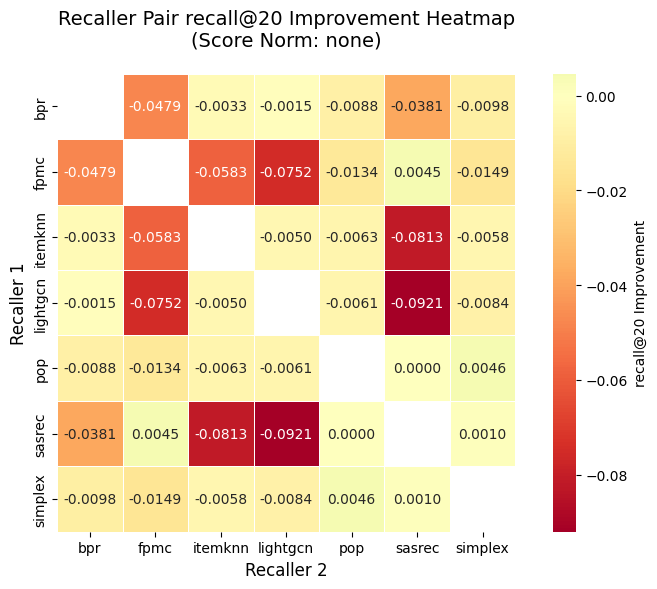

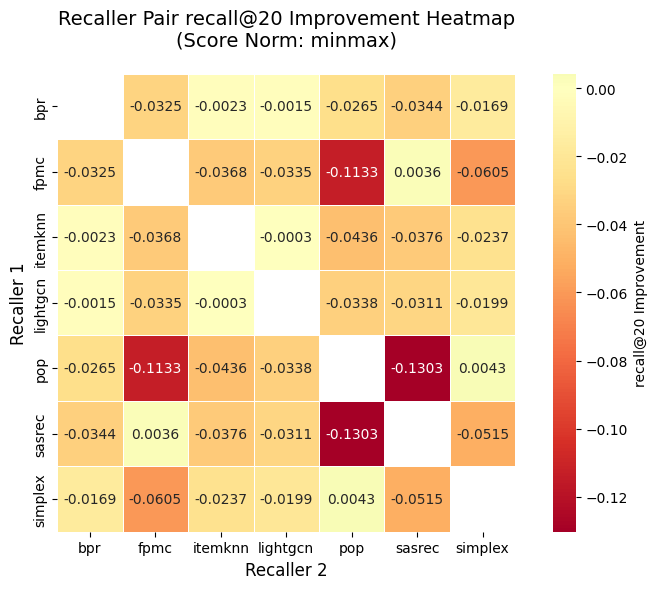

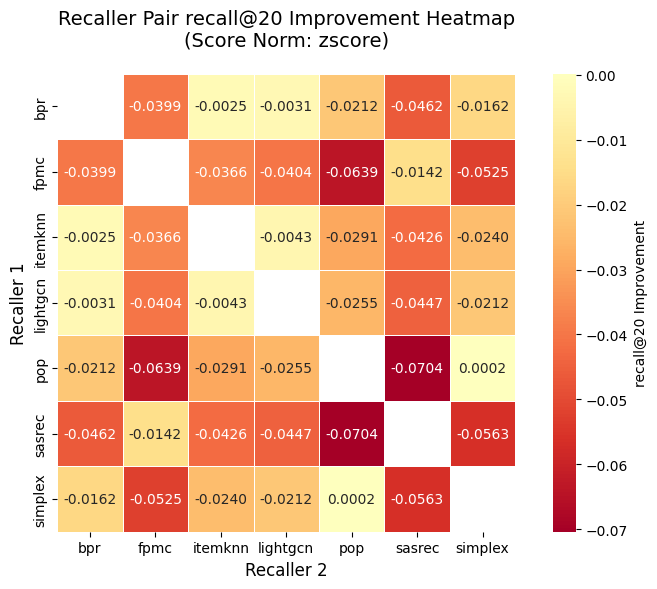

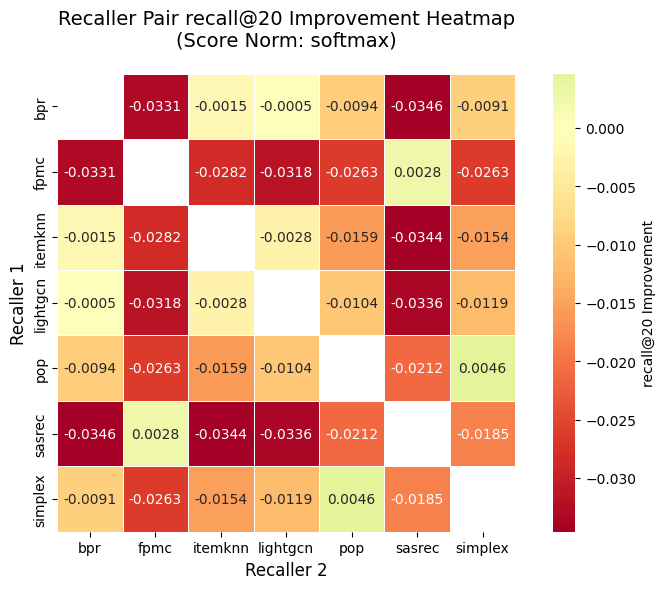

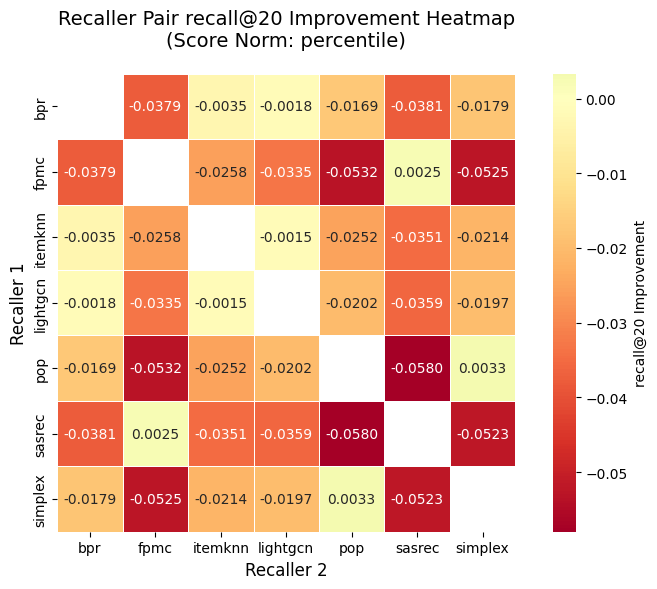

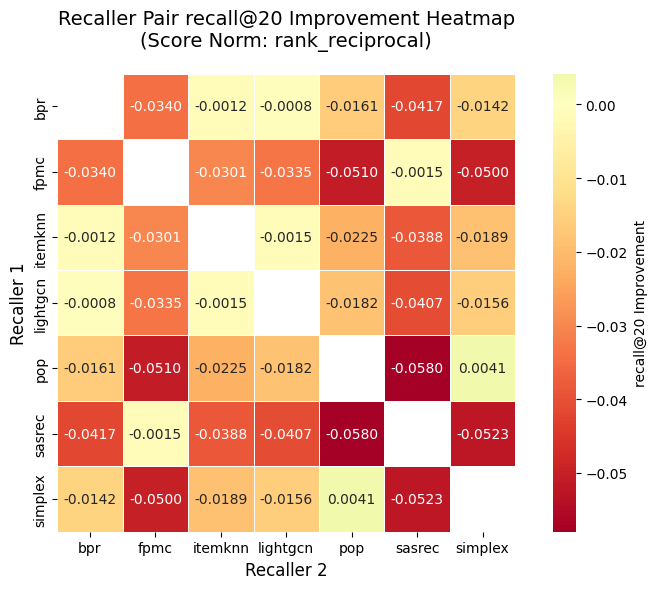

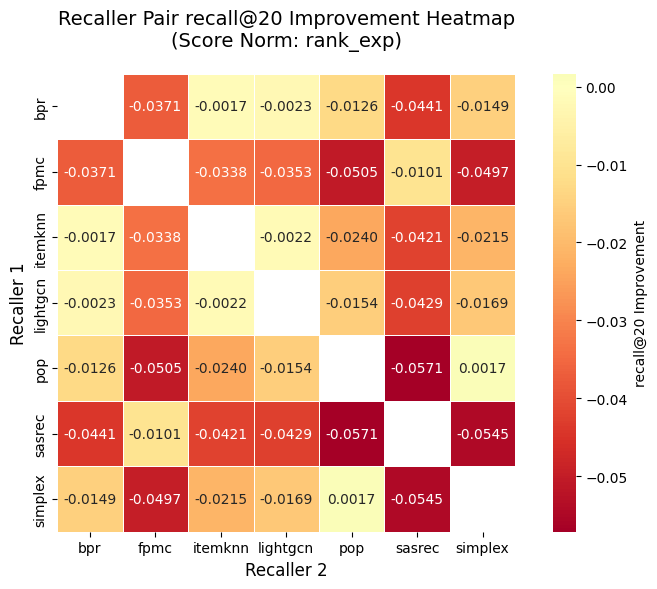

In [2]:
# 使用示例
prediction_file = "results/baseline_predictions_ml-1m_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json"
results = evaluate_score_norms(prediction_file, ks=[10, 20, 50], test_pairs=True)

Loading predictions from: results/baseline_predictions_steam_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json
Loaded 19603 predictions
Available recallers: ['bpr', 'fpmc', 'itemknn', 'lightgcn', 'pop', 'sasrec', 'simplex']

Testing 21 pairs of recallers

################################################################################
Combo 1/21: bpr_fpmc
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0821, Recall@20: 0.1900
      NDCG@50: 0.1017, Recall@50: 0.2885
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0016, Recall@10: +0.0021
      NDCG@20: +0.0015, Recall@20: +0.0021
      NDCG@50: -0.0033, Recall@50: -0.0253

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1254
      NDCG@20: 0.0819, Recall@20: 0.1899
      NDCG@50: 0.1043, Recall@50: 0.3043
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0015, Recall@10: +0.0023
      NDCG@20: +0.0013, Recall@20: +0.0021
      NDCG@50: -0.0007, Recall@50: -0.0095

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1254
      NDCG@20: 0.0819, Recall@20: 0.1898
      NDCG@50: 0.1045, Recall@50: 0.3057
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0015, Recall@10: +0.0023
      NDCG@20: +0.0013, Recall@20: +0.0020
      NDCG@50: -0.0005, Recall@50: -0.0081

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0660, Recall@10: 0.1255
      NDCG@20: 0.0820, Recall@20: 0.1899
      NDCG@50: 0.1063, Recall@50: 0.3149
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0017, Recall@10: +0.0024
      NDCG@20: +0.0015, Recall@20: +0.0020
      NDCG@50: +0.0013, Recall@50: +0.0011

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0655, Recall@10: 0.1249
      NDCG@20: 0.0816, Recall@20: 0.1890
      NDCG@50: 0.1029, Recall@50: 0.2970
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0013, Recall@10: +0.0018
      NDCG@20: +0.0010, Recall@20: +0.0011
      NDCG@50: -0.0021, Recall@50: -0.0168

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0654, Recall@10: 0.1246
      NDCG@20: 0.0817, Recall@20: 0.1893
      NDCG@50: 0.1029, Recall@50: 0.2971
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0012, Recall@10: +0.0015
      NDCG@20: +0.0011, Recall@20: +0.0015
      NDCG@50: -0.0021, Recall@50: -0.0167

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0656, Recall@10: 0.1254
      NDCG@20: 0.0821, Recall@20: 0.1915
      NDCG@50: 0.1027, Recall@50: 0.2961
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0013, Recall@10: +0.0023
      NDCG@20: +0.0016, Recall@20: +0.0037
      NDCG@50: -0.0023, Recall@50: -0.0177

################################################################################
Combo 2/21: bpr_itemknn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0176, Recall@10: 0.0429
      NDCG@20: 0.0353, Recall@20: 0.1135
      NDCG@50: 0.0734, Recall@50: 0.3104
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0467, Recall@10: -0.0802
      NDCG@20: -0.0453, Recall@20: -0.0743
      NDCG@50: -0.0316, Recall@50: -0.0035

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0238, Recall@10: 0.0559
      NDCG@20: 0.0509, Recall@20: 0.1648
      NDCG@50: 0.0807, Recall@50: 0.3133
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0405, Recall@10: -0.0672
      NDCG@20: -0.0296, Recall@20: -0.0231
      NDCG@50: -0.0244, Recall@50: -0.0006

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0301, Recall@10: 0.0703
      NDCG@20: 0.0603, Recall@20: 0.1904
      NDCG@50: 0.0842, Recall@50: 0.3109
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0342, Recall@10: -0.0527
      NDCG@20: -0.0203, Recall@20: +0.0026
      NDCG@50: -0.0208, Recall@50: -0.0030

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0179, Recall@10: 0.0446
      NDCG@20: 0.0359, Recall@20: 0.1165
      NDCG@50: 0.0743, Recall@50: 0.3143
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0463, Recall@10: -0.0785
      NDCG@20: -0.0447, Recall@20: -0.0713
      NDCG@50: -0.0307, Recall@50: +0.0005

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0208, Recall@10: 0.0511
      NDCG@20: 0.0369, Recall@20: 0.1156
      NDCG@50: 0.0763, Recall@50: 0.3118
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0434, Recall@10: -0.0720
      NDCG@20: -0.0436, Recall@20: -0.0722
      NDCG@50: -0.0287, Recall@50: -0.0020

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0442, Recall@10: 0.0980
      NDCG@20: 0.0619, Recall@20: 0.1684
      NDCG@50: 0.0900, Recall@50: 0.3112
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0200, Recall@10: -0.0251
      NDCG@20: -0.0187, Recall@20: -0.0194
      NDCG@50: -0.0150, Recall@50: -0.0026

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0512, Recall@10: 0.1147
      NDCG@20: 0.0715, Recall@20: 0.1962
      NDCG@50: 0.0945, Recall@50: 0.3121
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0131, Recall@10: -0.0084
      NDCG@20: -0.0090, Recall@20: +0.0084
      NDCG@50: -0.0105, Recall@50: -0.0017

################################################################################
Combo 3/21: bpr_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1243
      NDCG@20: 0.0857, Recall@20: 0.2063
      NDCG@50: 0.1072, Recall@50: 0.3128
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: +0.0003
      NDCG@20: -0.0001, Recall@20: -0.0001
      NDCG@50: -0.0001, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0650, Recall@10: 0.1239
      NDCG@20: 0.0814, Recall@20: 0.1894
      NDCG@50: 0.1064, Recall@50: 0.3143
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0002, Recall@10: -0.0001
      NDCG@20: -0.0044, Recall@20: -0.0170
      NDCG@50: -0.0009, Recall@50: +0.0015

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0650, Recall@10: 0.1239
      NDCG@20: 0.0815, Recall@20: 0.1897
      NDCG@50: 0.1064, Recall@50: 0.3148
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0002, Recall@10: -0.0002
      NDCG@20: -0.0043, Recall@20: -0.0167
      NDCG@50: -0.0009, Recall@50: +0.0020

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0824, Recall@20: 0.1924
      NDCG@50: 0.1067, Recall@50: 0.3142
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: -0.0001
      NDCG@20: -0.0034, Recall@20: -0.0140
      NDCG@50: -0.0006, Recall@50: +0.0014

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0649, Recall@10: 0.1239
      NDCG@20: 0.0811, Recall@20: 0.1882
      NDCG@50: 0.1062, Recall@50: 0.3146
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0003, Recall@10: -0.0001
      NDCG@20: -0.0047, Recall@20: -0.0182
      NDCG@50: -0.0011, Recall@50: +0.0018

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0650, Recall@10: 0.1242
      NDCG@20: 0.0815, Recall@20: 0.1902
      NDCG@50: 0.1065, Recall@50: 0.3145
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0002, Recall@10: +0.0002
      NDCG@20: -0.0043, Recall@20: -0.0162
      NDCG@50: -0.0008, Recall@50: +0.0017

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1244
      NDCG@20: 0.0844, Recall@20: 0.2021
      NDCG@50: 0.1072, Recall@50: 0.3147
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: +0.0004
      NDCG@20: -0.0014, Recall@20: -0.0043
      NDCG@50: -0.0001, Recall@50: +0.0019

################################################################################
Combo 4/21: bpr_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0644, Recall@10: 0.1234
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.0947, Recall@50: 0.2595
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0003
      NDCG@20: +0.0001, Recall@20: -0.0001
      NDCG@50: -0.0103, Recall@50: -0.0544

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0805, Recall@20: 0.1873
      NDCG@50: 0.0950, Recall@50: 0.2616
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: +0.0001
      NDCG@20: -0.0001, Recall@20: -0.0005
      NDCG@50: -0.0101, Recall@50: -0.0522

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0804, Recall@20: 0.1873
      NDCG@50: 0.0962, Recall@50: 0.2694
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: +0.0000
      NDCG@20: -0.0001, Recall@20: -0.0006
      NDCG@50: -0.0088, Recall@50: -0.0444

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0805, Recall@20: 0.1873
      NDCG@50: 0.0918, Recall@50: 0.2439
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: +0.0001
      NDCG@20: -0.0001, Recall@20: -0.0005
      NDCG@50: -0.0132, Recall@50: -0.0699

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0804, Recall@20: 0.1872
      NDCG@50: 0.0939, Recall@50: 0.2561
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: +0.0001
      NDCG@20: -0.0002, Recall@20: -0.0007
      NDCG@50: -0.0111, Recall@50: -0.0577

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0477, Recall@10: 0.0999
      NDCG@20: 0.0675, Recall@20: 0.1785
      NDCG@50: 0.0854, Recall@50: 0.2700
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0166, Recall@10: -0.0232
      NDCG@20: -0.0131, Recall@20: -0.0093
      NDCG@50: -0.0197, Recall@50: -0.0439

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0462, Recall@10: 0.0971
      NDCG@20: 0.0640, Recall@20: 0.1672
      NDCG@50: 0.0852, Recall@50: 0.2735
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0181, Recall@10: -0.0260
      NDCG@20: -0.0166, Recall@20: -0.0206
      NDCG@50: -0.0199, Recall@50: -0.0403

################################################################################
Combo 5/21: bpr_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0839, Recall@10: 0.1557
      NDCG@20: 0.0997, Recall@20: 0.2185
      NDCG@50: 0.1222, Recall@50: 0.3323
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0004
      NDCG@20: +0.0004, Recall@20: +0.0018
      NDCG@50: +0.0001, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0763, Recall@10: 0.1517
      NDCG@20: 0.0929, Recall@20: 0.2176
      NDCG@50: 0.1148, Recall@50: 0.3282
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0075, Recall@10: -0.0037
      NDCG@20: -0.0064, Recall@20: +0.0009
      NDCG@50: -0.0073, Recall@50: -0.0042

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0769, Recall@10: 0.1516
      NDCG@20: 0.0929, Recall@20: 0.2148
      NDCG@50: 0.1137, Recall@50: 0.3208
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0069, Recall@10: -0.0038
      NDCG@20: -0.0064, Recall@20: -0.0019
      NDCG@50: -0.0083, Recall@50: -0.0115

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0842, Recall@10: 0.1562
      NDCG@20: 0.0998, Recall@20: 0.2183
      NDCG@50: 0.1209, Recall@50: 0.3250
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: +0.0004, Recall@10: +0.0009
      NDCG@20: +0.0006, Recall@20: +0.0016
      NDCG@50: -0.0012, Recall@50: -0.0073

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0708, Recall@10: 0.1392
      NDCG@20: 0.0902, Recall@20: 0.2163
      NDCG@50: 0.1126, Recall@50: 0.3295
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0130, Recall@10: -0.0161
      NDCG@20: -0.0091, Recall@20: -0.0004
      NDCG@50: -0.0095, Recall@50: -0.0028

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0795, Recall@10: 0.1531
      NDCG@20: 0.0956, Recall@20: 0.2172
      NDCG@50: 0.1180, Recall@50: 0.3304
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0044, Recall@10: -0.0022
      NDCG@20: -0.0037, Recall@20: +0.0005
      NDCG@50: -0.0040, Recall@50: -0.0019

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0789, Recall@10: 0.1513
      NDCG@20: 0.0955, Recall@20: 0.2172
      NDCG@50: 0.1175, Recall@50: 0.3287
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0049, Recall@10: -0.0041
      NDCG@20: -0.0038, Recall@20: +0.0005
      NDCG@50: -0.0046, Recall@50: -0.0036

################################################################################
Combo 6/21: bpr_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1229
      NDCG@20: 0.0800, Recall@20: 0.1853
      NDCG@50: 0.0961, Recall@50: 0.2666
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: +0.0000, Recall@10: -0.0002
      NDCG@20: -0.0006, Recall@20: -0.0026
      NDCG@50: -0.0090, Recall@50: -0.0472

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0625, Recall@10: 0.1189
      NDCG@20: 0.0784, Recall@20: 0.1817
      NDCG@50: 0.0971, Recall@50: 0.2769
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0017, Recall@10: -0.0042
      NDCG@20: -0.0022, Recall@20: -0.0061
      NDCG@50: -0.0079, Recall@50: -0.0369

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0619, Recall@10: 0.1177
      NDCG@20: 0.0773, Recall@20: 0.1790
      NDCG@50: 0.0992, Recall@50: 0.2912
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0024, Recall@10: -0.0054
      NDCG@20: -0.0032, Recall@20: -0.0089
      NDCG@50: -0.0059, Recall@50: -0.0226

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0642, Recall@10: 0.1226
      NDCG@20: 0.0799, Recall@20: 0.1851
      NDCG@50: 0.0944, Recall@50: 0.2570
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0005
      NDCG@20: -0.0007, Recall@20: -0.0028
      NDCG@50: -0.0106, Recall@50: -0.0569

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0629, Recall@10: 0.1199
      NDCG@20: 0.0787, Recall@20: 0.1825
      NDCG@50: 0.0974, Recall@50: 0.2779
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0013, Recall@10: -0.0032
      NDCG@20: -0.0019, Recall@20: -0.0054
      NDCG@50: -0.0076, Recall@50: -0.0360

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0617, Recall@10: 0.1180
      NDCG@20: 0.0776, Recall@20: 0.1812
      NDCG@50: 0.0964, Recall@50: 0.2769
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0025, Recall@10: -0.0051
      NDCG@20: -0.0030, Recall@20: -0.0066
      NDCG@50: -0.0086, Recall@50: -0.0369

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0613, Recall@10: 0.1172
      NDCG@20: 0.0768, Recall@20: 0.1789
      NDCG@50: 0.0963, Recall@50: 0.2780
    Best Individual Recaller: bpr
    Best Individual Metrics:
      NDCG@10: 0.0643, Recall@10: 0.1231
      NDCG@20: 0.0806, Recall@20: 0.1878
      NDCG@50: 0.1050, Recall@50: 0.3138
    Improvement over Best Individual:
      NDCG@10: -0.0030, Recall@10: -0.0059
      NDCG@20: -0.0038, Recall@20: -0.0090
      NDCG@50: -0.0087, Recall@50: -0.0359

################################################################################
Combo 7/21: fpmc_itemknn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0428, Recall@10: 0.0900
      NDCG@20: 0.0644, Recall@20: 0.1767
      NDCG@50: 0.0868, Recall@50: 0.2902
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0231, Recall@10: -0.0351
      NDCG@20: -0.0178, Recall@20: -0.0140
      NDCG@50: -0.0148, Recall@50: +0.0018

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0276, Recall@10: 0.0658
      NDCG@20: 0.0542, Recall@20: 0.1728
      NDCG@50: 0.0812, Recall@50: 0.3081
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0383, Recall@10: -0.0594
      NDCG@20: -0.0280, Recall@20: -0.0179
      NDCG@50: -0.0204, Recall@50: +0.0197

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0346, Recall@10: 0.0821
      NDCG@20: 0.0629, Recall@20: 0.1949
      NDCG@50: 0.0859, Recall@50: 0.3101
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0313, Recall@10: -0.0431
      NDCG@20: -0.0193, Recall@20: +0.0042
      NDCG@50: -0.0157, Recall@50: +0.0217

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0462, Recall@10: 0.0881
      NDCG@20: 0.0616, Recall@20: 0.1498
      NDCG@50: 0.0877, Recall@50: 0.2824
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0197, Recall@10: -0.0370
      NDCG@20: -0.0207, Recall@20: -0.0409
      NDCG@50: -0.0139, Recall@50: -0.0060

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0212, Recall@10: 0.0516
      NDCG@20: 0.0374, Recall@20: 0.1167
      NDCG@50: 0.0760, Recall@50: 0.3070
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0447, Recall@10: -0.0736
      NDCG@20: -0.0448, Recall@20: -0.0740
      NDCG@50: -0.0256, Recall@50: +0.0187

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0450, Recall@10: 0.0988
      NDCG@20: 0.0624, Recall@20: 0.1685
      NDCG@50: 0.0896, Recall@50: 0.3061
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0209, Recall@10: -0.0264
      NDCG@20: -0.0198, Recall@20: -0.0221
      NDCG@50: -0.0120, Recall@50: +0.0177

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0514, Recall@10: 0.1142
      NDCG@20: 0.0709, Recall@20: 0.1920
      NDCG@50: 0.0940, Recall@50: 0.3076
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0144, Recall@10: -0.0110
      NDCG@20: -0.0113, Recall@20: +0.0013
      NDCG@50: -0.0076, Recall@50: +0.0192

################################################################################
Combo 8/21: fpmc_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1258
      NDCG@20: 0.0835, Recall@20: 0.1959
      NDCG@50: 0.1065, Recall@50: 0.3133
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0007, Recall@10: +0.0018
      NDCG@20: -0.0023, Recall@20: -0.0105
      NDCG@50: -0.0008, Recall@50: +0.0005

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0664, Recall@10: 0.1265
      NDCG@20: 0.0832, Recall@20: 0.1936
      NDCG@50: 0.1078, Recall@50: 0.3171
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0012, Recall@10: +0.0025
      NDCG@20: -0.0026, Recall@20: -0.0128
      NDCG@50: +0.0005, Recall@50: +0.0043

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0663, Recall@10: 0.1264
      NDCG@20: 0.0868, Recall@20: 0.2094
      NDCG@50: 0.1072, Recall@50: 0.3120
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0011, Recall@10: +0.0023
      NDCG@20: +0.0010, Recall@20: +0.0030
      NDCG@50: -0.0001, Recall@50: -0.0008

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0662, Recall@10: 0.1266
      NDCG@20: 0.0827, Recall@20: 0.1927
      NDCG@50: 0.1022, Recall@50: 0.2907
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0010, Recall@10: +0.0026
      NDCG@20: -0.0031, Recall@20: -0.0137
      NDCG@50: -0.0051, Recall@50: -0.0221

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0663, Recall@10: 0.1259
      NDCG@20: 0.0829, Recall@20: 0.1923
      NDCG@50: 0.1078, Recall@50: 0.3175
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0011, Recall@10: +0.0019
      NDCG@20: -0.0029, Recall@20: -0.0141
      NDCG@50: +0.0005, Recall@50: +0.0047

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0661, Recall@10: 0.1249
      NDCG@20: 0.0832, Recall@20: 0.1932
      NDCG@50: 0.1075, Recall@50: 0.3165
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0009, Recall@10: +0.0009
      NDCG@20: -0.0026, Recall@20: -0.0132
      NDCG@50: +0.0002, Recall@50: +0.0037

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0661, Recall@10: 0.1251
      NDCG@20: 0.0848, Recall@20: 0.2001
      NDCG@50: 0.1086, Recall@50: 0.3176
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0009, Recall@10: +0.0011
      NDCG@20: -0.0010, Recall@20: -0.0063
      NDCG@50: +0.0013, Recall@50: +0.0048

################################################################################
Combo 9/21: fpmc_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1249
      NDCG@20: 0.0811, Recall@20: 0.1862
      NDCG@50: 0.1011, Recall@50: 0.2886
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0003
      NDCG@20: -0.0011, Recall@20: -0.0045
      NDCG@50: -0.0005, Recall@50: +0.0002

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1249
      NDCG@20: 0.0812, Recall@20: 0.1862
      NDCG@50: 0.0952, Recall@50: 0.2579
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0003
      NDCG@20: -0.0011, Recall@20: -0.0044
      NDCG@50: -0.0063, Recall@50: -0.0305

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1250
      NDCG@20: 0.0803, Recall@20: 0.1824
      NDCG@50: 0.0955, Recall@50: 0.2619
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0000, Recall@10: -0.0002
      NDCG@20: -0.0019, Recall@20: -0.0083
      NDCG@50: -0.0061, Recall@50: -0.0264

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1249
      NDCG@20: 0.0811, Recall@20: 0.1862
      NDCG@50: 0.0932, Recall@50: 0.2458
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0003
      NDCG@20: -0.0011, Recall@20: -0.0045
      NDCG@50: -0.0084, Recall@50: -0.0426

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0658, Recall@10: 0.1249
      NDCG@20: 0.0811, Recall@20: 0.1861
      NDCG@50: 0.0950, Recall@50: 0.2555
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0003
      NDCG@20: -0.0011, Recall@20: -0.0045
      NDCG@50: -0.0066, Recall@50: -0.0329

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0499, Recall@10: 0.1027
      NDCG@20: 0.0682, Recall@20: 0.1754
      NDCG@50: 0.0877, Recall@50: 0.2740
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0160, Recall@10: -0.0224
      NDCG@20: -0.0140, Recall@20: -0.0153
      NDCG@50: -0.0139, Recall@50: -0.0144

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0481, Recall@10: 0.0984
      NDCG@20: 0.0663, Recall@20: 0.1700
      NDCG@50: 0.0874, Recall@50: 0.2749
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0177, Recall@10: -0.0268
      NDCG@20: -0.0159, Recall@20: -0.0207
      NDCG@50: -0.0142, Recall@50: -0.0135

################################################################################
Combo 10/21: fpmc_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0767, Recall@10: 0.1464
      NDCG@20: 0.0912, Recall@20: 0.2041
      NDCG@50: 0.1133, Recall@50: 0.3153
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0071, Recall@10: -0.0089
      NDCG@20: -0.0080, Recall@20: -0.0127
      NDCG@50: -0.0088, Recall@50: -0.0170

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0768, Recall@10: 0.1513
      NDCG@20: 0.0932, Recall@20: 0.2167
      NDCG@50: 0.1158, Recall@50: 0.3309
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0070, Recall@10: -0.0040
      NDCG@20: -0.0061, Recall@20: +0.0000
      NDCG@50: -0.0063, Recall@50: -0.0014

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0791, Recall@10: 0.1541
      NDCG@20: 0.0949, Recall@20: 0.2169
      NDCG@50: 0.1159, Recall@50: 0.3234
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0047, Recall@10: -0.0013
      NDCG@20: -0.0044, Recall@20: +0.0002
      NDCG@50: -0.0061, Recall@50: -0.0089

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0822, Recall@10: 0.1535
      NDCG@20: 0.0975, Recall@20: 0.2144
      NDCG@50: 0.1198, Recall@50: 0.3276
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0016, Recall@10: -0.0018
      NDCG@20: -0.0018, Recall@20: -0.0023
      NDCG@50: -0.0022, Recall@50: -0.0048

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0715, Recall@10: 0.1396
      NDCG@20: 0.0902, Recall@20: 0.2144
      NDCG@50: 0.1131, Recall@50: 0.3305
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0123, Recall@10: -0.0158
      NDCG@20: -0.0091, Recall@20: -0.0023
      NDCG@50: -0.0089, Recall@50: -0.0019

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0798, Recall@10: 0.1529
      NDCG@20: 0.0956, Recall@20: 0.2157
      NDCG@50: 0.1182, Recall@50: 0.3302
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0040, Recall@10: -0.0024
      NDCG@20: -0.0036, Recall@20: -0.0010
      NDCG@50: -0.0039, Recall@50: -0.0022

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0798, Recall@10: 0.1528
      NDCG@20: 0.0953, Recall@20: 0.2146
      NDCG@50: 0.1181, Recall@50: 0.3295
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0040, Recall@10: -0.0026
      NDCG@20: -0.0039, Recall@20: -0.0021
      NDCG@50: -0.0040, Recall@50: -0.0028

################################################################################
Combo 11/21: fpmc_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0656, Recall@10: 0.1242
      NDCG@20: 0.0814, Recall@20: 0.1871
      NDCG@50: 0.1013, Recall@50: 0.2884
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0002, Recall@10: -0.0010
      NDCG@20: -0.0008, Recall@20: -0.0036
      NDCG@50: -0.0003, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0640, Recall@10: 0.1212
      NDCG@20: 0.0791, Recall@20: 0.1814
      NDCG@50: 0.0977, Recall@50: 0.2759
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0019, Recall@10: -0.0040
      NDCG@20: -0.0031, Recall@20: -0.0093
      NDCG@50: -0.0039, Recall@50: -0.0125

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0635, Recall@10: 0.1206
      NDCG@20: 0.0781, Recall@20: 0.1784
      NDCG@50: 0.0974, Recall@50: 0.2762
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0024, Recall@10: -0.0046
      NDCG@20: -0.0042, Recall@20: -0.0122
      NDCG@50: -0.0042, Recall@50: -0.0122

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0657, Recall@10: 0.1244
      NDCG@20: 0.0814, Recall@20: 0.1872
      NDCG@50: 0.0955, Recall@50: 0.2577
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0002, Recall@10: -0.0008
      NDCG@20: -0.0008, Recall@20: -0.0035
      NDCG@50: -0.0061, Recall@50: -0.0307

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0634, Recall@10: 0.1210
      NDCG@20: 0.0789, Recall@20: 0.1824
      NDCG@50: 0.0982, Recall@50: 0.2806
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0024, Recall@10: -0.0042
      NDCG@20: -0.0034, Recall@20: -0.0083
      NDCG@50: -0.0034, Recall@50: -0.0078

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0626, Recall@10: 0.1196
      NDCG@20: 0.0782, Recall@20: 0.1817
      NDCG@50: 0.0976, Recall@50: 0.2801
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0033, Recall@10: -0.0056
      NDCG@20: -0.0040, Recall@20: -0.0090
      NDCG@50: -0.0040, Recall@50: -0.0083

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0620, Recall@10: 0.1178
      NDCG@20: 0.0778, Recall@20: 0.1805
      NDCG@50: 0.0976, Recall@50: 0.2805
    Best Individual Recaller: fpmc
    Best Individual Metrics:
      NDCG@10: 0.0659, Recall@10: 0.1252
      NDCG@20: 0.0822, Recall@20: 0.1907
      NDCG@50: 0.1016, Recall@50: 0.2884
    Improvement over Best Individual:
      NDCG@10: -0.0039, Recall@10: -0.0074
      NDCG@20: -0.0044, Recall@20: -0.0102
      NDCG@50: -0.0040, Recall@50: -0.0079

################################################################################
Combo 12/21: itemknn_lightgcn
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0597, Recall@10: 0.1123
      NDCG@20: 0.0821, Recall@20: 0.2023
      NDCG@50: 0.1042, Recall@50: 0.3129
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0055, Recall@10: -0.0117
      NDCG@20: -0.0037, Recall@20: -0.0041
      NDCG@50: -0.0031, Recall@50: +0.0001

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0311, Recall@10: 0.0681
      NDCG@20: 0.0556, Recall@20: 0.1664
      NDCG@50: 0.0859, Recall@50: 0.3179
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0341, Recall@10: -0.0559
      NDCG@20: -0.0302, Recall@20: -0.0400
      NDCG@50: -0.0214, Recall@50: +0.0051

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0388, Recall@10: 0.0849
      NDCG@20: 0.0688, Recall@20: 0.2050
      NDCG@50: 0.0929, Recall@50: 0.3252
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0263, Recall@10: -0.0391
      NDCG@20: -0.0170, Recall@20: -0.0014
      NDCG@50: -0.0145, Recall@50: +0.0123

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0534, Recall@10: 0.0952
      NDCG@20: 0.0693, Recall@20: 0.1588
      NDCG@50: 0.0862, Recall@50: 0.2439
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0118, Recall@10: -0.0288
      NDCG@20: -0.0164, Recall@20: -0.0476
      NDCG@50: -0.0211, Recall@50: -0.0689

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0206, Recall@10: 0.0512
      NDCG@20: 0.0401, Recall@20: 0.1292
      NDCG@50: 0.0785, Recall@50: 0.3198
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0445, Recall@10: -0.0728
      NDCG@20: -0.0457, Recall@20: -0.0772
      NDCG@50: -0.0288, Recall@50: +0.0070

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0449, Recall@10: 0.0992
      NDCG@20: 0.0648, Recall@20: 0.1784
      NDCG@50: 0.0925, Recall@50: 0.3193
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0202, Recall@10: -0.0248
      NDCG@20: -0.0210, Recall@20: -0.0280
      NDCG@50: -0.0148, Recall@50: +0.0065

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0518, Recall@10: 0.1144
      NDCG@20: 0.0730, Recall@20: 0.1992
      NDCG@50: 0.0973, Recall@50: 0.3207
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0133, Recall@10: -0.0096
      NDCG@20: -0.0128, Recall@20: -0.0072
      NDCG@50: -0.0100, Recall@50: +0.0079

################################################################################
Combo 13/21: itemknn_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0119, Recall@10: 0.0303
      NDCG@20: 0.0250, Recall@20: 0.0831
      NDCG@50: 0.0605, Recall@50: 0.2628
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0193, Recall@10: -0.0509
      NDCG@20: -0.0281, Recall@20: -0.0859
      NDCG@50: -0.0076, Recall@50: +0.0191

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0142, Recall@10: 0.0338
      NDCG@20: 0.0275, Recall@20: 0.0872
      NDCG@50: 0.0599, Recall@50: 0.2510
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0169, Recall@10: -0.0474
      NDCG@20: -0.0255, Recall@20: -0.0817
      NDCG@50: -0.0082, Recall@50: +0.0072

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0171, Recall@10: 0.0382
      NDCG@20: 0.0338, Recall@20: 0.1060
      NDCG@50: 0.0666, Recall@50: 0.2703
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0141, Recall@10: -0.0430
      NDCG@20: -0.0193, Recall@20: -0.0629
      NDCG@50: -0.0014, Recall@50: +0.0265

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0136, Recall@10: 0.0339
      NDCG@20: 0.0269, Recall@20: 0.0873
      NDCG@50: 0.0617, Recall@50: 0.2643
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0175, Recall@10: -0.0472
      NDCG@20: -0.0261, Recall@20: -0.0816
      NDCG@50: -0.0063, Recall@50: +0.0206

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0138, Recall@10: 0.0342
      NDCG@20: 0.0276, Recall@20: 0.0897
      NDCG@50: 0.0638, Recall@50: 0.2738
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0173, Recall@10: -0.0470
      NDCG@20: -0.0254, Recall@20: -0.0792
      NDCG@50: -0.0042, Recall@50: +0.0300

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0184, Recall@10: 0.0442
      NDCG@20: 0.0387, Recall@20: 0.1256
      NDCG@50: 0.0702, Recall@50: 0.2833
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0127, Recall@10: -0.0370
      NDCG@20: -0.0143, Recall@20: -0.0434
      NDCG@50: +0.0021, Recall@50: +0.0395

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0207, Recall@10: 0.0518
      NDCG@20: 0.0414, Recall@20: 0.1345
      NDCG@50: 0.0719, Recall@50: 0.2845
    Best Individual Recaller: pop
    Best Individual Metrics:
      NDCG@10: 0.0312, Recall@10: 0.0812
      NDCG@20: 0.0530, Recall@20: 0.1690
      NDCG@50: 0.0681, Recall@50: 0.2437
    Improvement over Best Individual:
      NDCG@10: -0.0105, Recall@10: -0.0293
      NDCG@20: -0.0116, Recall@20: -0.0344
      NDCG@50: +0.0038, Recall@50: +0.0408

################################################################################
Combo 14/21: itemknn_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0635, Recall@10: 0.1355
      NDCG@20: 0.0812, Recall@20: 0.2059
      NDCG@50: 0.1061, Recall@50: 0.3324
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0203, Recall@10: -0.0198
      NDCG@20: -0.0181, Recall@20: -0.0108
      NDCG@50: -0.0160, Recall@50: +0.0001

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0405, Recall@10: 0.1002
      NDCG@20: 0.0643, Recall@20: 0.1951
      NDCG@50: 0.0903, Recall@50: 0.3261
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0433, Recall@10: -0.0551
      NDCG@20: -0.0350, Recall@20: -0.0216
      NDCG@50: -0.0317, Recall@50: -0.0062

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0488, Recall@10: 0.1187
      NDCG@20: 0.0709, Recall@20: 0.2062
      NDCG@50: 0.0933, Recall@50: 0.3194
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0350, Recall@10: -0.0367
      NDCG@20: -0.0283, Recall@20: -0.0105
      NDCG@50: -0.0287, Recall@50: -0.0129

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0654, Recall@10: 0.1271
      NDCG@20: 0.0804, Recall@20: 0.1867
      NDCG@50: 0.1017, Recall@50: 0.2942
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0184, Recall@10: -0.0283
      NDCG@20: -0.0189, Recall@20: -0.0300
      NDCG@50: -0.0203, Recall@50: -0.0381

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0294, Recall@10: 0.0738
      NDCG@20: 0.0514, Recall@20: 0.1624
      NDCG@50: 0.0836, Recall@50: 0.3225
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0544, Recall@10: -0.0816
      NDCG@20: -0.0479, Recall@20: -0.0543
      NDCG@50: -0.0384, Recall@50: -0.0098

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0553, Recall@10: 0.1201
      NDCG@20: 0.0734, Recall@20: 0.1921
      NDCG@50: 0.0991, Recall@50: 0.3226
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0285, Recall@10: -0.0352
      NDCG@20: -0.0259, Recall@20: -0.0246
      NDCG@50: -0.0229, Recall@50: -0.0097

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0595, Recall@10: 0.1297
      NDCG@20: 0.0778, Recall@20: 0.2019
      NDCG@50: 0.1017, Recall@50: 0.3227
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0243, Recall@10: -0.0257
      NDCG@20: -0.0214, Recall@20: -0.0148
      NDCG@50: -0.0204, Recall@50: -0.0096

################################################################################
Combo 15/21: itemknn_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0121, Recall@10: 0.0311
      NDCG@20: 0.0258, Recall@20: 0.0862
      NDCG@50: 0.0622, Recall@50: 0.2698
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0418, Recall@10: -0.0736
      NDCG@20: -0.0430, Recall@20: -0.0774
      NDCG@50: -0.0244, Recall@50: +0.0165

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0248, Recall@10: 0.0586
      NDCG@20: 0.0459, Recall@20: 0.1428
      NDCG@50: 0.0732, Recall@50: 0.2791
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0291, Recall@10: -0.0461
      NDCG@20: -0.0229, Recall@20: -0.0208
      NDCG@50: -0.0134, Recall@50: +0.0258

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0297, Recall@10: 0.0707
      NDCG@20: 0.0529, Recall@20: 0.1628
      NDCG@50: 0.0764, Recall@50: 0.2807
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0242, Recall@10: -0.0340
      NDCG@20: -0.0159, Recall@20: -0.0008
      NDCG@50: -0.0102, Recall@50: +0.0273

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0139, Recall@10: 0.0349
      NDCG@20: 0.0278, Recall@20: 0.0908
      NDCG@50: 0.0632, Recall@50: 0.2701
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0400, Recall@10: -0.0698
      NDCG@20: -0.0410, Recall@20: -0.0728
      NDCG@50: -0.0234, Recall@50: +0.0168

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0219, Recall@10: 0.0523
      NDCG@20: 0.0380, Recall@20: 0.1170
      NDCG@50: 0.0709, Recall@50: 0.2809
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0320, Recall@10: -0.0523
      NDCG@20: -0.0308, Recall@20: -0.0466
      NDCG@50: -0.0157, Recall@50: +0.0275

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0372, Recall@10: 0.0799
      NDCG@20: 0.0534, Recall@20: 0.1449
      NDCG@50: 0.0802, Recall@50: 0.2801
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0167, Recall@10: -0.0247
      NDCG@20: -0.0154, Recall@20: -0.0187
      NDCG@50: -0.0064, Recall@50: +0.0268

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0405, Recall@10: 0.0882
      NDCG@20: 0.0582, Recall@20: 0.1593
      NDCG@50: 0.0824, Recall@50: 0.2811
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0134, Recall@10: -0.0165
      NDCG@20: -0.0106, Recall@20: -0.0044
      NDCG@50: -0.0042, Recall@50: +0.0278

################################################################################
Combo 16/21: lightgcn_pop
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1238
      NDCG@20: 0.0819, Recall@20: 0.1900
      NDCG@50: 0.1060, Recall@50: 0.3128
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0039, Recall@20: -0.0164
      NDCG@50: -0.0013, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1238
      NDCG@20: 0.0811, Recall@20: 0.1866
      NDCG@50: 0.1009, Recall@50: 0.2900
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0047, Recall@20: -0.0198
      NDCG@50: -0.0064, Recall@50: -0.0228

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1238
      NDCG@20: 0.0805, Recall@20: 0.1840
      NDCG@50: 0.1021, Recall@50: 0.2955
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0053, Recall@20: -0.0224
      NDCG@50: -0.0052, Recall@50: -0.0173

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1238
      NDCG@20: 0.0811, Recall@20: 0.1867
      NDCG@50: 0.0926, Recall@50: 0.2438
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0047, Recall@20: -0.0197
      NDCG@50: -0.0147, Recall@50: -0.0690

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0651, Recall@10: 0.1238
      NDCG@20: 0.0811, Recall@20: 0.1866
      NDCG@50: 0.1008, Recall@50: 0.2863
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0001, Recall@10: -0.0002
      NDCG@20: -0.0047, Recall@20: -0.0198
      NDCG@50: -0.0066, Recall@50: -0.0265

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0488, Recall@10: 0.1026
      NDCG@20: 0.0682, Recall@20: 0.1801
      NDCG@50: 0.0925, Recall@50: 0.3046
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0164, Recall@10: -0.0214
      NDCG@20: -0.0176, Recall@20: -0.0263
      NDCG@50: -0.0149, Recall@50: -0.0082

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0467, Recall@10: 0.0980
      NDCG@20: 0.0661, Recall@20: 0.1749
      NDCG@50: 0.0921, Recall@50: 0.3034
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0185, Recall@10: -0.0260
      NDCG@20: -0.0197, Recall@20: -0.0315
      NDCG@50: -0.0152, Recall@50: -0.0094

################################################################################
Combo 17/21: lightgcn_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0749, Recall@10: 0.1496
      NDCG@20: 0.0919, Recall@20: 0.2168
      NDCG@50: 0.1113, Recall@50: 0.3138
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0089, Recall@10: -0.0058
      NDCG@20: -0.0074, Recall@20: +0.0001
      NDCG@50: -0.0108, Recall@50: -0.0186

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0796, Recall@10: 0.1552
      NDCG@20: 0.0964, Recall@20: 0.2221
      NDCG@50: 0.1212, Recall@50: 0.3477
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0042, Recall@10: -0.0001
      NDCG@20: -0.0029, Recall@20: +0.0054
      NDCG@50: -0.0008, Recall@50: +0.0153

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0796, Recall@10: 0.1551
      NDCG@20: 0.0968, Recall@20: 0.2240
      NDCG@50: 0.1185, Recall@50: 0.3322
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0042, Recall@10: -0.0002
      NDCG@20: -0.0024, Recall@20: +0.0073
      NDCG@50: -0.0036, Recall@50: -0.0001

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0794, Recall@10: 0.1551
      NDCG@20: 0.0957, Recall@20: 0.2198
      NDCG@50: 0.1188, Recall@50: 0.3364
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0044, Recall@10: -0.0002
      NDCG@20: -0.0035, Recall@20: +0.0031
      NDCG@50: -0.0033, Recall@50: +0.0040

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0759, Recall@10: 0.1526
      NDCG@20: 0.0927, Recall@20: 0.2191
      NDCG@50: 0.1175, Recall@50: 0.3444
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0079, Recall@10: -0.0027
      NDCG@20: -0.0066, Recall@20: +0.0024
      NDCG@50: -0.0045, Recall@50: +0.0120

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0799, Recall@10: 0.1533
      NDCG@20: 0.0964, Recall@20: 0.2190
      NDCG@50: 0.1213, Recall@50: 0.3446
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0039, Recall@10: -0.0020
      NDCG@20: -0.0028, Recall@20: +0.0023
      NDCG@50: -0.0008, Recall@50: +0.0123

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0792, Recall@10: 0.1509
      NDCG@20: 0.0962, Recall@20: 0.2187
      NDCG@50: 0.1210, Recall@50: 0.3437
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0047, Recall@10: -0.0044
      NDCG@20: -0.0030, Recall@20: +0.0020
      NDCG@50: -0.0010, Recall@50: +0.0113

################################################################################
Combo 18/21: lightgcn_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0653, Recall@10: 0.1243
      NDCG@20: 0.0824, Recall@20: 0.1920
      NDCG@50: 0.1063, Recall@50: 0.3128
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0003
      NDCG@20: -0.0034, Recall@20: -0.0144
      NDCG@50: -0.0010, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0631, Recall@10: 0.1191
      NDCG@20: 0.0781, Recall@20: 0.1787
      NDCG@50: 0.1016, Recall@50: 0.2990
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0021, Recall@10: -0.0049
      NDCG@20: -0.0077, Recall@20: -0.0276
      NDCG@50: -0.0057, Recall@50: -0.0138

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0633, Recall@10: 0.1199
      NDCG@20: 0.0799, Recall@20: 0.1861
      NDCG@50: 0.1034, Recall@50: 0.3031
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0018, Recall@10: -0.0041
      NDCG@20: -0.0059, Recall@20: -0.0203
      NDCG@50: -0.0039, Recall@50: -0.0097

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0653, Recall@10: 0.1244
      NDCG@20: 0.0813, Recall@20: 0.1874
      NDCG@50: 0.0947, Recall@50: 0.2545
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0004
      NDCG@20: -0.0045, Recall@20: -0.0190
      NDCG@50: -0.0126, Recall@50: -0.0584

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0636, Recall@10: 0.1213
      NDCG@20: 0.0794, Recall@20: 0.1835
      NDCG@50: 0.1037, Recall@50: 0.3065
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0015, Recall@10: -0.0028
      NDCG@20: -0.0064, Recall@20: -0.0229
      NDCG@50: -0.0036, Recall@50: -0.0063

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0620, Recall@10: 0.1179
      NDCG@20: 0.0781, Recall@20: 0.1817
      NDCG@50: 0.1025, Recall@50: 0.3059
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0032, Recall@10: -0.0061
      NDCG@20: -0.0077, Recall@20: -0.0247
      NDCG@50: -0.0048, Recall@50: -0.0069

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0613, Recall@10: 0.1161
      NDCG@20: 0.0787, Recall@20: 0.1855
      NDCG@50: 0.1030, Recall@50: 0.3064
    Best Individual Recaller: lightgcn
    Best Individual Metrics:
      NDCG@10: 0.0652, Recall@10: 0.1240
      NDCG@20: 0.0858, Recall@20: 0.2064
      NDCG@50: 0.1073, Recall@50: 0.3128
    Improvement over Best Individual:
      NDCG@10: -0.0038, Recall@10: -0.0080
      NDCG@20: -0.0071, Recall@20: -0.0209
      NDCG@50: -0.0043, Recall@50: -0.0064

################################################################################
Combo 19/21: pop_sasrec
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0799, Recall@10: 0.1519
      NDCG@20: 0.0950, Recall@20: 0.2120
      NDCG@50: 0.1187, Recall@50: 0.3323
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0039, Recall@10: -0.0035
      NDCG@20: -0.0042, Recall@20: -0.0047
      NDCG@50: -0.0033, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0718, Recall@10: 0.1381
      NDCG@20: 0.0846, Recall@20: 0.1885
      NDCG@50: 0.1017, Recall@50: 0.2782
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0120, Recall@10: -0.0172
      NDCG@20: -0.0147, Recall@20: -0.0282
      NDCG@50: -0.0203, Recall@50: -0.0541

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0839, Recall@10: 0.1556
      NDCG@20: 0.0979, Recall@20: 0.2106
      NDCG@50: 0.1114, Recall@50: 0.2810
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: +0.0001, Recall@10: +0.0003
      NDCG@20: -0.0014, Recall@20: -0.0061
      NDCG@50: -0.0107, Recall@50: -0.0514

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0833, Recall@10: 0.1543
      NDCG@20: 0.0974, Recall@20: 0.2102
      NDCG@50: 0.1124, Recall@50: 0.2843
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0005, Recall@10: -0.0011
      NDCG@20: -0.0018, Recall@20: -0.0065
      NDCG@50: -0.0097, Recall@50: -0.0480

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0729, Recall@10: 0.1424
      NDCG@20: 0.0914, Recall@20: 0.2156
      NDCG@50: 0.1078, Recall@50: 0.2966
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0109, Recall@10: -0.0129
      NDCG@20: -0.0078, Recall@20: -0.0011
      NDCG@50: -0.0143, Recall@50: -0.0357

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0627, Recall@10: 0.1259
      NDCG@20: 0.0821, Recall@20: 0.2029
      NDCG@50: 0.1041, Recall@50: 0.3141
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0212, Recall@10: -0.0294
      NDCG@20: -0.0172, Recall@20: -0.0138
      NDCG@50: -0.0179, Recall@50: -0.0182

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0618, Recall@10: 0.1245
      NDCG@20: 0.0803, Recall@20: 0.1977
      NDCG@50: 0.1036, Recall@50: 0.3149
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0220, Recall@10: -0.0309
      NDCG@20: -0.0190, Recall@20: -0.0190
      NDCG@50: -0.0185, Recall@50: -0.0174

################################################################################
Combo 20/21: pop_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0559, Recall@10: 0.1089
      NDCG@20: 0.0710, Recall@20: 0.1689
      NDCG@50: 0.0864, Recall@50: 0.2457
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: +0.0019, Recall@10: +0.0042
      NDCG@20: +0.0022, Recall@20: +0.0053
      NDCG@50: -0.0002, Recall@50: -0.0077

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0555, Recall@10: 0.1082
      NDCG@20: 0.0704, Recall@20: 0.1674
      NDCG@50: 0.0863, Recall@50: 0.2470
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: +0.0016, Recall@10: +0.0036
      NDCG@20: +0.0016, Recall@20: +0.0037
      NDCG@50: -0.0003, Recall@50: -0.0064

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0542, Recall@10: 0.1053
      NDCG@20: 0.0690, Recall@20: 0.1641
      NDCG@50: 0.0843, Recall@50: 0.2422
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: +0.0003, Recall@10: +0.0007
      NDCG@20: +0.0002, Recall@20: +0.0004
      NDCG@50: -0.0023, Recall@50: -0.0112

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0559, Recall@10: 0.1089
      NDCG@20: 0.0710, Recall@20: 0.1687
      NDCG@50: 0.0866, Recall@50: 0.2468
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: +0.0019, Recall@10: +0.0042
      NDCG@20: +0.0022, Recall@20: +0.0051
      NDCG@50: +0.0000, Recall@50: -0.0065

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0558, Recall@10: 0.1087
      NDCG@20: 0.0707, Recall@20: 0.1679
      NDCG@50: 0.0870, Recall@50: 0.2493
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: +0.0019, Recall@10: +0.0040
      NDCG@20: +0.0019, Recall@20: +0.0042
      NDCG@50: +0.0004, Recall@50: -0.0040

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0436, Recall@10: 0.0915
      NDCG@20: 0.0625, Recall@20: 0.1668
      NDCG@50: 0.0804, Recall@50: 0.2566
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0103, Recall@10: -0.0132
      NDCG@20: -0.0062, Recall@20: +0.0032
      NDCG@50: -0.0062, Recall@50: +0.0033

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0427, Recall@10: 0.0897
      NDCG@20: 0.0607, Recall@20: 0.1610
      NDCG@50: 0.0798, Recall@50: 0.2562
    Best Individual Recaller: simplex
    Best Individual Metrics:
      NDCG@10: 0.0539, Recall@10: 0.1047
      NDCG@20: 0.0688, Recall@20: 0.1636
      NDCG@50: 0.0866, Recall@50: 0.2533
    Improvement over Best Individual:
      NDCG@10: -0.0112, Recall@10: -0.0150
      NDCG@20: -0.0081, Recall@20: -0.0026
      NDCG@50: -0.0068, Recall@50: +0.0029

################################################################################
Combo 21/21: sasrec_simplex
################################################################################

  Testing score_norm: none


    Average Metrics:
      NDCG@10: 0.0796, Recall@10: 0.1518
      NDCG@20: 0.0950, Recall@20: 0.2131
      NDCG@50: 0.1186, Recall@50: 0.3323
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0042, Recall@10: -0.0035
      NDCG@20: -0.0042, Recall@20: -0.0036
      NDCG@50: -0.0035, Recall@50: +0.0000

  Testing score_norm: minmax


    Average Metrics:
      NDCG@10: 0.0725, Recall@10: 0.1441
      NDCG@20: 0.0886, Recall@20: 0.2077
      NDCG@50: 0.1091, Recall@50: 0.3120
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0113, Recall@10: -0.0112
      NDCG@20: -0.0107, Recall@20: -0.0090
      NDCG@50: -0.0130, Recall@50: -0.0204

  Testing score_norm: zscore


    Average Metrics:
      NDCG@10: 0.0765, Recall@10: 0.1471
      NDCG@20: 0.0911, Recall@20: 0.2049
      NDCG@50: 0.1119, Recall@50: 0.3103
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0073, Recall@10: -0.0083
      NDCG@20: -0.0081, Recall@20: -0.0118
      NDCG@50: -0.0102, Recall@50: -0.0220

  Testing score_norm: softmax
    kwargs: {'temperature': 1.0}


    Average Metrics:
      NDCG@10: 0.0832, Recall@10: 0.1548
      NDCG@20: 0.0976, Recall@20: 0.2118
      NDCG@50: 0.1132, Recall@50: 0.2893
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0006, Recall@10: -0.0005
      NDCG@20: -0.0017, Recall@20: -0.0049
      NDCG@50: -0.0089, Recall@50: -0.0431

  Testing score_norm: percentile


    Average Metrics:
      NDCG@10: 0.0683, Recall@10: 0.1331
      NDCG@20: 0.0872, Recall@20: 0.2083
      NDCG@50: 0.1087, Recall@50: 0.3172
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0155, Recall@10: -0.0222
      NDCG@20: -0.0120, Recall@20: -0.0084
      NDCG@50: -0.0133, Recall@50: -0.0152

  Testing score_norm: rank_reciprocal
    kwargs: {'offset': 1.0}


    Average Metrics:
      NDCG@10: 0.0755, Recall@10: 0.1438
      NDCG@20: 0.0922, Recall@20: 0.2100
      NDCG@50: 0.1134, Recall@50: 0.3177
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0084, Recall@10: -0.0116
      NDCG@20: -0.0071, Recall@20: -0.0067
      NDCG@50: -0.0086, Recall@50: -0.0147

  Testing score_norm: rank_exp
    kwargs: {'alpha': 1.0}


    Average Metrics:
      NDCG@10: 0.0749, Recall@10: 0.1418
      NDCG@20: 0.0913, Recall@20: 0.2065
      NDCG@50: 0.1132, Recall@50: 0.3173
    Best Individual Recaller: sasrec
    Best Individual Metrics:
      NDCG@10: 0.0838, Recall@10: 0.1553
      NDCG@20: 0.0993, Recall@20: 0.2167
      NDCG@50: 0.1221, Recall@50: 0.3323
    Improvement over Best Individual:
      NDCG@10: -0.0089, Recall@10: -0.0135
      NDCG@20: -0.0080, Recall@20: -0.0102
      NDCG@50: -0.0089, Recall@50: -0.0150

Summary Comparison by Score Norm Method

--------------------------------------------------------------------------------
Score Norm: none
--------------------------------------------------------------------------------
Combo                             NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}
------------------------------------------------------------------------------------------------------
bpr_sasrec                          0.0839       0.1557 (+0.0001/+0.00

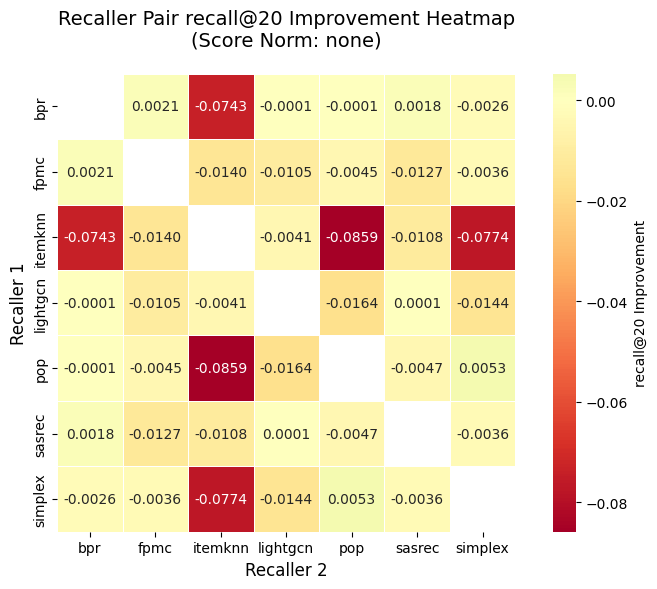

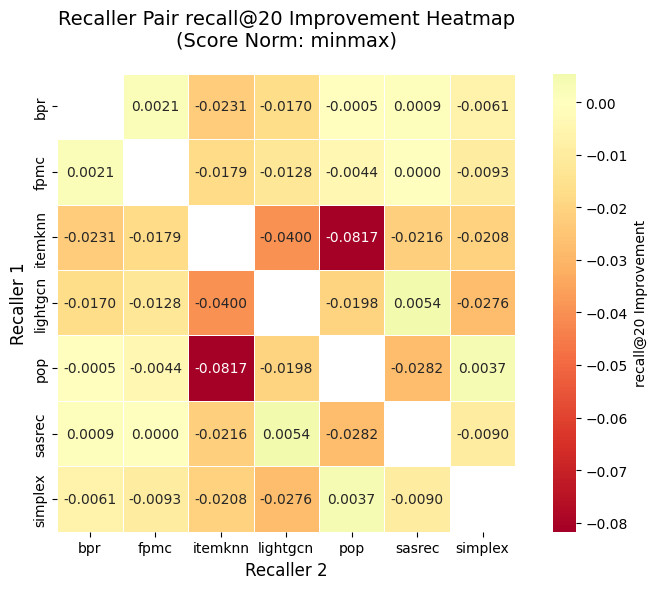

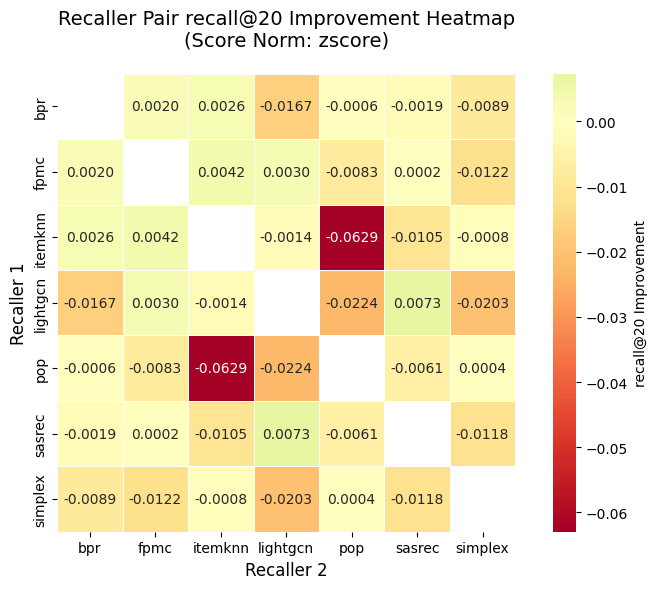

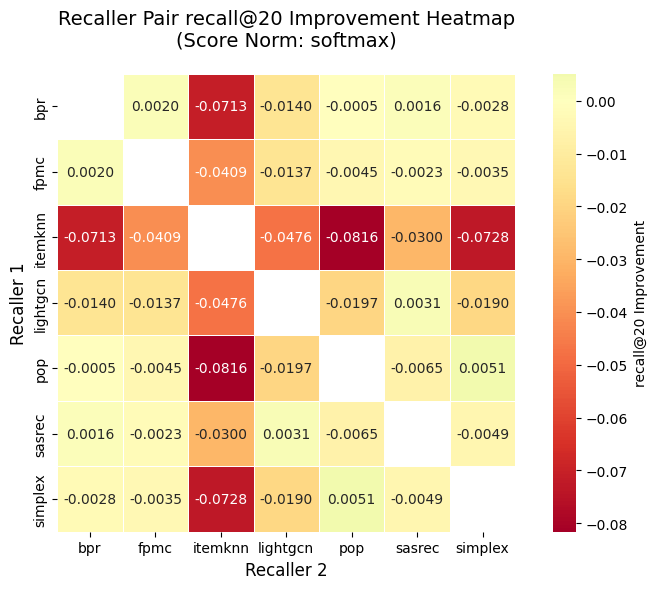

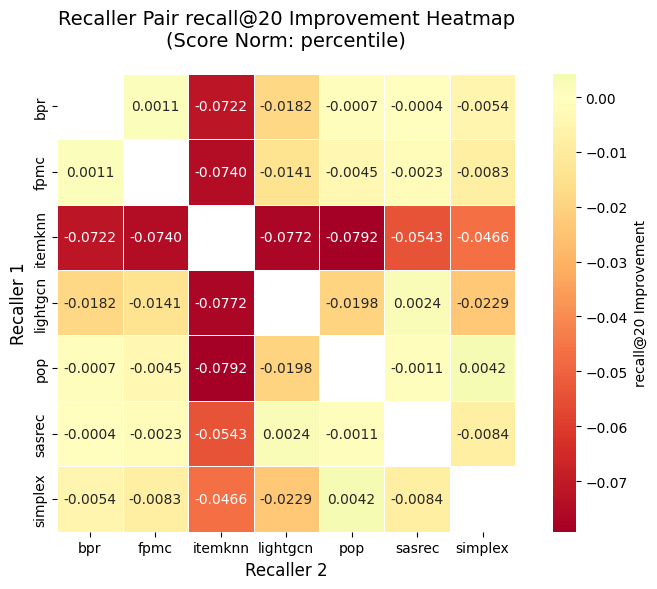

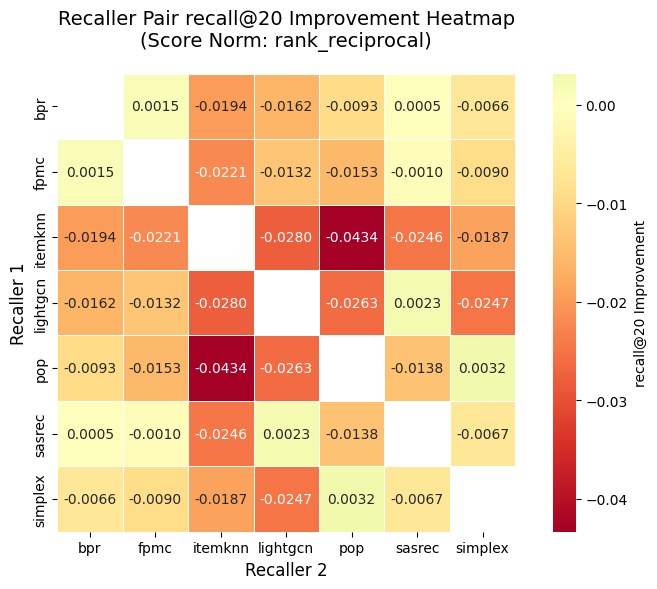

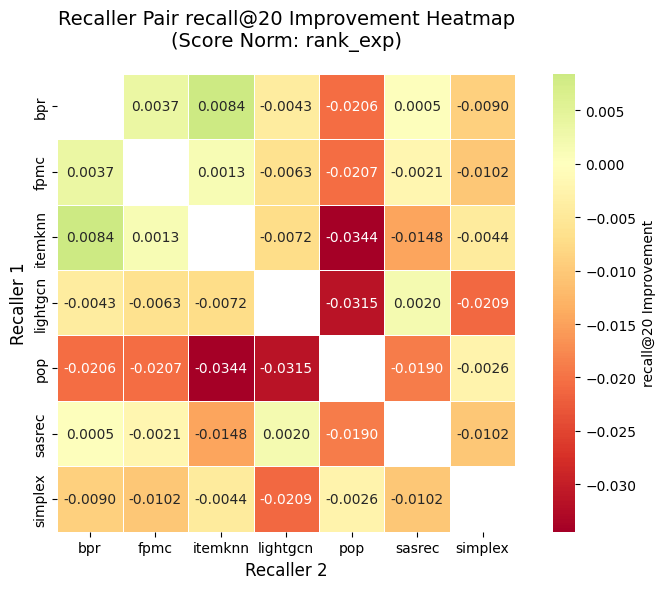

In [3]:
stem_prediction_file = "results/baseline_predictions_steam_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json"
steam_results = evaluate_score_norms(stem_prediction_file, ks=[10, 20, 50], test_pairs=True)

Loading predictions from: results/baseline_predictions_ml-1m_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json
Loaded 6038 predictions
Available recallers: ['bpr', 'fpmc', 'itemknn', 'lightgcn', 'pop', 'sasrec', 'simplex']

Testing 21 pairs of recallers
Quota mode: round, Tie-break: next_score

################################################################################
Combo 1/21: bpr_fpmc
################################################################################



  Average Metrics:
    NDCG@10: 0.0672, Recall@10: 0.1247
    NDCG@20: 0.0840, Recall@20: 0.1916
    NDCG@50: 0.1091, Recall@50: 0.3186
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0850, Recall@10: 0.1540
    NDCG@20: 0.1034, Recall@20: 0.2274
    NDCG@50: 0.1272, Recall@50: 0.3476
  Improvement over Best Individual:
    NDCG@10: -0.0178, Recall@10: -0.0293
    NDCG@20: -0.0194, Recall@20: -0.0358
    NDCG@50: -0.0181, Recall@50: -0.0290

################################################################################
Combo 2/21: bpr_itemknn
################################################################################



  Average Metrics:
    NDCG@10: 0.0254, Recall@10: 0.0542
    NDCG@20: 0.0383, Recall@20: 0.1057
    NDCG@50: 0.0601, Recall@50: 0.2168
  Best Individual Recaller: itemknn
  Best Individual Metrics:
    NDCG@10: 0.0242, Recall@10: 0.0543
    NDCG@20: 0.0378, Recall@20: 0.1083
    NDCG@50: 0.0598, Recall@50: 0.2206
  Improvement over Best Individual:
    NDCG@10: +0.0012, Recall@10: -0.0002
    NDCG@20: +0.0005, Recall@20: -0.0026
    NDCG@50: +0.0003, Recall@50: -0.0038

################################################################################
Combo 3/21: bpr_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0263, Recall@10: 0.0545
    NDCG@20: 0.0361, Recall@20: 0.0936
    NDCG@50: 0.0556, Recall@50: 0.1926
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0257, Recall@10: 0.0528
    NDCG@20: 0.0368, Recall@20: 0.0972
    NDCG@50: 0.0568, Recall@50: 0.1987
  Improvement over Best Individual:
    NDCG@10: +0.0005, Recall@10: +0.0017
    NDCG@20: -0.0008, Recall@20: -0.0036
    NDCG@50: -0.0012, Recall@50: -0.0061

################################################################################
Combo 4/21: bpr_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0196, Recall@10: 0.0374
    NDCG@20: 0.0295, Recall@20: 0.0772
    NDCG@50: 0.0469, Recall@50: 0.1655
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0249, Recall@10: 0.0499
    NDCG@20: 0.0353, Recall@20: 0.0909
    NDCG@50: 0.0550, Recall@50: 0.1915
  Improvement over Best Individual:
    NDCG@10: -0.0053, Recall@10: -0.0124
    NDCG@20: -0.0057, Recall@20: -0.0137
    NDCG@50: -0.0081, Recall@50: -0.0260

################################################################################
Combo 5/21: bpr_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0845, Recall@10: 0.1572
    NDCG@20: 0.1038, Recall@20: 0.2337
    NDCG@50: 0.1306, Recall@50: 0.3697
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0257, Recall@10: -0.0422
    NDCG@20: -0.0261, Recall@20: -0.0437
    NDCG@50: -0.0264, Recall@50: -0.0446

################################################################################
Combo 6/21: bpr_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0222, Recall@10: 0.0432
    NDCG@20: 0.0301, Recall@20: 0.0745
    NDCG@50: 0.0463, Recall@50: 0.1562
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0249, Recall@10: 0.0499
    NDCG@20: 0.0353, Recall@20: 0.0909
    NDCG@50: 0.0550, Recall@50: 0.1915
  Improvement over Best Individual:
    NDCG@10: -0.0027, Recall@10: -0.0066
    NDCG@20: -0.0051, Recall@20: -0.0164
    NDCG@50: -0.0087, Recall@50: -0.0353

################################################################################
Combo 7/21: fpmc_itemknn
################################################################################



  Average Metrics:
    NDCG@10: 0.0630, Recall@10: 0.1257
    NDCG@20: 0.0797, Recall@20: 0.1923
    NDCG@50: 0.1064, Recall@50: 0.3271
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0850, Recall@10: 0.1540
    NDCG@20: 0.1034, Recall@20: 0.2274
    NDCG@50: 0.1272, Recall@50: 0.3476
  Improvement over Best Individual:
    NDCG@10: -0.0220, Recall@10: -0.0283
    NDCG@20: -0.0237, Recall@20: -0.0351
    NDCG@50: -0.0208, Recall@50: -0.0205

################################################################################
Combo 8/21: fpmc_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0615, Recall@10: 0.1264
    NDCG@20: 0.0777, Recall@20: 0.1913
    NDCG@50: 0.1031, Recall@50: 0.3203
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0850, Recall@10: 0.1540
    NDCG@20: 0.1034, Recall@20: 0.2274
    NDCG@50: 0.1272, Recall@50: 0.3476
  Improvement over Best Individual:
    NDCG@10: -0.0235, Recall@10: -0.0277
    NDCG@20: -0.0257, Recall@20: -0.0361
    NDCG@50: -0.0241, Recall@50: -0.0273

################################################################################
Combo 9/21: fpmc_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0647, Recall@10: 0.1130
    NDCG@20: 0.0806, Recall@20: 0.1757
    NDCG@50: 0.1058, Recall@50: 0.3029
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0850, Recall@10: 0.1540
    NDCG@20: 0.1034, Recall@20: 0.2274
    NDCG@50: 0.1272, Recall@50: 0.3476
  Improvement over Best Individual:
    NDCG@10: -0.0203, Recall@10: -0.0411
    NDCG@20: -0.0229, Recall@20: -0.0517
    NDCG@50: -0.0215, Recall@50: -0.0447

################################################################################
Combo 10/21: fpmc_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.1039, Recall@10: 0.1895
    NDCG@20: 0.1234, Recall@20: 0.2670
    NDCG@50: 0.1502, Recall@50: 0.4021
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0063, Recall@10: -0.0099
    NDCG@20: -0.0065, Recall@20: -0.0104
    NDCG@50: -0.0069, Recall@50: -0.0121

################################################################################
Combo 11/21: fpmc_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0671, Recall@10: 0.1183
    NDCG@20: 0.0820, Recall@20: 0.1774
    NDCG@50: 0.1055, Recall@50: 0.2958
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0850, Recall@10: 0.1540
    NDCG@20: 0.1034, Recall@20: 0.2274
    NDCG@50: 0.1272, Recall@50: 0.3476
  Improvement over Best Individual:
    NDCG@10: -0.0179, Recall@10: -0.0358
    NDCG@20: -0.0214, Recall@20: -0.0500
    NDCG@50: -0.0217, Recall@50: -0.0518

################################################################################
Combo 12/21: itemknn_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0259, Recall@10: 0.0545
    NDCG@20: 0.0388, Recall@20: 0.1060
    NDCG@50: 0.0612, Recall@50: 0.2198
  Best Individual Recaller: itemknn
  Best Individual Metrics:
    NDCG@10: 0.0242, Recall@10: 0.0543
    NDCG@20: 0.0378, Recall@20: 0.1083
    NDCG@50: 0.0598, Recall@50: 0.2206
  Improvement over Best Individual:
    NDCG@10: +0.0017, Recall@10: +0.0002
    NDCG@20: +0.0010, Recall@20: -0.0023
    NDCG@50: +0.0014, Recall@50: -0.0008

################################################################################
Combo 13/21: itemknn_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0184, Recall@10: 0.0411
    NDCG@20: 0.0293, Recall@20: 0.0850
    NDCG@50: 0.0489, Recall@50: 0.1842
  Best Individual Recaller: itemknn
  Best Individual Metrics:
    NDCG@10: 0.0242, Recall@10: 0.0543
    NDCG@20: 0.0378, Recall@20: 0.1083
    NDCG@50: 0.0598, Recall@50: 0.2206
  Improvement over Best Individual:
    NDCG@10: -0.0058, Recall@10: -0.0132
    NDCG@20: -0.0084, Recall@20: -0.0234
    NDCG@50: -0.0109, Recall@50: -0.0364

################################################################################
Combo 14/21: itemknn_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0783, Recall@10: 0.1563
    NDCG@20: 0.0981, Recall@20: 0.2353
    NDCG@50: 0.1257, Recall@50: 0.3746
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0319, Recall@10: -0.0431
    NDCG@20: -0.0317, Recall@20: -0.0421
    NDCG@50: -0.0313, Recall@50: -0.0396

################################################################################
Combo 15/21: itemknn_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0205, Recall@10: 0.0452
    NDCG@20: 0.0307, Recall@20: 0.0860
    NDCG@50: 0.0483, Recall@50: 0.1747
  Best Individual Recaller: itemknn
  Best Individual Metrics:
    NDCG@10: 0.0242, Recall@10: 0.0543
    NDCG@20: 0.0378, Recall@20: 0.1083
    NDCG@50: 0.0598, Recall@50: 0.2206
  Improvement over Best Individual:
    NDCG@10: -0.0037, Recall@10: -0.0091
    NDCG@20: -0.0071, Recall@20: -0.0224
    NDCG@50: -0.0115, Recall@50: -0.0459

################################################################################
Combo 16/21: lightgcn_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0201, Recall@10: 0.0407
    NDCG@20: 0.0301, Recall@20: 0.0808
    NDCG@50: 0.0475, Recall@50: 0.1693
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0257, Recall@10: 0.0528
    NDCG@20: 0.0368, Recall@20: 0.0972
    NDCG@50: 0.0568, Recall@50: 0.1987
  Improvement over Best Individual:
    NDCG@10: -0.0056, Recall@10: -0.0121
    NDCG@20: -0.0067, Recall@20: -0.0164
    NDCG@50: -0.0092, Recall@50: -0.0295

################################################################################
Combo 17/21: lightgcn_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0785, Recall@10: 0.1583
    NDCG@20: 0.0976, Recall@20: 0.2348
    NDCG@50: 0.1245, Recall@50: 0.3713
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0317, Recall@10: -0.0411
    NDCG@20: -0.0323, Recall@20: -0.0426
    NDCG@50: -0.0325, Recall@50: -0.0429

################################################################################
Combo 18/21: lightgcn_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0224, Recall@10: 0.0452
    NDCG@20: 0.0310, Recall@20: 0.0793
    NDCG@50: 0.0471, Recall@50: 0.1610
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0257, Recall@10: 0.0528
    NDCG@20: 0.0368, Recall@20: 0.0972
    NDCG@50: 0.0568, Recall@50: 0.1987
  Improvement over Best Individual:
    NDCG@10: -0.0033, Recall@10: -0.0076
    NDCG@20: -0.0059, Recall@20: -0.0179
    NDCG@50: -0.0097, Recall@50: -0.0378

################################################################################
Combo 19/21: pop_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0836, Recall@10: 0.1464
    NDCG@20: 0.1024, Recall@20: 0.2209
    NDCG@50: 0.1287, Recall@50: 0.3536
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0266, Recall@10: -0.0530
    NDCG@20: -0.0274, Recall@20: -0.0565
    NDCG@50: -0.0284, Recall@50: -0.0606

################################################################################
Combo 20/21: pop_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0121, Recall@10: 0.0277
    NDCG@20: 0.0192, Recall@20: 0.0558
    NDCG@50: 0.0297, Recall@50: 0.1095
  Best Individual Recaller: pop
  Best Individual Metrics:
    NDCG@10: 0.0113, Recall@10: 0.0272
    NDCG@20: 0.0183, Recall@20: 0.0552
    NDCG@50: 0.0318, Recall@50: 0.1244
  Improvement over Best Individual:
    NDCG@10: +0.0008, Recall@10: +0.0005
    NDCG@20: +0.0009, Recall@20: +0.0007
    NDCG@50: -0.0021, Recall@50: -0.0149

################################################################################
Combo 21/21: sasrec_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0857, Recall@10: 0.1507
    NDCG@20: 0.1036, Recall@20: 0.2214
    NDCG@50: 0.1286, Recall@50: 0.3471
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.1102, Recall@10: 0.1994
    NDCG@20: 0.1299, Recall@20: 0.2774
    NDCG@50: 0.1570, Recall@50: 0.4142
  Improvement over Best Individual:
    NDCG@10: -0.0245, Recall@10: -0.0487
    NDCG@20: -0.0263, Recall@20: -0.0560
    NDCG@50: -0.0285, Recall@50: -0.0671

Summary Comparison - Top-K Merge
Combo                             NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}
------------------------------------------------------------------------------------------------------
fpmc_sasrec                         0.1039       0.1895 (-0.0063/-0.0099)      0.1234       0.2670 (-0.0065/-0.0104)      0.1502       0.4021 (-0.0069/-0.0121)  [best: sasrec]
bpr_sasrec                          0.0845       0.1572 (-0.0257/-0.0422)      0.1038       0.2337 (-0.026

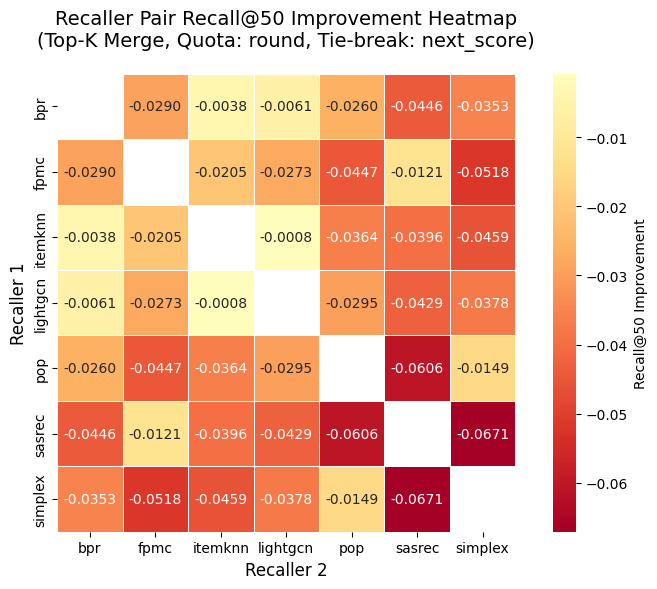

In [7]:
ml_topk_merge_results = evaluate_top_k_merge(prediction_file, ks=[10, 20, 50], test_pairs=True)

Loading predictions from: results/baseline_predictions_steam_bpr_fpmc_itemknn_lightgcn_pop_sasrec_simplex.json
Loaded 19603 predictions
Available recallers: ['bpr', 'fpmc', 'itemknn', 'lightgcn', 'pop', 'sasrec', 'simplex']

Testing 21 pairs of recallers
Quota mode: round, Tie-break: next_score

################################################################################
Combo 1/21: bpr_fpmc
################################################################################



  Average Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1242
    NDCG@20: 0.0820, Recall@20: 0.1909
    NDCG@50: 0.1029, Recall@50: 0.2971
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0643, Recall@10: 0.1231
    NDCG@20: 0.0806, Recall@20: 0.1878
    NDCG@50: 0.1050, Recall@50: 0.3138
  Improvement over Best Individual:
    NDCG@10: +0.0010, Recall@10: +0.0011
    NDCG@20: +0.0015, Recall@20: +0.0031
    NDCG@50: -0.0021, Recall@50: -0.0167

################################################################################
Combo 2/21: bpr_itemknn
################################################################################



  Average Metrics:
    NDCG@10: 0.0541, Recall@10: 0.1139
    NDCG@20: 0.0744, Recall@20: 0.1947
    NDCG@50: 0.0977, Recall@50: 0.3121
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0643, Recall@10: 0.1231
    NDCG@20: 0.0806, Recall@20: 0.1878
    NDCG@50: 0.1050, Recall@50: 0.3138
  Improvement over Best Individual:
    NDCG@10: -0.0102, Recall@10: -0.0092
    NDCG@20: -0.0062, Recall@20: +0.0068
    NDCG@50: -0.0073, Recall@50: -0.0017

################################################################################
Combo 3/21: bpr_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0649, Recall@10: 0.1239
    NDCG@20: 0.0844, Recall@20: 0.2021
    NDCG@50: 0.1072, Recall@50: 0.3147
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1240
    NDCG@20: 0.0858, Recall@20: 0.2064
    NDCG@50: 0.1073, Recall@50: 0.3128
  Improvement over Best Individual:
    NDCG@10: -0.0003, Recall@10: -0.0002
    NDCG@20: -0.0014, Recall@20: -0.0043
    NDCG@50: -0.0001, Recall@50: +0.0019

################################################################################
Combo 4/21: bpr_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0467, Recall@10: 0.0962
    NDCG@20: 0.0648, Recall@20: 0.1677
    NDCG@50: 0.0853, Recall@50: 0.2705
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0643, Recall@10: 0.1231
    NDCG@20: 0.0806, Recall@20: 0.1878
    NDCG@50: 0.1050, Recall@50: 0.3138
  Improvement over Best Individual:
    NDCG@10: -0.0176, Recall@10: -0.0269
    NDCG@20: -0.0158, Recall@20: -0.0201
    NDCG@50: -0.0197, Recall@50: -0.0433

################################################################################
Combo 5/21: bpr_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0826, Recall@10: 0.1513
    NDCG@20: 0.0995, Recall@20: 0.2186
    NDCG@50: 0.1213, Recall@50: 0.3287
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0012, Recall@10: -0.0040
    NDCG@20: +0.0003, Recall@20: +0.0019
    NDCG@50: -0.0008, Recall@50: -0.0037

################################################################################
Combo 6/21: bpr_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0598, Recall@10: 0.1169
    NDCG@20: 0.0754, Recall@20: 0.1790
    NDCG@50: 0.0950, Recall@50: 0.2785
  Best Individual Recaller: bpr
  Best Individual Metrics:
    NDCG@10: 0.0643, Recall@10: 0.1231
    NDCG@20: 0.0806, Recall@20: 0.1878
    NDCG@50: 0.1050, Recall@50: 0.3138
  Improvement over Best Individual:
    NDCG@10: -0.0044, Recall@10: -0.0062
    NDCG@20: -0.0052, Recall@20: -0.0088
    NDCG@50: -0.0101, Recall@50: -0.0353

################################################################################
Combo 7/21: fpmc_itemknn
################################################################################



  Average Metrics:
    NDCG@10: 0.0586, Recall@10: 0.1113
    NDCG@20: 0.0787, Recall@20: 0.1908
    NDCG@50: 0.1021, Recall@50: 0.3084
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0659, Recall@10: 0.1252
    NDCG@20: 0.0822, Recall@20: 0.1907
    NDCG@50: 0.1016, Recall@50: 0.2884
  Improvement over Best Individual:
    NDCG@10: -0.0073, Recall@10: -0.0139
    NDCG@20: -0.0036, Recall@20: +0.0002
    NDCG@50: +0.0006, Recall@50: +0.0200

################################################################################
Combo 8/21: fpmc_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0656, Recall@10: 0.1252
    NDCG@20: 0.0846, Recall@20: 0.2012
    NDCG@50: 0.1082, Recall@50: 0.3177
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1240
    NDCG@20: 0.0858, Recall@20: 0.2064
    NDCG@50: 0.1073, Recall@50: 0.3128
  Improvement over Best Individual:
    NDCG@10: +0.0004, Recall@10: +0.0012
    NDCG@20: -0.0012, Recall@20: -0.0052
    NDCG@50: +0.0009, Recall@50: +0.0049

################################################################################
Combo 9/21: fpmc_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0515, Recall@10: 0.0960
    NDCG@20: 0.0702, Recall@20: 0.1699
    NDCG@50: 0.0908, Recall@50: 0.2724
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0659, Recall@10: 0.1252
    NDCG@20: 0.0822, Recall@20: 0.1907
    NDCG@50: 0.1016, Recall@50: 0.2884
  Improvement over Best Individual:
    NDCG@10: -0.0144, Recall@10: -0.0292
    NDCG@20: -0.0120, Recall@20: -0.0208
    NDCG@50: -0.0108, Recall@50: -0.0160

################################################################################
Combo 10/21: fpmc_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0818, Recall@10: 0.1524
    NDCG@20: 0.0978, Recall@20: 0.2158
    NDCG@50: 0.1205, Recall@50: 0.3306
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0020, Recall@10: -0.0029
    NDCG@20: -0.0014, Recall@20: -0.0009
    NDCG@50: -0.0015, Recall@50: -0.0018

################################################################################
Combo 11/21: fpmc_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0622, Recall@10: 0.1174
    NDCG@20: 0.0779, Recall@20: 0.1795
    NDCG@50: 0.0976, Recall@50: 0.2788
  Best Individual Recaller: fpmc
  Best Individual Metrics:
    NDCG@10: 0.0659, Recall@10: 0.1252
    NDCG@20: 0.0822, Recall@20: 0.1907
    NDCG@50: 0.1016, Recall@50: 0.2884
  Improvement over Best Individual:
    NDCG@10: -0.0036, Recall@10: -0.0078
    NDCG@20: -0.0043, Recall@20: -0.0112
    NDCG@50: -0.0040, Recall@50: -0.0095

################################################################################
Combo 12/21: itemknn_lightgcn
################################################################################



  Average Metrics:
    NDCG@10: 0.0586, Recall@10: 0.1115
    NDCG@20: 0.0802, Recall@20: 0.1974
    NDCG@50: 0.1053, Recall@50: 0.3230
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1240
    NDCG@20: 0.0858, Recall@20: 0.2064
    NDCG@50: 0.1073, Recall@50: 0.3128
  Improvement over Best Individual:
    NDCG@10: -0.0066, Recall@10: -0.0125
    NDCG@20: -0.0056, Recall@20: -0.0090
    NDCG@50: -0.0020, Recall@50: +0.0102

################################################################################
Combo 13/21: itemknn_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0216, Recall@10: 0.0538
    NDCG@20: 0.0419, Recall@20: 0.1336
    NDCG@50: 0.0726, Recall@50: 0.2841
  Best Individual Recaller: pop
  Best Individual Metrics:
    NDCG@10: 0.0312, Recall@10: 0.0812
    NDCG@20: 0.0530, Recall@20: 0.1690
    NDCG@50: 0.0681, Recall@50: 0.2437
  Improvement over Best Individual:
    NDCG@10: -0.0096, Recall@10: -0.0273
    NDCG@20: -0.0112, Recall@20: -0.0354
    NDCG@50: +0.0046, Recall@50: +0.0404

################################################################################
Combo 14/21: itemknn_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0710, Recall@10: 0.1309
    NDCG@20: 0.0889, Recall@20: 0.2008
    NDCG@50: 0.1130, Recall@50: 0.3225
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0128, Recall@10: -0.0244
    NDCG@20: -0.0104, Recall@20: -0.0159
    NDCG@50: -0.0091, Recall@50: -0.0099

################################################################################
Combo 15/21: itemknn_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0427, Recall@10: 0.0890
    NDCG@20: 0.0602, Recall@20: 0.1588
    NDCG@50: 0.0844, Recall@50: 0.2806
  Best Individual Recaller: simplex
  Best Individual Metrics:
    NDCG@10: 0.0539, Recall@10: 0.1047
    NDCG@20: 0.0688, Recall@20: 0.1636
    NDCG@50: 0.0866, Recall@50: 0.2533
  Improvement over Best Individual:
    NDCG@10: -0.0112, Recall@10: -0.0157
    NDCG@20: -0.0086, Recall@20: -0.0049
    NDCG@50: -0.0021, Recall@50: +0.0273

################################################################################
Combo 16/21: lightgcn_pop
################################################################################



  Average Metrics:
    NDCG@10: 0.0516, Recall@10: 0.0975
    NDCG@20: 0.0702, Recall@20: 0.1713
    NDCG@50: 0.0969, Recall@50: 0.3030
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1240
    NDCG@20: 0.0858, Recall@20: 0.2064
    NDCG@50: 0.1073, Recall@50: 0.3128
  Improvement over Best Individual:
    NDCG@10: -0.0136, Recall@10: -0.0265
    NDCG@20: -0.0156, Recall@20: -0.0351
    NDCG@50: -0.0104, Recall@50: -0.0098

################################################################################
Combo 17/21: lightgcn_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0790, Recall@10: 0.1517
    NDCG@20: 0.0960, Recall@20: 0.2192
    NDCG@50: 0.1207, Recall@50: 0.3437
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0048, Recall@10: -0.0036
    NDCG@20: -0.0032, Recall@20: +0.0024
    NDCG@50: -0.0013, Recall@50: +0.0113

################################################################################
Combo 18/21: lightgcn_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0607, Recall@10: 0.1145
    NDCG@20: 0.0779, Recall@20: 0.1826
    NDCG@50: 0.1025, Recall@50: 0.3051
  Best Individual Recaller: lightgcn
  Best Individual Metrics:
    NDCG@10: 0.0652, Recall@10: 0.1240
    NDCG@20: 0.0858, Recall@20: 0.2064
    NDCG@50: 0.1073, Recall@50: 0.3128
  Improvement over Best Individual:
    NDCG@10: -0.0044, Recall@10: -0.0095
    NDCG@20: -0.0079, Recall@20: -0.0238
    NDCG@50: -0.0048, Recall@50: -0.0077

################################################################################
Combo 19/21: pop_sasrec
################################################################################



  Average Metrics:
    NDCG@10: 0.0664, Recall@10: 0.1209
    NDCG@20: 0.0855, Recall@20: 0.1961
    NDCG@50: 0.1083, Recall@50: 0.3111
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0174, Recall@10: -0.0344
    NDCG@20: -0.0138, Recall@20: -0.0206
    NDCG@50: -0.0137, Recall@50: -0.0212

################################################################################
Combo 20/21: pop_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0384, Recall@10: 0.0891
    NDCG@20: 0.0566, Recall@20: 0.1612
    NDCG@50: 0.0756, Recall@50: 0.2563
  Best Individual Recaller: simplex
  Best Individual Metrics:
    NDCG@10: 0.0539, Recall@10: 0.1047
    NDCG@20: 0.0688, Recall@20: 0.1636
    NDCG@50: 0.0866, Recall@50: 0.2533
  Improvement over Best Individual:
    NDCG@10: -0.0156, Recall@10: -0.0156
    NDCG@20: -0.0122, Recall@20: -0.0024
    NDCG@50: -0.0110, Recall@50: +0.0030

################################################################################
Combo 21/21: sasrec_simplex
################################################################################



  Average Metrics:
    NDCG@10: 0.0779, Recall@10: 0.1407
    NDCG@20: 0.0944, Recall@20: 0.2056
    NDCG@50: 0.1163, Recall@50: 0.3163
  Best Individual Recaller: sasrec
  Best Individual Metrics:
    NDCG@10: 0.0838, Recall@10: 0.1553
    NDCG@20: 0.0993, Recall@20: 0.2167
    NDCG@50: 0.1221, Recall@50: 0.3323
  Improvement over Best Individual:
    NDCG@10: -0.0059, Recall@10: -0.0146
    NDCG@20: -0.0049, Recall@20: -0.0111
    NDCG@50: -0.0058, Recall@50: -0.0161

Summary Comparison - Top-K Merge
Combo                             NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}    NDCG@{k}   Recall@{k}
------------------------------------------------------------------------------------------------------
bpr_sasrec                          0.0826       0.1513 (-0.0012/-0.0040)      0.0995       0.2186 (+0.0003/+0.0019)      0.1213       0.3287 (-0.0008/-0.0037)  [best: sasrec]
lightgcn_sasrec                     0.0790       0.1517 (-0.0048/-0.0036)      0.0960       0.2192 (-0.003

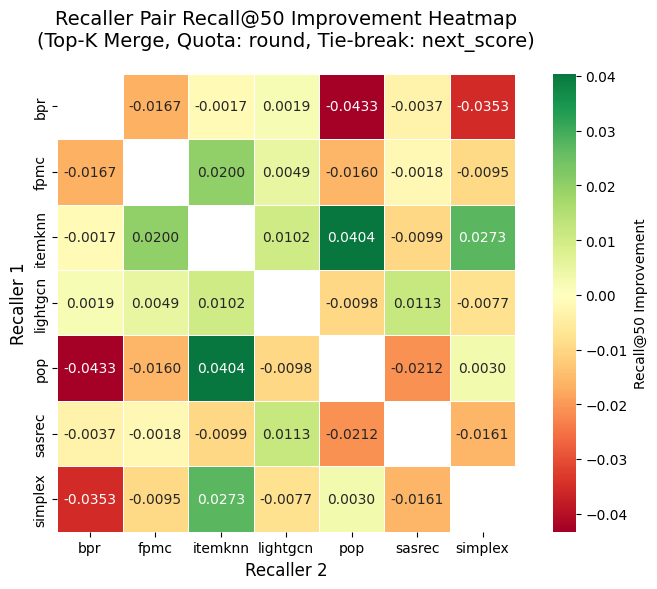

In [8]:
steam_topk_merge_results = evaluate_top_k_merge(stem_prediction_file, ks=[10, 20, 50], test_pairs=True)

In [1]:
import pandas as pd

steam = pd.read_csv('steam.csv')

In [2]:
steam

,Unnamed: 0,user_id,play_hours,products,product_id,page_order,timestamp,early_access,page,found_funny,compensation,times
0,0,1,8.9,227.0,1,3.0,1.514938e+09,1,1.0,0,0,1.0
1,1,2,14.1,54.0,2,1.0,1.514333e+09,1,1.0,0,0,1.0
2,2,3,9.5,1172.0,1,9.0,1.514851e+09,1,1.0,0,0,1.0
3,3,4,422.1,12.0,3,3.0,1.515024e+09,1,1.0,0,0,1.0
4,4,5,75.0,5.0,3,5.0,1.515024e+09,1,1.0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
328273,328273,13579,146.9,50.0,86,0.0,1.386720e+09,2,10216.0,0,0,1.0
328274,328274,24982,1180.6,139.0,86,6.0,1.386720e+09,2,10218.0,0,0,1.0
328275,328275,11789,142.7,67.0,86,7.0,1.386720e+09,2,10218.0,0,0,1.0
328276,328276,5055,198.5,112.0,86,8.0,1.386720e+09,2,10220.0,0,0,1.0
